In [1]:
import torch
import json
import numpy
from sklearn.preprocessing import MinMaxScaler
import shap
import sys
import time
import pandas as pd
import os
import re

In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [3]:
def load_dataset(path, dataset):
    with open(path + dataset + "_TRAIN.npy", 'rb') as f:
        train = numpy.load(f, allow_pickle=True)
    print("Train shape:", train.shape)
    with open(path + dataset + "_TEST.npy", 'rb') as f:
        test = numpy.load(f, allow_pickle=True)
    print("Test shape:", test.shape)
    #scaling
    scaler = MinMaxScaler()
    train = scaler.fit_transform(train.reshape(-1,train.shape[-1])).reshape(train.shape)
    test = scaler.fit_transform(test.reshape(-1,test.shape[-1])).reshape(test.shape)
    return train, test

In [4]:
def load_cluster_labels(path, cluster_labels):
    print("Silhouette Score:", cluster_labels.split('SilhouetteScore_')[1].split('_')[0])
    cluster_labels = numpy.load(path + cluster_labels)
    print("Number of clusters:", len(set(cluster_labels)))
    print("Clusters:", set(cluster_labels))
    print("Cluster Labels:",cluster_labels)
    return cluster_labels

In [5]:
def get_data_per_cluster(cluster_indices, data, print_=False):
    cluster_data = numpy.array([])
    count = 0
    for i in cluster_indices:
        sample = data[i].reshape(1, data.shape[1])
        # reshape to (x, 1)
        sample = sample.reshape(1, sample.shape[1])
        if print_:
            print(sample.shape)
        if count == 0:
            cluster_data = sample
        else:
            cluster_data = numpy.append(cluster_data, sample, axis=0) 
        count = count + 1
    if print_:
        print(cluster_data.shape)
    return cluster_data

In [6]:
def get_anomaly_cluster_association(cluster_labels, cluster):
    # get position (index) of each anomaly belonging to a cluster
    cluster_indices = [index for index, value in enumerate(cluster_labels) if value == cluster]
    print(len(cluster_indices),"samples in cluster", cluster)
    return cluster_indices

In [7]:
def get_plots_per_sample_within_cluster(cluster_indices, shap_values, sample_values, features):
    for i in cluster_indices:
        print("Sample:",i)
        shap_values_sample = shap_values[i].reshape(1, shap_values.shape[1])
        sample = sample_values[i].reshape(1, sample_values.shape[1])
        shap.summary_plot(shap_values_sample, sample, feature_names=features, max_display=20)

## Feature Number - Real Name Association

In [8]:
df = pd.read_csv("/home/sto2/storage_data/df_actualAnomalies_reducedFeatures_sergeValidated.csv")
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.drop(['systemid','instanceid'], axis=1, inplace=True)
features = df.columns[2:].to_list()

source_path = "/home/sto2/0-final_storageData_arrays/"
all_files = os.listdir(source_path)
counter = 1
features_order_in_data = []
for file in sorted(all_files):
    dimension_number = int(re.findall(r'\d+', file)[0])
    print(file, features[dimension_number-1])
    features_order_in_data.append(features[dimension_number-1])
    counter+=1

df_actualAnomalies_reducedFeatures_sergeValidatedDimension1.npy Read Cache Hits - VCC (%)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension10.npy Overall Back-end Response Time (ms/op)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension11.npy Back-end Read Queue Time (ms/op)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension12.npy Back-end Write Queue Time (ms/op)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension13.npy Back-end Read Transfer Size (KiB/op)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension14.npy Back-end Write Transfer Size (KiB/op)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension15.npy Read I/O Rate - overall (ops/s)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension16.npy Write I/O Rate - overall (ops/s)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension17.npy Peak Back-end Read Response Time (ms)
df_actualAnomalies_reducedFeatures_sergeValidatedDimension18.npy Port Send Data Rate (MiB/s)
df_actualAnom

In [9]:
features_order_in_data

['Read Cache Hits - VCC (%)',
 'Overall Back-end Response Time (ms/op)',
 'Back-end Read Queue Time (ms/op)',
 'Back-end Write Queue Time (ms/op)',
 'Back-end Read Transfer Size (KiB/op)',
 'Back-end Write Transfer Size (KiB/op)',
 'Read I/O Rate - overall (ops/s)',
 'Write I/O Rate - overall (ops/s)',
 'Peak Back-end Read Response Time (ms)',
 'Port Send Data Rate (MiB/s)',
 'Write Data Rate (MiB/s)',
 'Read Cache Hits - VC (%)',
 'Read Response Time (ms/op)',
 'Write Response Time (ms/op)',
 'Port Receive Data Rate (MiB/s)',
 'Overall Response Time (ms/op)',
 'Read Transfer Size (KiB/op)',
 'Write Transfer Size (KiB/op)',
 'Port Send I/O Rate (ops/s)',
 'Total Cache Hits - VCC (%)',
 'Total Cache Hits - VC (%)',
 'Port to Host Send I/O Rate (ops/s)',
 'Write Cache Hits - VCC (%)',
 'Port to Disk Send I/O Rate (ops/s)',
 'Port to Disk Receive I/O Rate (ops/s)',
 'Port to Local Node Send I/O Rate (ops/s)',
 'Port to Remote Node Send I/O Rate (ops/s)',
 'Port to Disk Send Data Rate (MiB

## Paths

In [10]:
data_path = '/home/sto/Data/0-actualAnomalies_reducedFeatures_sergeValidated_ZERO/'
dataset = '0-df_actualAnomalies_reducedFeatures_sergeValidated'

In [11]:
cluster_labels_path = "/home/sto/Data/0-sto-estimators-encoder/may01-whole_Data/"
cluster_labels = "0-df_actualAnomalies_reducedFeatures_sergeValidated_TrainedOn-WHOLE-Dataset_SilhouetteScore_0.8633223762692354_2clusters_labels.npy"

In [12]:
shap_values_path = '/home/sto/Data/0-SHAP/00wholeSet_May3/'
shap_values_name = 'shap-values_all-anomalies_samples-to-explain_83_CLUSTER_background-data_25'

## Background Data and Data to Explain

In [13]:
train, test = load_dataset(data_path, dataset)

Train shape: (66, 84, 1113)
Test shape: (17, 84, 1113)


In [14]:
dataset = numpy.concatenate((train,test))
print(dataset.shape)

(83, 84, 1113)


## Import Shap Values

### Assemble all Samples

In [15]:
all_files = os.listdir(shap_values_path)
all_files.sort(key=natural_keys)
shap_values = []
for file in all_files:
    if 'shap-values' in file:
        print(file)
        array = numpy.load(shap_values_path + file)
        shap_values.append(array)
print(len(shap_values))

shap-values_all-anomalies_samples-to-explain_83_CLUSTER_background-data_25_Anomaly__0Cluster_0.npy
shap-values_all-anomalies_samples-to-explain_83_CLUSTER_background-data_25_Anomaly__1Cluster_0.npy
shap-values_all-anomalies_samples-to-explain_83_CLUSTER_background-data_25_Anomaly__2Cluster_0.npy
shap-values_all-anomalies_samples-to-explain_83_CLUSTER_background-data_25_Anomaly__3Cluster_0.npy
shap-values_all-anomalies_samples-to-explain_83_CLUSTER_background-data_25_Anomaly__4Cluster_0.npy
shap-values_all-anomalies_samples-to-explain_83_CLUSTER_background-data_25_Anomaly__5Cluster_0.npy
shap-values_all-anomalies_samples-to-explain_83_CLUSTER_background-data_25_Anomaly__6Cluster_0.npy
shap-values_all-anomalies_samples-to-explain_83_CLUSTER_background-data_25_Anomaly__7Cluster_0.npy
shap-values_all-anomalies_samples-to-explain_83_CLUSTER_background-data_25_Anomaly__8Cluster_0.npy
shap-values_all-anomalies_samples-to-explain_83_CLUSTER_background-data_25_Anomaly__9Cluster_0.npy
shap-value

In [16]:
shap_values = numpy.concatenate(shap_values, axis=0 )
print(shap_values.shape)
print(shap_values)

(83, 84, 1113)
[[[ 3.82508192e-13 -8.08970316e-11  3.79132168e-10 ... -4.70115469e-06
   -3.63823217e-06 -5.58073365e-06]
  [ 7.90967162e-10 -6.30526729e-08  1.01936466e-08 ... -1.58858597e-08
   -1.89942429e-08 -1.67106612e-08]
  [-3.45132587e-16 -1.79773019e-13 -1.34767421e-13 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 1.84309458e-11  3.17320824e-09  6.06619673e-10 ... -6.20307862e-06
   -6.26228575e-06 -6.60236740e-06]
  [ 1.93232414e-11 -1.87751893e-07 -8.78757738e-08 ... -1.41766676e-06
   -1.89067284e-06 -1.09300315e-06]
  [-5.65653122e-12  1.52137297e-10 -2.99825785e-10 ... -2.01694794e-08
   -2.29958523e-08 -1.97203708e-08]]

 [[ 2.33174886e-13 -1.89602216e-10 -5.54706642e-10 ... -4.70115469e-06
   -3.63823217e-06 -5.58073365e-06]
  [-2.10666885e-09 -2.39872250e-07 -8.00487522e-08 ... -1.58858597e-08
   -1.89942428e-08 -1.67106612e-08]
  [-3.45132588e-16  9.43792437e-13 -1.34767421e-13 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 2.12

## Cut zero padded Shap Values and Samples to actual length of anomalies

In [17]:
anomalies_length = numpy.load("/home/sto/Data/0-actualAnomalies_reducedFeatures_sergeValidated/anomalies_length.npy")
print(anomalies_length.shape)
print(anomalies_length)

(83,)
[  30   63  319   27   66   74  961  121   95   26   26  276  673   26
  380   91  591  157   61   77  214  263  260  125  371  223  458   31
  205   81  241  631  514   31  425   35  355  283  470  370 1113  302
  291  849  429   32  298   26  421  101  126  228  301  233  185  724
   31  113  180  614  867   30   69   42  372  317  297   41   81  157
  233  489  179  469  115  666  149  480   87  272   49  449  335]


### Shap Values

In [18]:
new_shap_values = []
for i in range(0,83):
    feature_array = []
    length = anomalies_length[i]
    print("Anomaly #", i+1, "Length:", length)
    for x in range(0,84):
        print("Dimensions #",x+1)
        print(shap_values[i][x])
        print(shap_values[i][x].shape[0])
        new_anomaly = shap_values[i][x][:length]
        print(new_anomaly.shape[0])
        val_pad = 1113 - new_anomaly.shape[0]
        if val_pad != 0:
            new_anomaly = numpy.pad(new_anomaly, (0, val_pad), 'constant', constant_values=(numpy.nan))
        feature_array.append(new_anomaly)
    new_shap_values.append(feature_array)
    print("#####################################################")
new_shap_values = numpy.array(new_shap_values)

Anomaly # 1 Length: 30
Dimensions # 1
[ 3.82508192e-13 -8.08970316e-11  3.79132168e-10 ... -4.70115469e-06
 -3.63823217e-06 -5.58073365e-06]
1113
30
Dimensions # 2
[ 7.90967162e-10 -6.30526729e-08  1.01936466e-08 ... -1.58858597e-08
 -1.89942429e-08 -1.67106612e-08]
1113
30
Dimensions # 3
[-3.45132587e-16 -1.79773019e-13 -1.34767421e-13 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
30
Dimensions # 4
[-1.51235346e-16  1.76673210e-13  1.63838708e-12 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
30
Dimensions # 5
[-2.92714273e-08 -2.91376041e-06 -1.44940855e-06 ... -6.02279634e-06
 -4.58671248e-06 -5.53824409e-06]
1113
30
Dimensions # 6
[-2.71122381e-10 -6.09435533e-08 -2.15451141e-08 ... -2.12825177e-05
 -1.29884566e-05 -1.84164898e-05]
1113
30
Dimensions # 7
[ 3.32168902e-08 -9.45260293e-06 -9.97177121e-07 ... -6.82796542e-04
 -1.00555718e-03 -7.71933371e-04]
1113
30
Dimensions # 8
[ 8.92743214e-09 -2.34539107e-05 -1.11229202e-06 ... -9.03802668e-03
 -7.7833649

Dimensions # 30
[4.42187076e-10 3.25950467e-08 2.53737529e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
319
Dimensions # 31
[ 1.04132186e-12 -1.60958084e-11  2.29343141e-13 ...  2.39520964e-10
  2.33591137e-10  2.40238274e-10]
1113
319
Dimensions # 32
[0. 0. 0. ... 0. 0. 0.]
1113
319
Dimensions # 33
[ 1.15544708e-11  2.55641467e-10  5.73119400e-11 ... -1.23329684e-09
 -1.66555469e-09 -1.49376154e-09]
1113
319
Dimensions # 34
[ 8.89363770e-07 -5.10753879e-06  2.34542503e-05 ... -5.03941209e-02
 -6.96129730e-02 -5.67613353e-02]
1113
319
Dimensions # 35
[-6.01216146e-14 -5.62938779e-12 -3.75632544e-12 ... -2.26562834e-09
 -3.01969323e-09 -2.45111031e-09]
1113
319
Dimensions # 36
[-8.84934529e-13 -1.87498425e-08 -5.11029991e-11 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
319
Dimensions # 37
[ 0.00000000e+00 -1.17982133e-11  0.00000000e+00 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
319
Dimensions # 38
[0.00000000e+00 2.69287361e-09 0.00000000e+00

Dimensions # 6
[-4.04077448e-10 -7.01236075e-08 -1.88875395e-08 ... -2.12825177e-05
 -1.29884566e-05 -1.84164898e-05]
1113
74
Dimensions # 7
[ 1.33373964e-07 -9.83036075e-06 -1.25051300e-06 ... -6.82796542e-04
 -1.00555718e-03 -7.71933371e-04]
1113
74
Dimensions # 8
[ 2.99438280e-07  2.68079847e-05  7.86524049e-06 ... -9.03802668e-03
 -7.78336490e-03 -8.98987735e-03]
1113
74
Dimensions # 9
[ 2.19169434e-11 -1.36185340e-08 -7.04561594e-09 ... -2.39993931e-05
 -1.49255425e-04 -1.56301917e-05]
1113
74
Dimensions # 10
[2.63998130e-08 7.49070264e-07 5.10629831e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
74
Dimensions # 11
[ 1.50551105e-08  7.81407585e-07  4.66393853e-07 ... -3.55751245e-06
 -4.20884459e-06 -3.62569294e-06]
1113
74
Dimensions # 12
[5.58014929e-13 2.66760759e-10 3.33513147e-11 ... 0.00000000e+00
 1.14094048e-09 0.00000000e+00]
1113
74
Dimensions # 13
[-5.22933291e-12  6.02966413e-11  4.82676565e-10 ... -6.06845799e-08
 -7.93251620e-08 -7.75508672e-08]
1113
74


Dimensions # 28
[0.00000000e+00 1.30996993e-09 5.53139875e-10 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
95
Dimensions # 29
[0.00000000e+00 9.24934592e-08 1.13143331e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
95
Dimensions # 30
[2.47431769e-10 3.25950467e-08 1.25803917e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
95
Dimensions # 31
[ 1.22507767e-13 -1.74017547e-11 -4.38824366e-12 ...  2.39520964e-10
  2.33591137e-10  2.40238278e-10]
1113
95
Dimensions # 32
[0. 0. 0. ... 0. 0. 0.]
1113
95
Dimensions # 33
[-2.24292673e-11  2.55641467e-10 -2.22885495e-11 ... -1.23329684e-09
 -1.66555469e-09 -1.49376154e-09]
1113
95
Dimensions # 34
[ 8.68836001e-07  4.03871649e-05  3.08733192e-05 ... -5.03941209e-02
 -6.96129730e-02 -5.67613353e-02]
1113
95
Dimensions # 35
[ 7.65183147e-14 -8.75664360e-12  1.66132095e-12 ... -2.26562834e-09
 -3.01969322e-09 -2.45111031e-09]
1113
95
Dimensions # 36
[-8.84934528e-13 -1.87498425e-08 -5.11029991e-11 ...  0.00000000e

[ 0.00000000e+00 -1.17982133e-11  0.00000000e+00 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
26
Dimensions # 38
[0.00000000e+00 2.69287361e-09 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 39
[-1.94406463e-08 -9.26676701e-06 -1.32841287e-06 ... -4.16229218e-05
 -1.79969742e-04 -1.98572635e-05]
1113
26
Dimensions # 40
[ 4.58807362e-08  1.41289937e-06  2.92779588e-07 ... -2.51939563e-04
 -4.68636099e-03 -3.52736364e-03]
1113
26
Dimensions # 41
[-1.86207957e-15 -5.02026448e-11 -2.84218863e-13 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
26
Dimensions # 42
[ 1.66608302e-09 -8.25265329e-08  8.85451663e-08 ... -9.40893173e-07
 -7.36851236e-07 -9.65355523e-07]
1113
26
Dimensions # 43
[-3.99181497e-10  2.20727777e-08 -1.27842898e-08 ... -8.14077065e-05
 -2.24666839e-04 -1.37215296e-05]
1113
26
Dimensions # 44
[-4.68160299e-06 -3.86582046e-02 -1.90629484e-02 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
26
Dimens

Dimensions # 75
[-4.36297076e-10  9.01912449e-08 -2.12106710e-08 ... -5.97006154e-07
 -9.12066733e-07 -1.35802492e-06]
1113
673
Dimensions # 76
[-2.53340445e-10  2.70824969e-07 -9.10819587e-09 ... -9.57374822e-07
 -7.42694605e-07 -5.73763355e-07]
1113
673
Dimensions # 77
[-2.44484618e-15 -3.99883161e-13 -9.97078676e-14 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
673
Dimensions # 78
[ 6.70013764e-10  1.88884866e-08 -3.48363238e-11 ... -6.74001564e-09
 -8.87295238e-09 -7.50544227e-09]
1113
673
Dimensions # 79
[-8.99020960e-12 -1.11155122e-09  6.80375658e-11 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
673
Dimensions # 80
[-1.97331536e-11 -5.24253630e-10 -1.85450439e-11 ... -6.11229377e-06
 -6.17034646e-06 -6.50376971e-06]
1113
673
Dimensions # 81
[ 1.09710793e-10  9.96825418e-10 -4.44722161e-10 ... -7.03651387e-07
 -1.74494012e-06 -6.43188549e-07]
1113
673
Dimensions # 82
[-6.03530265e-12  1.21835925e-10 -1.42362997e-10 ... -6.20307862e-06
 -6.26228575e-06 -6

Dimensions # 57
[0. 0. 0. ... 0. 0. 0.]
1113
591
Dimensions # 58
[0. 0. 0. ... 0. 0. 0.]
1113
591
Dimensions # 59
[0. 0. 0. ... 0. 0. 0.]
1113
591
Dimensions # 60
[ 1.59338808e-08  9.82303234e-07  1.44556599e-07 ... -7.95224384e-02
 -7.95224365e-02 -7.95224387e-02]
1113
591
Dimensions # 61
[-4.56764209e-08 -1.01625812e-06 -2.95888964e-07 ... -6.38021619e-04
 -5.12776349e-04 -3.46936598e-04]
1113
591
Dimensions # 62
[ 7.82155681e-10 -3.06924232e-06 -2.21537424e-07 ... -2.97769410e-04
 -3.26838353e-04 -1.95561065e-04]
1113
591
Dimensions # 63
[ 2.35485076e-09 -4.27283145e-06 -2.78837378e-06 ... -4.17868250e-05
 -4.32642968e-05 -7.97055201e-05]
1113
591
Dimensions # 64
[ 8.01802851e-09  2.04441947e-05  2.36350150e-05 ... -9.76503747e-04
 -1.46629477e-03 -1.64375502e-03]
1113
591
Dimensions # 65
[ 5.80405724e-09  4.38292155e-07  1.19183355e-07 ... -2.60167848e-04
 -1.40956220e-04 -1.77423704e-04]
1113
591
Dimensions # 66
[-2.04061645e-10 -7.94052270e-09 -8.04338213e-09 ... -1.06427370e-07


Dimensions # 51
[-1.64542378e-13  1.17910675e-09  1.34959885e-09 ... -2.27270319e-08
 -2.71181274e-08 -2.41416733e-08]
1113
61
Dimensions # 52
[ 6.51409643e-13  7.78404002e-11  9.25245778e-12 ... -1.54739098e-09
 -1.96721965e-09 -1.81766110e-09]
1113
61
Dimensions # 53
[-6.82799741e-14 -4.45496773e-14  0.00000000e+00 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
61
Dimensions # 54
[2.39533711e-11 1.50509873e-11 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
61
Dimensions # 55
[0. 0. 0. ... 0. 0. 0.]
1113
61
Dimensions # 56
[ 2.52779275e-08 -1.54380592e-07 -3.19992802e-09 ... -3.24716795e-04
 -3.36472812e-04 -3.14629402e-04]
1113
61
Dimensions # 57
[0. 0. 0. ... 0. 0. 0.]
1113
61
Dimensions # 58
[0. 0. 0. ... 0. 0. 0.]
1113
61
Dimensions # 59
[0. 0. 0. ... 0. 0. 0.]
1113
61
Dimensions # 60
[ 8.12469432e-08  5.14738815e-06  1.00499253e-06 ... -7.95224384e-02
 -7.95224365e-02 -7.95224387e-02]
1113
61
Dimensions # 61
[ 6.63583038e-08  2.85287261e-07 -3.

[ 1.49884968e-11  1.25131302e-09  2.13221510e-09 ... -6.06845798e-08
 -7.93251619e-08 -7.75508670e-08]
1113
263
Dimensions # 14
[ 1.32053595e-11 -1.64936162e-09  1.81314169e-09 ... -7.48376604e-09
 -1.86884726e-08 -1.20279276e-08]
1113
263
Dimensions # 15
[-1.03074255e-07  1.94493665e-06 -5.86031769e-06 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
263
Dimensions # 16
[ 5.58180060e-12 -5.21350966e-11  4.41934149e-10 ... -5.86362990e-09
 -1.49490744e-08 -1.00162198e-08]
1113
263
Dimensions # 17
[ 2.22645495e-10  2.31287391e-08  1.93075315e-08 ... -1.91947894e-08
 -1.58262931e-07 -6.87013854e-08]
1113
263
Dimensions # 18
[ 1.28794334e-08  2.83922029e-06  3.75568972e-07 ... -4.07023820e-07
 -5.51861650e-07 -4.42009587e-07]
1113
263
Dimensions # 19
[-1.71529393e-06  2.09693149e-05 -1.06426562e-04 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
263
Dimensions # 20
[-4.36795834e-10  1.19909952e-10 -1.13273215e-10 ... -7.71489595e-06
 -7.33508538e-06 -8.45744377e-06]
1

 1.14094048e-09 0.00000000e+00]
1113
125
Dimensions # 13
[-1.95393552e-11 -1.57609981e-09 -8.47446063e-11 ... -6.06845799e-08
 -7.93251622e-08 -7.75508672e-08]
1113
125
Dimensions # 14
[ 8.42663224e-12 -1.55704103e-09 -7.84135429e-11 ... -7.48376603e-09
 -1.86884726e-08 -1.20279276e-08]
1113
125
Dimensions # 15
[-6.24199616e-08  4.96062907e-07 -4.91464063e-07 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
125
Dimensions # 16
[-6.35647036e-12 -3.94630361e-10 -5.86239294e-11 ... -5.86362992e-09
 -1.49490748e-08 -1.00162199e-08]
1113
125
Dimensions # 17
[-8.71522314e-11 -1.73413621e-08 -1.00352667e-08 ... -1.91947892e-08
 -1.58262932e-07 -6.87013862e-08]
1113
125
Dimensions # 18
[-5.58922953e-08  1.13938166e-06  9.69554235e-07 ... -4.07023820e-07
 -5.51861649e-07 -4.42009589e-07]
1113
125
Dimensions # 19
[1.71126931e-07 2.11018623e-05 7.37291545e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
125
Dimensions # 20
[ 1.50388031e-09 -4.36136835e-10 -1.44041578e-10 ... 

Dimensions # 76
[ 1.01335307e-09  8.58231519e-08  3.10596185e-08 ... -9.57374822e-07
 -7.42694604e-07 -5.73763355e-07]
1113
223
Dimensions # 77
[-2.44484618e-15 -3.99883161e-13 -9.97078676e-14 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
223
Dimensions # 78
[-1.79666177e-10 -4.12704896e-09  2.60865208e-11 ... -6.74001561e-09
 -8.87295263e-09 -7.50544226e-09]
1113
223
Dimensions # 79
[-2.19981772e-11 -1.51234357e-09 -8.07955157e-10 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
223
Dimensions # 80
[-1.97331536e-11 -5.24253630e-10 -1.85450438e-11 ... -6.11229377e-06
 -6.17034646e-06 -6.50376971e-06]
1113
223
Dimensions # 81
[ 1.65122275e-10 -5.79424800e-10 -5.44850368e-10 ... -7.03651387e-07
 -1.74494011e-06 -6.43188550e-07]
1113
223
Dimensions # 82
[-6.03530265e-12  1.21835925e-10 -1.42362997e-10 ... -6.20307862e-06
 -6.26228575e-06 -6.60236740e-06]
1113
223
Dimensions # 83
[-2.01663930e-13  3.09733049e-08  1.41534790e-08 ... -1.41766676e-06
 -1.89067284e-06 -1

 -3.14551377e-09 -2.55323991e-09]
1113
205
Dimensions # 36
[-9.21806802e-13 -1.95310859e-08 -5.32322906e-11 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
205
Dimensions # 37
[ 0.00000000e+00 -1.22898055e-11  0.00000000e+00 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
205
Dimensions # 38
[0.00000000e+00 2.80507668e-09 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
205
Dimensions # 39
[ 5.10170549e-08  4.95749123e-06  3.61855434e-06 ... -4.33572102e-05
 -1.87468482e-04 -2.06846495e-05]
1113
205
Dimensions # 40
[ 7.02365645e-08 -9.06972752e-07  1.36364076e-06 ... -2.62437045e-04
 -4.88162604e-03 -3.67433712e-03]
1113
205
Dimensions # 41
[-1.93966621e-15 -5.22944216e-11 -2.96061316e-13 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
205
Dimensions # 42
[-1.66039617e-09 -4.10406183e-08 -3.10519275e-08 ... -9.80097055e-07
 -7.67553369e-07 -1.00557867e-06]
1113
205
Dimensions # 43
[-5.02143048e-10 -1.47829427e-07 -6.01316206e-08 ..

#####################################################
Anomaly # 32 Length: 631
Dimensions # 1
[-3.24514293e-08 -6.72050636e-10 -5.14774167e-08 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
631
Dimensions # 2
[4.28428649e-06 7.37979969e-07 2.59126871e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
631
Dimensions # 3
[-4.68642216e-10 -5.05592919e-13 -1.92502028e-10 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
631
Dimensions # 4
[-5.48586008e-11 -1.18376606e-10  3.51526211e-09 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
631
Dimensions # 5
[2.58167282e-05 3.13504699e-06 2.76127723e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
631
Dimensions # 6
[-1.05621536e-05 -4.09469705e-07 -1.43482825e-05 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
631
Dimensions # 7
[-8.22701962e-04 -7.31955567e-06 -1.80317558e-03 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
631
Dimensions # 8
[ 1.39565841e-04  4.98121799e

Dimensions # 73
[ 3.77482915e-12  9.81238916e-10  6.19323754e-10 ... -4.86363364e-07
 -4.08373907e-07 -4.28506413e-07]
1113
31
Dimensions # 74
[-1.79623246e-10 -4.62181166e-09 -7.88185699e-09 ... -1.00098641e-06
 -1.01040095e-06 -1.06446335e-06]
1113
31
Dimensions # 75
[-2.13036460e-10 -4.63603746e-09 -6.58338843e-09 ... -6.21881411e-07
 -9.50069514e-07 -1.41460930e-06]
1113
31
Dimensions # 76
[-1.23152522e-10  2.31071523e-08  8.36475622e-09 ... -9.97265440e-07
 -7.73640213e-07 -5.97670161e-07]
1113
31
Dimensions # 77
[-2.54671477e-15 -4.16544959e-13 -1.03862362e-13 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
31
Dimensions # 78
[-8.46765030e-10 -2.19682417e-08  2.57373903e-11 ... -7.02084960e-09
 -9.24265898e-09 -7.81816901e-09]
1113
31
Dimensions # 79
[-1.82409098e-11 -1.21314143e-09 -7.52831279e-10 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
31
Dimensions # 80
[-2.05553683e-11 -5.46097531e-10 -1.93177539e-11 ... -6.36697267e-06
 -6.42744423e-06 -6.774760

355
Dimensions # 54
[2.49514283e-11 1.56781118e-11 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
355
Dimensions # 55
[0. 0. 0. ... 0. 0. 0.]
1113
355
Dimensions # 56
[ 5.71789629e-08  6.36195617e-07 -4.70135293e-09 ... -3.38246662e-04
 -3.50492513e-04 -3.27738960e-04]
1113
355
Dimensions # 57
[0. 0. 0. ... 0. 0. 0.]
1113
355
Dimensions # 58
[0. 0. 0. ... 0. 0. 0.]
1113
355
Dimensions # 59
[0. 0. 0. ... 0. 0. 0.]
1113
355
Dimensions # 60
[ 6.47402191e-08  6.48893574e-06  1.14049387e-06 ... -8.28358734e-02
 -8.28358714e-02 -8.28358736e-02]
1113
355
Dimensions # 61
[ 3.23291331e-08  2.92572339e-07 -4.11639542e-07 ... -6.64605853e-04
 -5.34142030e-04 -3.61392290e-04]
1113
355
Dimensions # 62
[-3.27650359e-10  8.72108994e-07 -2.14625419e-08 ... -3.10176468e-04
 -3.40456618e-04 -2.03709443e-04]
1113
355
Dimensions # 63
[-3.94852764e-09 -5.66985245e-06 -3.38877402e-06 ... -4.35279427e-05
 -4.50669759e-05 -8.30265834e-05]
1113
355
Dimensions # 64
[ 7.10523127e-07  7.30

 -8.89952428e-03 -8.52300658e-03]
1113
470
Dimensions # 46
[1.20079002e-12 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
470
Dimensions # 47
[1.42882659e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
470
Dimensions # 48
[-1.74181209e-14  5.67074852e-11 -6.64148716e-14 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
470
Dimensions # 49
[-4.08229724e-13 -2.30772522e-11 -1.68172362e-13 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
470
Dimensions # 50
[-5.43521915e-09 -5.52586117e-07 -1.22792632e-07 ... -7.91506254e-06
 -9.25043910e-06 -8.11503489e-06]
1113
470
Dimensions # 51
[ 1.64345931e-11 -3.86063588e-09 -9.35430768e-10 ... -2.36739916e-08
 -2.82480493e-08 -2.51475763e-08]
1113
470
Dimensions # 52
[-5.83554472e-12  8.10837502e-11  2.40949450e-12 ... -1.61186560e-09
 -2.04918713e-09 -1.89339700e-09]
1113
470
Dimensions # 53
[-7.1124973e-14 -4.6405914e-14  0.0000000e+00 ...  0.0000

1113
302
Dimensions # 45
[-2.16274813e-09 -5.69298941e-07 -1.76091177e-07 ... -7.38000152e-03
 -8.89952428e-03 -8.52300658e-03]
1113
302
Dimensions # 46
[1.20079002e-12 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
302
Dimensions # 47
[1.42882659e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
302
Dimensions # 48
[-1.74181201e-14  5.67074851e-11 -6.64148714e-14 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
302
Dimensions # 49
[-4.08229718e-13 -2.30772520e-11 -1.68172362e-13 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
302
Dimensions # 50
[ 1.29757148e-08 -4.71822405e-07  4.01688782e-07 ... -7.91506254e-06
 -9.25043910e-06 -8.11503489e-06]
1113
302
Dimensions # 51
[ 1.13991437e-10 -3.78600116e-09  7.72724762e-09 ... -2.36739916e-08
 -2.82480496e-08 -2.51475763e-08]
1113
302
Dimensions # 52
[ 6.78551711e-13  8.10837502e-11  2.40949450e-12 ... -1.61186559e-09
 -2.04918710e-09 -1.89

Dimensions # 16
[ 1.00194183e-11 -3.20734993e-10  5.00288650e-10 ... -6.10794782e-09
 -1.55719530e-08 -1.04335623e-08]
1113
429
Dimensions # 17
[ 1.28755081e-10  2.71462526e-09  1.57520186e-08 ... -1.99945722e-08
 -1.64857219e-07 -7.15639433e-08]
1113
429
Dimensions # 18
[-9.37895508e-09  2.48199894e-07  8.33169327e-07 ... -4.23983147e-07
 -5.74855883e-07 -4.60426654e-07]
1113
429
Dimensions # 19
[1.75902891e-07 2.21131077e-05 7.61317333e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
429
Dimensions # 20
[ 3.07957458e-09 -2.78377563e-10 -2.70146412e-09 ... -8.03634995e-06
 -7.64071395e-06 -8.80983726e-06]
1113
429
Dimensions # 21
[ 3.66172337e-09  1.11027998e-07  7.91154072e-10 ... -7.18182564e-06
 -5.95260782e-06 -6.95212924e-06]
1113
429
Dimensions # 22
[0. 0. 0. ... 0. 0. 0.]
1113
429
Dimensions # 23
[ 1.48052638e-13  4.85446474e-13  6.36994380e-14 ... -9.62975318e-06
 -9.72378672e-06 -1.02641163e-05]
1113
429
Dimensions # 24
[ 0.00000000e+00 -4.82119483e-08 -2.84388725e

298
Dimensions # 22
[0. 0. 0. ... 0. 0. 0.]
1113
298
Dimensions # 23
[ 1.48052638e-13  4.85446474e-13  6.36994379e-14 ... -9.62975318e-06
 -9.72378672e-06 -1.02641163e-05]
1113
298
Dimensions # 24
[ 0.00000000e+00 -4.82119482e-08 -2.84388725e-09 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
298
Dimensions # 25
[0. 0. 0. ... 0. 0. 0.]
1113
298
Dimensions # 26
[1.75722487e-07 7.40062428e-06 4.83882478e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
298
Dimensions # 27
[ 8.61919551e-09 -4.60657751e-07  0.00000000e+00 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
298
Dimensions # 28
[0.00000000e+00 1.36455201e-09 5.76187370e-10 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
298
Dimensions # 29
[0.00000000e+00 9.63473534e-08 1.17857637e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
298
Dimensions # 30
[4.60611538e-10 3.39531737e-08 2.64309926e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
298
Dimensions # 31
[1.6270659

[0. 0. 0. ... 0. 0. 0.]
1113
101
Dimensions # 23
[ 1.48052638e-13  4.85446474e-13  6.36994379e-14 ... -9.62975318e-06
 -9.72378672e-06 -1.02641163e-05]
1113
101
Dimensions # 24
[ 0.00000000e+00 -4.82119482e-08 -2.84388725e-09 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
101
Dimensions # 25
[0. 0. 0. ... 0. 0. 0.]
1113
101
Dimensions # 26
[1.62739964e-07 6.69655694e-06 4.55501499e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
101
Dimensions # 27
[-1.43066074e-09 -4.60657751e-07  0.00000000e+00 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
101
Dimensions # 28
[0.00000000e+00 1.36455201e-09 5.76187370e-10 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
101
Dimensions # 29
[0.00000000e+00 9.63473534e-08 1.17857637e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
101
Dimensions # 30
[4.60611538e-10 3.39531737e-08 2.64309926e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
101
Dimensions # 31
[ 1.93333728e-12 -1.48614141e-

Dimensions # 16
[-1.50768694e-12 -1.08992726e-10 -1.58056428e-10 ... -6.10794782e-09
 -1.55719529e-08 -1.04335623e-08]
1113
301
Dimensions # 17
[-1.06187649e-11 -1.90159170e-08 -6.95185580e-09 ... -1.99945721e-08
 -1.64857220e-07 -7.15639435e-08]
1113
301
Dimensions # 18
[ 3.34210789e-08  2.40654725e-06  8.23906423e-07 ... -4.23983146e-07
 -5.74855883e-07 -4.60426654e-07]
1113
301
Dimensions # 19
[ 1.77056030e-07  2.19808531e-05 -3.99937269e-05 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
301
Dimensions # 20
[ 1.63285579e-09  2.23823792e-10 -1.66268762e-09 ... -8.03634995e-06
 -7.64071395e-06 -8.80983726e-06]
1113
301
Dimensions # 21
[ 1.81355119e-09  1.32090493e-07 -5.83717952e-11 ... -7.18182564e-06
 -5.95260782e-06 -6.95212924e-06]
1113
301
Dimensions # 22
[0. 0. 0. ... 0. 0. 0.]
1113
301
Dimensions # 23
[ 1.48052639e-13  4.85446474e-13  6.36994380e-14 ... -9.62975318e-06
 -9.72378672e-06 -1.02641163e-05]
1113
301
Dimensions # 24
[ 0.00000000e+00 -4.82119483e-08  5.928

Dimensions # 74
[-7.75967466e-10  9.79621455e-08 -2.44400343e-08 ... -9.60946958e-07
 -9.69984908e-07 -1.02188481e-06]
1113
724
Dimensions # 75
[-4.36297076e-10  9.01912449e-08 -3.24913629e-08 ... -5.97006154e-07
 -9.12066733e-07 -1.35802492e-06]
1113
724
Dimensions # 76
[-1.09780279e-09  2.70824969e-07 -2.24974673e-08 ... -9.57374822e-07
 -7.42694605e-07 -5.73763355e-07]
1113
724
Dimensions # 77
[-2.44484618e-15 -3.99883161e-13 -9.97078676e-14 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
724
Dimensions # 78
[ 6.54147783e-10  2.08697993e-08 -3.45255444e-11 ... -6.74001562e-09
 -8.87295256e-09 -7.50544228e-09]
1113
724
Dimensions # 79
[-1.24252140e-11 -1.51234357e-09 -8.10675785e-11 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
724
Dimensions # 80
[-1.97331536e-11 -5.24253630e-10 -1.85450438e-11 ... -6.11229377e-06
 -6.17034646e-06 -6.50376971e-06]
1113
724
Dimensions # 81
[ 8.20050516e-11 -5.79424805e-10 -2.44465747e-10 ... -7.03651387e-07
 -1.74494012e-06 -6

 -8.87295300e-09 -7.50544234e-09]
1113
180
Dimensions # 79
[2.20374533e-11 1.30449280e-09 3.16546140e-10 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
180
Dimensions # 80
[-1.97331536e-11 -5.24253630e-10 -1.85450439e-11 ... -6.11229377e-06
 -6.17034645e-06 -6.50376971e-06]
1113
180
Dimensions # 81
[ 1.65122275e-10 -5.79424797e-10 -5.44850366e-10 ... -7.03651387e-07
 -1.74494011e-06 -6.43188549e-07]
1113
180
Dimensions # 82
[-1.95759457e-12 -3.14074406e-10 -1.42362997e-10 ... -6.20307862e-06
 -6.26228575e-06 -6.60236741e-06]
1113
180
Dimensions # 83
[-5.08289036e-12  5.08574138e-08  2.61569205e-08 ... -1.41766676e-06
 -1.89067285e-06 -1.09300315e-06]
1113
180
Dimensions # 84
[-3.48574156e-12  4.27767658e-10  9.85832090e-11 ... -2.01694794e-08
 -2.29958522e-08 -1.97203709e-08]
1113
180
#####################################################
Anomaly # 60 Length: 614
Dimensions # 1
[ 3.25517333e-13 -1.08675827e-09  8.45158795e-10 ... -4.70115469e-06
 -3.63823216e-06 -5.58073365e-06

Dimensions # 37
[ 0.00000000e+00 -1.17982133e-11  0.00000000e+00 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
30
Dimensions # 38
[0.00000000e+00 2.69287361e-09 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
30
Dimensions # 39
[ 1.10486830e-08  4.17220695e-06 -1.60953528e-07 ... -4.16229218e-05
 -1.79969742e-04 -1.98572635e-05]
1113
30
Dimensions # 40
[ 3.69790742e-08  8.84025433e-07  2.52155589e-07 ... -2.51939563e-04
 -4.68636099e-03 -3.52736364e-03]
1113
30
Dimensions # 41
[-1.86207955e-15 -5.02026447e-11 -2.84218863e-13 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
30
Dimensions # 42
[ 7.78801832e-10 -3.11571786e-08  1.02596398e-07 ... -9.40893172e-07
 -7.36851235e-07 -9.65355524e-07]
1113
30
Dimensions # 43
[-4.29700229e-10 -1.22790692e-07 -4.43975059e-08 ... -8.14077065e-05
 -2.24666839e-04 -1.37215296e-05]
1113
30
Dimensions # 44
[-6.96459707e-06 -4.05574122e-02 -1.95449061e-02 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00

 0.00000000e+00 0.00000000e+00]
1113
317
Dimensions # 29
[0.00000000e+00 9.24934592e-08 1.13143331e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
317
Dimensions # 30
[4.42187076e-10 3.25950467e-08 2.53737529e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
317
Dimensions # 31
[ 2.26640733e-12 -1.60958085e-11 -1.36234173e-11 ...  2.39520964e-10
  2.33591153e-10  2.40238277e-10]
1113
317
Dimensions # 32
[0. 0. 0. ... 0. 0. 0.]
1113
317
Dimensions # 33
[ 1.15544708e-11  2.55641467e-10  1.10378933e-10 ... -1.23329684e-09
 -1.66555469e-09 -1.49376154e-09]
1113
317
Dimensions # 34
[ 3.88981630e-07  6.20029956e-06 -1.36813288e-08 ... -5.03941209e-02
 -6.96129730e-02 -5.67613353e-02]
1113
317
Dimensions # 35
[-6.01216145e-14 -5.62938779e-12 -3.75632544e-12 ... -2.26562834e-09
 -3.01969324e-09 -2.45111031e-09]
1113
317
Dimensions # 36
[-8.84934528e-13 -1.87498425e-08 -5.11029991e-11 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
317
Dimensions # 37
[ 0.000000

1113
81
Dimensions # 17
[ 7.18762057e-08  1.22434837e-08  1.89081193e-07 ... -1.91947893e-08
 -1.58262931e-07 -6.87013852e-08]
1113
81
Dimensions # 18
[-5.45162148e-06  7.04157048e-08 -1.21628336e-05 ... -4.07023820e-07
 -5.51861649e-07 -4.42009587e-07]
1113
81
Dimensions # 19
[-0.00017088 -0.00037776 -0.00028029 ...  0.          0.
  0.        ]
1113
81
Dimensions # 20
[-3.83116028e-06 -4.88980701e-10  5.31541278e-08 ... -7.71489595e-06
 -7.33508539e-06 -8.45744377e-06]
1113
81
Dimensions # 21
[-4.21591400e-07  9.03779201e-08 -3.18604099e-09 ... -6.89455261e-06
 -5.71450350e-06 -6.67404407e-06]
1113
81
Dimensions # 22
[0. 0. 0. ... 0. 0. 0.]
1113
81
Dimensions # 23
[ 2.05663050e-07  1.75962781e-08  2.23083743e-07 ... -9.24456305e-06
 -9.33483525e-06 -9.85355166e-06]
1113
81
Dimensions # 24
[ 1.16313966e-10  3.31632381e-06 -2.60017595e-09 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
81
Dimensions # 25
[0. 0. 0. ... 0. 0. 0.]
1113
81
Dimensions # 26
[-2.72900908e-06 -1.725

Dimensions # 46
[1.15275842e-12 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
157
Dimensions # 47
[1.37167353e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
157
Dimensions # 48
[ 1.39223854e-10  5.44391857e-11 -6.37582768e-14 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
157
Dimensions # 49
[ 2.89699804e-09 -2.21541620e-11 -1.61445467e-13 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
157
Dimensions # 50
[-1.35758442e-05 -2.03020966e-06 -8.77189290e-06 ... -7.59846004e-06
 -8.88042154e-06 -7.79043349e-06]
1113
157
Dimensions # 51
[ 1.40629587e-08 -4.47547806e-09  3.54224799e-08 ... -2.27270319e-08
 -2.71181273e-08 -2.41416733e-08]
1113
157
Dimensions # 52
[ 6.51409643e-13  7.78404002e-11  9.25245778e-12 ... -1.54739097e-09
 -1.96721966e-09 -1.81766113e-09]
1113
157
Dimensions # 53
[ 2.33029997e-10 -4.45496773e-14  0.00000000e+00 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+0

Dimensions # 59
[0. 0. 0. ... 0. 0. 0.]
1113
489
Dimensions # 60
[-4.73571170e-04  1.17683316e-05 -4.13118540e-04 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
489
Dimensions # 61
[-3.92576607e-04  9.38289282e-07 -7.41533207e-04 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
489
Dimensions # 62
[-4.92319983e-05  1.24939856e-06 -4.79518414e-05 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
489
Dimensions # 63
[-2.41514362e-03 -1.13098412e-05 -1.44077955e-03 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
489
Dimensions # 64
[4.40451418e-04 9.94280865e-05 5.78568192e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
489
Dimensions # 65
[-2.59426342e-05 -9.51613978e-08 -1.21829181e-05 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
489
Dimensions # 66
[-9.74973615e-07 -1.04315092e-08 -1.60270997e-06 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
489
Dimensions # 67
[4.02702383e-05 7.51997893e-06 2.98521072e-05

  0.00000000e+00  0.00000000e+00]
1113
469
Dimensions # 68
[1.32347842e-06 1.99743152e-07 1.30096188e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
469
Dimensions # 69
[-1.4445874e-10 -1.1032068e-09 -3.7085609e-10 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
1113
469
Dimensions # 70
[1.15262110e-07 3.26437890e-09 8.23338266e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
469
Dimensions # 71
[-7.37052505e-09 -9.88190874e-10 -6.66204576e-09 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
469
Dimensions # 72
[7.54653661e-08 7.83653313e-09 3.58741765e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
469
Dimensions # 73
[ 7.67953639e-09  6.55394482e-09 -6.31455726e-09 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
469
Dimensions # 74
[-7.92983117e-07 -3.34580818e-07  1.56453909e-07 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
469
Dimensions # 75
[ 8.84178310e-07 -2.10645896e-07  1.13955007e-06 ...  0.00000000e+00


Dimensions # 16
[ 7.61982477e-09  1.06666598e-09  1.61710454e-09 ... -5.86362988e-09
 -1.49490746e-08 -1.00162198e-08]
1113
149
Dimensions # 17
[ 2.15133442e-07  1.79121787e-08  2.93618981e-08 ... -1.91947893e-08
 -1.58262933e-07 -6.87013843e-08]
1113
149
Dimensions # 18
[-2.59530499e-06 -1.47854504e-06 -4.03704726e-06 ... -4.07023821e-07
 -5.51861648e-07 -4.42009585e-07]
1113
149
Dimensions # 19
[-1.51311095e-06 -6.67182639e-05  7.43986774e-06 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
149
Dimensions # 20
[-7.26023860e-07  1.46252048e-09  5.59204517e-08 ... -7.71489595e-06
 -7.33508538e-06 -8.45744376e-06]
1113
149
Dimensions # 21
[-1.04797834e-09  1.25674796e-08 -2.52836384e-08 ... -6.89455261e-06
 -5.71450350e-06 -6.67404407e-06]
1113
149
Dimensions # 22
[0. 0. 0. ... 0. 0. 0.]
1113
149
Dimensions # 23
[ 2.05663050e-07  1.75962781e-08  2.23083743e-07 ... -9.24456305e-06
 -9.33483526e-06 -9.85355166e-06]
1113
149
Dimensions # 24
[ 0.00000000e+00 -4.62357699e-08 -2.730

Dimensions # 15
[-6.37548113e-06 -6.81613703e-06 -6.54584095e-07 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
87
Dimensions # 16
[ 7.23256623e-10  4.55037503e-10  6.89068426e-10 ... -5.86362990e-09
 -1.49490744e-08 -1.00162198e-08]
1113
87
Dimensions # 17
[ 4.88011510e-08  6.08144687e-08  1.42436855e-07 ... -1.91947893e-08
 -1.58262933e-07 -6.87013854e-08]
1113
87
Dimensions # 18
[-1.58591235e-05 -5.02610800e-06 -2.17550964e-06 ... -4.07023820e-07
 -5.51861650e-07 -4.42009587e-07]
1113
87
Dimensions # 19
[-6.70992008e-07  2.12338805e-05  6.39593664e-06 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
1113
87
Dimensions # 20
[-3.42300193e-06 -2.46609263e-10  4.87242710e-08 ... -7.71489595e-06
 -7.33508538e-06 -8.45744377e-06]
1113
87
Dimensions # 21
[-1.45169505e-06  4.15338891e-07 -2.32028288e-09 ... -6.89455262e-06
 -5.71450350e-06 -6.67404407e-06]
1113
87
Dimensions # 22
[0. 0. 0. ... 0. 0. 0.]
1113
87
Dimensions # 23
[ 2.05663050e-07  1.75962781e-08  2.23083743e-0

1113
49
Dimensions # 61
[-2.54823721e-06  6.74593720e-07 -2.97550347e-07 ... -6.38021619e-04
 -5.12776349e-04 -3.46936598e-04]
1113
49
Dimensions # 62
[ 7.40802668e-09  1.14872492e-06 -2.73499728e-07 ... -2.97769410e-04
 -3.26838353e-04 -1.95561065e-04]
1113
49
Dimensions # 63
[ 1.49794123e-08 -6.14916863e-06 -1.76796391e-06 ... -4.17868250e-05
 -4.32642968e-05 -7.97055201e-05]
1113
49
Dimensions # 64
[-2.08234979e-06  8.65412664e-05  4.68534420e-05 ... -9.76503747e-04
 -1.46629477e-03 -1.64375502e-03]
1113
49
Dimensions # 65
[ 2.66860040e-08 -2.27699048e-07  5.09010312e-07 ... -2.60167848e-04
 -1.40956220e-04 -1.77423704e-04]
1113
49
Dimensions # 66
[ 8.36455489e-11 -7.95167360e-09 -7.75198577e-09 ... -1.06427370e-07
 -5.71708577e-08 -1.14470585e-07]
1113
49
Dimensions # 67
[-5.98611196e-09  1.58820100e-06 -3.61333189e-06 ... -1.95778190e-04
 -1.49941039e-04 -1.85730542e-04]
1113
49
Dimensions # 68
[-7.53837452e-07  6.75775409e-08 -2.06122066e-08 ... -4.64741644e-08
 -5.29298557e-08 -

In [19]:
print(new_shap_values.shape)
print(new_shap_values)

(83, 84, 1113)
[[[ 3.82508192e-13 -8.08970316e-11  3.79132168e-10 ...             nan
               nan             nan]
  [ 7.90967162e-10 -6.30526729e-08  1.01936466e-08 ...             nan
               nan             nan]
  [-3.45132587e-16 -1.79773019e-13 -1.34767421e-13 ...             nan
               nan             nan]
  ...
  [ 1.84309458e-11  3.17320824e-09  6.06619673e-10 ...             nan
               nan             nan]
  [ 1.93232414e-11 -1.87751893e-07 -8.78757738e-08 ...             nan
               nan             nan]
  [-5.65653122e-12  1.52137297e-10 -2.99825785e-10 ...             nan
               nan             nan]]

 [[ 2.33174886e-13 -1.89602216e-10 -5.54706642e-10 ...             nan
               nan             nan]
  [-2.10666885e-09 -2.39872250e-07 -8.00487522e-08 ...             nan
               nan             nan]
  [-3.45132588e-16  9.43792437e-13 -1.34767421e-13 ...             nan
               nan             nan]
  ...
  [ 2.12

In [20]:
anomalies_length_new_array = []
for i in range(0,83):
    for x in range(0,84):
        # print(data[i][x])
        length = numpy.count_nonzero(~numpy.isnan(new_shap_values[i][x]))
        #print(length)
    anomalies_length_new_array.append(length)
print(len(anomalies_length_new_array))
print(anomalies_length_new_array)

83
[30, 63, 319, 27, 66, 74, 961, 121, 95, 26, 26, 276, 673, 26, 380, 91, 591, 157, 61, 77, 214, 263, 260, 125, 371, 223, 458, 31, 205, 81, 241, 631, 514, 31, 425, 35, 355, 283, 470, 370, 1113, 302, 291, 849, 429, 32, 298, 26, 421, 101, 126, 228, 301, 233, 185, 724, 31, 113, 180, 614, 867, 30, 69, 42, 372, 317, 297, 41, 81, 157, 233, 489, 179, 469, 115, 666, 149, 480, 87, 272, 49, 449, 335]


### Samples

In [21]:
print(dataset.shape)
print(dataset)

(83, 84, 1113)
[[[2.22076673e-07 1.76032927e-05 1.02103989e-05 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [2.54089741e-08 3.43834098e-06 9.45778215e-07 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [2.75037354e-07 2.53284787e-05 1.27459281e-05 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [2.49452484e-07 2.38893606e-05 1.10768185e-05 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [4.58800684e-08 4.77125218e-06 1.71827250e-06 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[1.99785855e-07 1.69096378e-05 7.82964157e-06 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [6.13781034e-08 5.71185977e-06 2.67634143e-06 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 1.43911811e-09 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [2.62244919e-07 2.38893606e-05 1.25941909e-05 ... 0.00000000

In [22]:
new_samples = []
for i in range(0,83):
    feature_array = []
    length = anomalies_length[i]
    print("Anomaly #", i+1, "Length:", length)
    for x in range(0,84):
        print("Dimensions #",x+1)
        print(dataset[i][x])
        print(dataset[i][x].shape[0])
        new_anomaly = dataset[i][x][:length]
        print(new_anomaly.shape[0])
        val_pad = 1113 - new_anomaly.shape[0]
        if val_pad != 0:
            new_anomaly = numpy.pad(new_anomaly, (0, val_pad), 'constant', constant_values=(numpy.nan))
        feature_array.append(new_anomaly)
    new_samples.append(feature_array)
    print("#####################################################")
new_samples = numpy.array(new_samples)

Anomaly # 1 Length: 30
Dimensions # 1
[2.22076673e-07 1.76032927e-05 1.02103989e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
30
Dimensions # 2
[2.54089741e-08 3.43834098e-06 9.45778215e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
30
Dimensions # 3
[0. 0. 0. ... 0. 0. 0.]
1113
30
Dimensions # 4
[0. 0. 0. ... 0. 0. 0.]
1113
30
Dimensions # 5
[5.88141796e-07 5.28211032e-05 2.86314515e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
30
Dimensions # 6
[5.24876809e-07 4.99353836e-05 1.54380502e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
30
Dimensions # 7
[6.72610245e-06 4.53595637e-04 4.44194078e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
30
Dimensions # 8
[4.50872572e-06 6.30068934e-04 2.28215843e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
30
Dimensions # 9
[1.36247749e-06 1.32428224e-04 2.73606521e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
30
Dimensions # 10
[1.18979240e-06 8.08525336e

63
Dimensions # 47
[9.5943263e-11 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
1113
63
Dimensions # 48
[1.61184682e-08 0.00000000e+00 1.21389792e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
63
Dimensions # 49
[1.60225249e-08 0.00000000e+00 1.21389792e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
63
Dimensions # 50
[3.18115879e-07 2.86499633e-05 1.50098477e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
63
Dimensions # 51
[1.82292200e-09 5.75647243e-09 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
63
Dimensions # 52
[0. 0. 0. ... 0. 0. 0.]
1113
63
Dimensions # 53
[4.57329554e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
63
Dimensions # 54
[4.57329554e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
63
Dimensions # 55
[0. 0. 0. ... 0. 0. 0.]
1113
63
Dimensions # 56
[4.34303170e-08 4.30584138e-06 2.26543699e-0

Dimensions # 35
[3.19810877e-11 2.87823622e-09 1.51737240e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
27
Dimensions # 36
[0. 0. 0. ... 0. 0. 0.]
1113
27
Dimensions # 37
[0. 0. 0. ... 0. 0. 0.]
1113
27
Dimensions # 38
[0. 0. 0. ... 0. 0. 0.]
1113
27
Dimensions # 39
[2.70719907e-07 2.03088347e-05 1.19735856e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
27
Dimensions # 40
[6.29387805e-08 5.63558651e-06 3.12578714e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
27
Dimensions # 41
[0. 0. 0. ... 0. 0. 0.]
1113
27
Dimensions # 42
[1.11933807e-08 1.42472693e-06 7.52616709e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
27
Dimensions # 43
[6.17139049e-08 2.42672730e-05 3.36052465e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
27
Dimensions # 44
[1.27924351e-07 1.15129449e-05 6.06948959e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
27
Dimensions # 45
[3.78157173e-06 2.97926231e-04 2.38200154e-04 ... 0.00000000e+00
 

[0. 0. 0. ... 0. 0. 0.]
1113
66
Dimensions # 38
[0. 0. 0. ... 0. 0. 0.]
1113
66
Dimensions # 39
[5.40672268e-07 9.64295480e-05 9.48812960e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
66
Dimensions # 40
[5.59381204e-07 1.03947501e-04 1.69187022e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
66
Dimensions # 41
[0. 0. 0. ... 0. 0. 0.]
1113
66
Dimensions # 42
[6.51134945e-08 4.30584138e-06 3.50209549e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
66
Dimensions # 43
[1.55998948e-06 7.96534604e-05 4.55258758e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
66
Dimensions # 44
[0. 0. 0. ... 0. 0. 0.]
1113
66
Dimensions # 45
[2.67585760e-07 2.85777196e-04 1.78640252e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
66
Dimensions # 46
[0. 0. 0. ... 0. 0. 0.]
1113
66
Dimensions # 47
[0. 0. 0. ... 0. 0. 0.]
1113
66
Dimensions # 48
[0. 0. 0. ... 0. 0. 0.]
1113
66
Dimensions # 49
[0. 0. 0. ... 0. 0. 0.]
1113
66
Dimensions # 50
[3.17508238

Dimensions # 25
[0. 0. 0. ... 0. 0. 0.]
1113
961
Dimensions # 26
[3.19810877e-08 1.43911811e-06 1.51737240e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
961
Dimensions # 27
[0. 0. 0. ... 0. 0. 0.]
1113
961
Dimensions # 28
[0. 0. 0. ... 0. 0. 0.]
1113
961
Dimensions # 29
[0. 0. 0. ... 0. 0. 0.]
1113
961
Dimensions # 30
[0. 0. 0. ... 0. 0. 0.]
1113
961
Dimensions # 31
[4.15754140e-10 5.18082519e-08 1.36563516e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
961
Dimensions # 32
[0. 0. 0. ... 0. 0. 0.]
1113
961
Dimensions # 33
[3.19810877e-11 8.63470865e-09 1.51737240e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
961
Dimensions # 34
[3.52127766e-06 2.18849569e-04 2.29983582e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
961
Dimensions # 35
[6.39621753e-11 8.63470865e-09 3.03474479e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
961
Dimensions # 36
[0. 0. 0. ... 0. 0. 0.]
1113
961
Dimensions # 37
[0. 0. 0. ... 0. 0. 0.]
1113
96

[0. 0. 0. ... 0. 0. 0.]
1113
121
Dimensions # 28
[0. 0. 0. ... 0. 0. 0.]
1113
121
Dimensions # 29
[0. 0. 0. ... 0. 0. 0.]
1113
121
Dimensions # 30
[0. 0. 0. ... 0. 0. 0.]
1113
121
Dimensions # 31
[4.15754140e-10 8.05906141e-08 1.51737240e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
121
Dimensions # 32
[0. 0. 0. ... 0. 0. 0.]
1113
121
Dimensions # 33
[3.19810877e-11 1.43911811e-08 1.51737240e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
121
Dimensions # 34
[6.37114436e-06 1.60510599e-04 3.06378730e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
121
Dimensions # 35
[9.59432630e-11 1.43911811e-08 3.03474479e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
121
Dimensions # 36
[0. 0. 0. ... 0. 0. 0.]
1113
121
Dimensions # 37
[0. 0. 0. ... 0. 0. 0.]
1113
121
Dimensions # 38
[0. 0. 0. ... 0. 0. 0.]
1113
121
Dimensions # 39
[1.56883226e-06 1.14815721e-04 8.35799063e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
121
Dimensions # 4

Dimensions # 35
[6.39621753e-11 5.75647243e-09 3.03474479e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 36
[0. 0. 0. ... 0. 0. 0.]
1113
26
Dimensions # 37
[0. 0. 0. ... 0. 0. 0.]
1113
26
Dimensions # 38
[0. 0. 0. ... 0. 0. 0.]
1113
26
Dimensions # 39
[1.73145609e-07 1.89128902e-05 3.93075319e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 40
[3.24064361e-07 2.36993970e-05 2.22264709e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 41
[0. 0. 0. ... 0. 0. 0.]
1113
26
Dimensions # 42
[2.06789713e-07 1.81012276e-05 9.30604491e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 43
[1.81483078e-07 3.87448012e-05 4.52098071e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 44
[0. 0. 0. ... 0. 0. 0.]
1113
26
Dimensions # 45
[5.35820737e-06 4.90860161e-04 2.72181708e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 46
[0.00000000e+00 1.

 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 34
[6.28642646e-06 6.43708895e-04 2.38603775e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 35
[1.59905438e-10 1.72694173e-08 1.21389792e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 36
[0. 0. 0. ... 0. 0. 0.]
1113
26
Dimensions # 37
[0. 0. 0. ... 0. 0. 0.]
1113
26
Dimensions # 38
[0. 0. 0. ... 0. 0. 0.]
1113
26
Dimensions # 39
[1.15387764e-06 2.06668873e-04 5.02766170e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 40
[3.47282631e-07 3.80186222e-05 2.74401624e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 41
[0. 0. 0. ... 0. 0. 0.]
1113
26
Dimensions # 42
[3.94966433e-08 4.21949429e-06 2.03479638e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 43
[1.10266313e-06 1.50340351e-04 5.43934000e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 44
[0.00114131 0.02366198 0.0

 0.00000000e+00 0.00000000e+00]
1113
673
Dimensions # 75
[3.19810877e-08 0.00000000e+00 1.36563516e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
673
Dimensions # 76
[2.55848701e-08 0.00000000e+00 1.21389792e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
673
Dimensions # 77
[0. 0. 0. ... 0. 0. 0.]
1113
673
Dimensions # 78
[4.32064494e-09 4.25978960e-07 2.04238325e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
673
Dimensions # 79
[7.38763125e-09 2.04354771e-07 4.27899016e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
673
Dimensions # 80
[2.52650593e-07 2.27380661e-05 1.19872419e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
673
Dimensions # 81
[1.15131916e-07 1.35277102e-05 5.31080339e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
673
Dimensions # 82
[2.55848701e-07 2.33137134e-05 1.21389792e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
673
Dimensions # 83
[1.43914894e-07 1.46790047e-05 6.2212268

Dimensions # 35
[3.19810877e-11 2.87823622e-09 1.51737240e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
380
Dimensions # 36
[0. 0. 0. ... 0. 0. 0.]
1113
380
Dimensions # 37
[0. 0. 0. ... 0. 0. 0.]
1113
380
Dimensions # 38
[0. 0. 0. ... 0. 0. 0.]
1113
380
Dimensions # 39
[8.55270227e-07 9.67519104e-05 1.31556187e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
380
Dimensions # 40
[5.32165299e-08 4.25691136e-06 3.68873230e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
380
Dimensions # 41
[0. 0. 0. ... 0. 0. 0.]
1113
380
Dimensions # 42
[6.19473668e-08 3.92591420e-06 2.63264111e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
380
Dimensions # 43
[1.14830334e-06 2.88609380e-05 3.92390984e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
380
Dimensions # 44
[0. 0. 0. ... 0. 0. 0.]
1113
380
Dimensions # 45
[1.73340693e-06 1.46847612e-04 7.22891383e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
380
Dimensions # 46
[0. 0. 

 0.00000000e+00 0.00000000e+00]
1113
591
Dimensions # 21
[1.32945381e-07 1.16597349e-05 3.57037725e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
591
Dimensions # 22
[0. 0. 0. ... 0. 0. 0.]
1113
591
Dimensions # 23
[3.19810877e-07 2.87823622e-05 1.51737240e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
591
Dimensions # 24
[0. 0. 0. ... 0. 0. 0.]
1113
591
Dimensions # 25
[0. 0. 0. ... 0. 0. 0.]
1113
591
Dimensions # 26
[0. 0. 0. ... 0. 0. 0.]
1113
591
Dimensions # 27
[0. 0. 0. ... 0. 0. 0.]
1113
591
Dimensions # 28
[0. 0. 0. ... 0. 0. 0.]
1113
591
Dimensions # 29
[0. 0. 0. ... 0. 0. 0.]
1113
591
Dimensions # 30
[0. 0. 0. ... 0. 0. 0.]
1113
591
Dimensions # 31
[4.15754140e-10 3.45388346e-08 1.82084688e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
591
Dimensions # 32
[0. 0. 0. ... 0. 0. 0.]
1113
591
Dimensions # 33
[3.19810877e-11 2.87823622e-09 1.51737240e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
591
Dimensions # 34
[1.00545981e-0

Dimensions # 32
[0. 0. 0. ... 0. 0. 0.]
1113
157
Dimensions # 33
[3.19810877e-11 2.59041260e-08 1.51737240e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
157
Dimensions # 34
[9.14723069e-07 2.72419301e-04 1.63146363e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
157
Dimensions # 35
[3.19810877e-11 2.59041260e-08 3.03474479e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
157
Dimensions # 36
[0. 0. 0. ... 0. 0. 0.]
1113
157
Dimensions # 37
[0. 0. 0. ... 0. 0. 0.]
1113
157
Dimensions # 38
[0. 0. 0. ... 0. 0. 0.]
1113
157
Dimensions # 39
[1.56355538e-07 1.10665304e-04 6.01380202e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
157
Dimensions # 40
[1.44746403e-07 1.67847223e-04 8.11794232e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
157
Dimensions # 41
[0. 0. 0. ... 0. 0. 0.]
1113
157
Dimensions # 42
[2.70240191e-08 2.98760919e-06 2.05907434e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
157
Dimensions # 43
[1.7848

[0. 0. 0. ... 0. 0. 0.]
1113
77
Dimensions # 39
[4.19796549e-06 1.09902572e-04 1.01380202e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
77
Dimensions # 40
[2.07877070e-07 7.24164232e-06 2.27454122e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
77
Dimensions # 41
[0. 0. 0. ... 0. 0. 0.]
1113
77
Dimensions # 42
[5.17773809e-08 4.52746557e-06 2.38986152e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
77
Dimensions # 43
[2.25830933e-06 5.57655389e-05 9.05790900e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
77
Dimensions # 44
[2.36660049e-06 6.50481385e-04 3.33821927e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
77
Dimensions # 45
[1.49904952e-06 1.17912703e-04 4.81705041e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
77
Dimensions # 46
[0. 0. 0. ... 0. 0. 0.]
1113
77
Dimensions # 47
[0. 0. 0. ... 0. 0. 0.]
1113
77
Dimensions # 48
[0. 0. 0. ... 0. 0. 0.]
1113
77
Dimensions # 49
[0. 0. 0. ... 0. 0. 0.]
1113
77
Di

1113
214
Dimensions # 46
[0. 0. 0. ... 0. 0. 0.]
1113
214
Dimensions # 47
[0. 0. 0. ... 0. 0. 0.]
1113
214
Dimensions # 48
[0. 0. 0. ... 0. 0. 0.]
1113
214
Dimensions # 49
[0. 0. 0. ... 0. 0. 0.]
1113
214
Dimensions # 50
[2.97552040e-07 2.86988933e-05 3.70238865e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
214
Dimensions # 51
[4.47095606e-08 7.86621958e-06 4.85862641e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
214
Dimensions # 52
[0. 0. 0. ... 0. 0. 0.]
1113
214
Dimensions # 53
[0. 0. 0. ... 0. 0. 0.]
1113
214
Dimensions # 54
[0. 0. 0. ... 0. 0. 0.]
1113
214
Dimensions # 55
[0. 0. 0. ... 0. 0. 0.]
1113
214
Dimensions # 56
[7.33326340e-07 3.75120526e-05 5.46254063e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
214
Dimensions # 57
[0. 0. 0. ... 0. 0. 0.]
1113
214
Dimensions # 58
[0. 0. 0. ... 0. 0. 0.]
1113
214
Dimensions # 59
[0. 0. 0. ... 0. 0. 0.]
1113
214
Dimensions # 60
[2.72888225e-06 3.18332926e-06 1.36697044e-04 ... 0.00000000e+00
 0.00

[0. 0. 0. ... 0. 0. 0.]
1113
260
Dimensions # 42
[5.88452013e-08 1.70967231e-06 5.99362097e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
260
Dimensions # 43
[1.47304570e-06 1.25621195e-04 2.18288434e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
260
Dimensions # 44
[3.54670262e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
260
Dimensions # 45
[7.75221565e-08 2.55875200e-06 4.01557431e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
260
Dimensions # 46
[0. 0. 0. ... 0. 0. 0.]
1113
260
Dimensions # 47
[0. 0. 0. ... 0. 0. 0.]
1113
260
Dimensions # 48
[0. 0. 0. ... 0. 0. 0.]
1113
260
Dimensions # 49
[0. 0. 0. ... 0. 0. 0.]
1113
260
Dimensions # 50
[3.19011349e-07 5.55499590e-07 1.09508766e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
260
Dimensions # 51
[2.08420748e-07 1.66621095e-05 1.82084688e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
260
Dimensions # 52
[0. 0. 0. ... 0. 0. 0.]

[0. 0. 0. ... 0. 0. 0.]
1113
371
Dimensions # 56
[1.14492294e-08 1.58418121e-04 1.37094596e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
371
Dimensions # 57
[0. 0. 0. ... 0. 0. 0.]
1113
371
Dimensions # 58
[0. 0. 0. ... 0. 0. 0.]
1113
371
Dimensions # 59
[0. 0. 0. ... 0. 0. 0.]
1113
371
Dimensions # 60
[5.28007757e-08 9.21386734e-04 2.26067244e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
371
Dimensions # 61
[4.52212580e-08 1.79763121e-04 1.50964897e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
371
Dimensions # 62
[7.38763125e-09 5.05850015e-05 3.28222823e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
371
Dimensions # 63
[2.27385533e-08 6.91740901e-04 3.28593062e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
371
Dimensions # 64
[1.97643122e-08 5.37596961e-04 9.60876070e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
371
Dimensions # 65
[8.15517735e-09 1.24503864e-04 7.68367034e-05 ... 0.00000000e+00
 0.0000

31
Dimensions # 50
[1.17466535e-07 3.21211162e-06 2.16984253e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
31
Dimensions # 51
[4.42298442e-08 3.26104163e-06 4.08173175e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
31
Dimensions # 52
[0. 0. 0. ... 0. 0. 0.]
1113
31
Dimensions # 53
[0.00000000e+00 2.87823622e-09 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
31
Dimensions # 54
[0.00000000e+00 2.87823622e-09 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
31
Dimensions # 55
[0. 0. 0. ... 0. 0. 0.]
1113
31
Dimensions # 56
[1.89967661e-08 1.92554003e-06 7.20751888e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
31
Dimensions # 57
[0. 0. 0. ... 0. 0. 0.]
1113
31
Dimensions # 58
[0. 0. 0. ... 0. 0. 0.]
1113
31
Dimensions # 59
[0. 0. 0. ... 0. 0. 0.]
1113
31
Dimensions # 60
[3.41302168e-07 5.31092147e-05 1.49385312e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
31
Dimensions # 61
[6.41572600e-07

 0.00000000e+00 0.00000000e+00]
1113
81
Dimensions # 66
[1.49351679e-08 9.21035589e-08 4.40037995e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
81
Dimensions # 67
[0.00000000e+00 2.90989682e-06 4.35485878e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
81
Dimensions # 68
[3.99091993e-07 4.36340610e-06 2.94370245e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
81
Dimensions # 69
[7.51555560e-09 4.55049146e-06 2.18501625e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
81
Dimensions # 70
[1.29203594e-08 4.69440327e-06 4.65833326e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
81
Dimensions # 71
[1.58306384e-08 4.00650481e-06 6.53987503e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
81
Dimensions # 72
[4.47735227e-10 4.02953070e-08 1.21389792e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
81
Dimensions # 73
[1.59905438e-08 8.63470865e-07 3.03474479e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


 0.00000000e+00 0.00000000e+00]
1113
514
Dimensions # 32
[0. 0. 0. ... 0. 0. 0.]
1113
514
Dimensions # 33
[9.59432630e-11 8.63470865e-09 1.51737240e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
514
Dimensions # 34
[1.88688417e-08 5.80235152e-04 3.25248773e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
514
Dimensions # 35
[9.59432630e-11 8.63470865e-09 1.51737240e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
514
Dimensions # 36
[0. 0. 0. ... 0. 0. 0.]
1113
514
Dimensions # 37
[0. 0. 0. ... 0. 0. 0.]
1113
514
Dimensions # 38
[0. 0. 0. ... 0. 0. 0.]
1113
514
Dimensions # 39
[5.70766472e-07 8.16785874e-05 4.20008679e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
514
Dimensions # 40
[4.44984854e-07 6.99526530e-05 1.68276599e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
514
Dimensions # 41
[0. 0. 0. ... 0. 0. 0.]
1113
514
Dimensions # 42
[4.59568230e-08 2.20472894e-06 3.14703035e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000

[0. 0. 0. ... 0. 0. 0.]
1113
35
Dimensions # 5
[1.10881629e-07 9.87091111e-06 5.26588917e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
35
Dimensions # 6
[6.78031040e-08 5.81000763e-06 2.96145571e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
35
Dimensions # 7
[1.86608047e-05 1.72877804e-03 8.89711305e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
35
Dimensions # 8
[9.37608736e-06 8.43806755e-04 4.30889757e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
35
Dimensions # 9
[1.02561749e-06 9.48424885e-05 5.56159470e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
35
Dimensions # 10
[5.30790112e-07 4.97445565e-05 2.56238677e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
35
Dimensions # 11
[1.48808001e-07 1.08970023e-05 5.34873770e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
35
Dimensions # 12
[0.00000000e+00 2.87823622e-09 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
35
Dimen

 0.00000000e+00 0.00000000e+00]
1113
470
Dimensions # 11
[8.00806435e-08 1.50243931e-05 5.10064731e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
470
Dimensions # 12
[0.00000000e+00 7.77123779e-08 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
470
Dimensions # 13
[2.71199623e-08 5.64134299e-07 6.19087938e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
470
Dimensions # 14
[4.06159813e-09 7.77123779e-07 9.86292058e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
470
Dimensions # 15
[8.00806435e-08 1.43134687e-05 5.10064731e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
470
Dimensions # 16
[9.69026956e-09 7.16680818e-07 3.36856672e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
470
Dimensions # 17
[1.54650946e-07 9.10875416e-06 9.39769420e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
470
Dimensions # 18
[4.36477884e-08 5.89059824e-06 1.00967477e-05 ... 0.00000000e+00
 0.00000000e+00 0.000000

 0.00000000e+00 0.00000000e+00]
1113
291
Dimensions # 62
[3.01415355e-06 1.65184855e-04 1.17828519e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
291
Dimensions # 63
[1.19658199e-05 1.08161239e-03 5.04289612e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
291
Dimensions # 64
[2.68158222e-06 2.20415329e-04 9.59798736e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
291
Dimensions # 65
[4.85268232e-06 4.53477629e-04 2.24747130e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
291
Dimensions # 66
[3.57228749e-08 2.23063307e-06 1.76925621e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
291
Dimensions # 67
[7.54114047e-08 6.89913221e-06 4.17429146e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
291
Dimensions # 68
[6.00604826e-08 2.07808655e-06 2.03327901e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
291
Dimensions # 69
[8.18715844e-09 5.15204283e-07 2.85266011e-07 ... 0.00000000e+00
 0.00000000e+00 0.000000

 0.00000000e+00 0.00000000e+00]
1113
429
Dimensions # 63
[6.96490523e-06 3.70351289e-04 3.34305969e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
429
Dimensions # 64
[2.12300054e-06 2.41403428e-04 1.15470522e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
429
Dimensions # 65
[2.81433571e-08 2.11797890e-04 1.24272799e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
429
Dimensions # 66
[1.11933807e-07 3.45388346e-08 7.13771975e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
429
Dimensions # 67
[5.30886055e-09 9.82629844e-06 3.33821927e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
429
Dimensions # 68
[5.62227521e-08 2.64222085e-06 2.61443264e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
429
Dimensions # 69
[1.73977117e-08 9.23913826e-07 1.10464710e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
429
Dimensions # 70
[2.92307141e-08 1.33837984e-06 1.67214438e-06 ... 0.00000000e+00
 0.00000000e+00 0.000000

 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 36
[0. 0. 0. ... 0. 0. 0.]
1113
26
Dimensions # 37
[0. 0. 0. ... 0. 0. 0.]
1113
26
Dimensions # 38
[0. 0. 0. ... 0. 0. 0.]
1113
26
Dimensions # 39
[5.36003029e-07 2.08249025e-04 7.18308919e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 40
[6.57531162e-08 2.93292270e-06 1.35046143e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 41
[0. 0. 0. ... 0. 0. 0.]
1113
26
Dimensions # 42
[6.50175512e-08 3.28982400e-06 4.76303195e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 43
[9.12420431e-07 1.80584570e-04 6.48999900e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 44
[0. 0. 0. ... 0. 0. 0.]
1113
26
Dimensions # 45
[4.64307827e-06 3.52693310e-04 1.71960779e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
26
Dimensions # 46
[0. 0. 0. ... 0. 0. 0.]
1113
26
Dimensions # 47
[0. 0. 0. ... 0. 0. 0.]
1113
26
Dimensions # 48
[0.

 0.00000000e+00 0.00000000e+00]
1113
421
Dimensions # 72
[2.23867614e-10 1.15129449e-08 1.06216068e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
421
Dimensions # 73
[3.19810877e-09 2.87823622e-07 1.51737240e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
421
Dimensions # 74
[3.19810877e-09 2.87823622e-07 1.51737240e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
421
Dimensions # 75
[1.27924351e-08 1.15129449e-06 6.06948959e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
421
Dimensions # 76
[1.27924351e-08 1.15129449e-06 6.06948959e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
421
Dimensions # 77
[0. 0. 0. ... 0. 0. 0.]
1113
421
Dimensions # 78
[1.73369476e-08 1.52114784e-06 7.45485058e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
421
Dimensions # 79
[1.59905438e-10 1.43911811e-08 1.06216068e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
421
Dimensions # 80
[2.52650593e-07 2.25941543e-05 1.1911373

 0.00000000e+00 0.00000000e+00]
1113
228
Dimensions # 69
[6.18194425e-08 0.00000000e+00 3.39891417e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
228
Dimensions # 70
[7.20853716e-08 2.14140775e-06 6.64609110e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
228
Dimensions # 71
[9.52076980e-08 1.47653518e-06 1.87395491e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
228
Dimensions # 72
[3.00622224e-09 1.72694173e-08 6.06948959e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
228
Dimensions # 73
[8.63489367e-08 5.75647243e-07 1.51737240e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
228
Dimensions # 74
[7.35565016e-08 8.63470865e-07 1.51737240e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
228
Dimensions # 75
[7.03583929e-08 2.87823622e-07 3.33821927e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
228
Dimensions # 76
[6.39621753e-08 5.75647243e-07 3.03474479e-06 ... 0.00000000e+00
 0.00000000e+00 0.000000

 0.00000000e+00 0.00000000e+00]
1113
301
Dimensions # 81
[1.08735698e-07 9.78600314e-06 5.15906615e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
301
Dimensions # 82
[2.65443028e-07 2.30258897e-05 1.21389792e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
301
Dimensions # 83
[1.11933807e-07 1.00738268e-05 5.31080339e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
301
Dimensions # 84
[4.72040854e-08 2.80656814e-06 1.09918456e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
301
#####################################################
Anomaly # 54 Length: 233
Dimensions # 1
[3.16644749e-07 8.12238260e-06 1.48611453e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
233
Dimensions # 2
[5.11377592e-09 7.09485227e-07 3.68721492e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
233
Dimensions # 3
[0. 0. 0. ... 0. 0. 0.]
1113
233
Dimensions # 4
[0. 0. 0. ... 0. 0. 0.]
1113
233
Dimensions # 5
[7.40566858e-07 3.03486983e-05 3.345138

1113
185
Dimensions # 48
[0. 0. 0. ... 0. 0. 0.]
1113
185
Dimensions # 49
[0. 0. 0. ... 0. 0. 0.]
1113
185
Dimensions # 50
[3.01389770e-07 2.69546822e-05 1.44848369e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
185
Dimensions # 51
[1.26645107e-08 3.62657763e-06 3.08026597e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
185
Dimensions # 52
[0. 0. 0. ... 0. 0. 0.]
1113
185
Dimensions # 53
[0. 0. 0. ... 0. 0. 0.]
1113
185
Dimensions # 54
[0. 0. 0. ... 0. 0. 0.]
1113
185
Dimensions # 55
[0. 0. 0. ... 0. 0. 0.]
1113
185
Dimensions # 56
[1.55587991e-07 1.53237296e-05 7.16806720e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
185
Dimensions # 57
[0. 0. 0. ... 0. 0. 0.]
1113
185
Dimensions # 58
[0. 0. 0. ... 0. 0. 0.]
1113
185
Dimensions # 59
[0. 0. 0. ... 0. 0. 0.]
1113
185
Dimensions # 60
[1.99063082e-06 1.68160951e-04 1.27013174e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
185
Dimensions # 61
[4.66015617e-06 1.80505706e-04 8.95219367e-05 

Dimensions # 71
[8.60291258e-09 8.26053794e-07 3.85412589e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
31
Dimensions # 72
[2.14273287e-09 2.33137134e-07 1.15320302e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
31
Dimensions # 73
[7.35565016e-08 6.33211968e-06 3.03474479e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
31
Dimensions # 74
[9.59432630e-08 8.34688503e-06 3.94516823e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
31
Dimensions # 75
[7.03583929e-08 6.33211968e-06 3.03474479e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
31
Dimensions # 76
[7.35565016e-08 6.33211968e-06 3.03474479e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
31
Dimensions # 77
[0. 0. 0. ... 0. 0. 0.]
1113
31
Dimensions # 78
[2.76508484e-08 2.28906126e-06 1.22725079e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
31
Dimensions # 79
[5.43678490e-10 4.02953070e-08 2.88300755e-08 ... 0.00000000e+00
 0.00000000e+00 0.000000

Dimensions # 75
[1.27924351e-08 8.63470865e-07 4.55211719e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
180
Dimensions # 76
[9.59432630e-09 8.63470865e-07 3.03474479e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
180
Dimensions # 77
[3.19810877e-11 2.87823622e-09 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
180
Dimensions # 78
[2.50603803e-08 2.32244880e-06 1.30964412e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
180
Dimensions # 79
[2.50092106e-08 1.43623987e-06 5.49288808e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
180
Dimensions # 80
[2.52650593e-07 2.27380661e-05 1.19872419e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
180
Dimensions # 81
[1.08735698e-07 9.78600314e-06 5.15906615e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
180
Dimensions # 82
[2.59046810e-07 2.30258897e-05 1.21389792e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
180
Dimensions # 83
[1.21528

 0.00000000e+00 0.00000000e+00]
1113
867
Dimensions # 12
[5.11697403e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
867
Dimensions # 13
[1.47113003e-08 5.54348295e-06 7.70825177e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
867
Dimensions # 14
[1.73017684e-08 2.36015370e-07 6.82817578e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
867
Dimensions # 15
[1.43435178e-07 3.10849511e-07 6.47311064e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
867
Dimensions # 16
[1.70779008e-08 5.35639760e-06 6.53987503e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
867
Dimensions # 17
[6.90727531e-08 6.37471757e-05 2.95191143e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
867
Dimensions # 18
[7.93994463e-08 6.21929282e-06 1.15153391e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
867
Dimensions # 19
[1.57666762e-08 2.87823622e-06 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.000000

[0. 0. 0. ... 0. 0. 0.]
1113
30
Dimensions # 28
[0. 0. 0. ... 0. 0. 0.]
1113
30
Dimensions # 29
[0. 0. 0. ... 0. 0. 0.]
1113
30
Dimensions # 30
[0. 0. 0. ... 0. 0. 0.]
1113
30
Dimensions # 31
[3.83773052e-10 4.31735433e-08 2.27605859e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
30
Dimensions # 32
[0. 0. 0. ... 0. 0. 0.]
1113
30
Dimensions # 33
[3.19810877e-11 2.87823622e-09 3.03474479e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
30
Dimensions # 34
[4.96637508e-06 2.06369537e-04 2.10062000e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
30
Dimensions # 35
[6.39621753e-11 5.75647243e-09 3.03474479e-09 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
30
Dimensions # 36
[0. 0. 0. ... 0. 0. 0.]
1113
30
Dimensions # 37
[0. 0. 0. ... 0. 0. 0.]
1113
30
Dimensions # 38
[0. 0. 0. ... 0. 0. 0.]
1113
30
Dimensions # 39
[8.59075977e-07 5.92830314e-05 4.03666579e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
30
Dimensions # 40
[4.51860788

Dimensions # 64
[2.22390087e-06 2.10232130e-04 1.07024827e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
42
Dimensions # 65
[1.23952300e-06 1.02681077e-04 5.47437613e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
42
Dimensions # 66
[3.10472399e-07 3.74170708e-08 2.73127031e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
42
Dimensions # 67
[1.62144114e-08 1.81328882e-07 1.36563516e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
42
Dimensions # 68
[5.19053053e-08 4.72030740e-06 2.43841744e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
42
Dimensions # 69
[9.30649651e-09 8.69227337e-07 4.46107485e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
42
Dimensions # 70
[1.63743169e-08 1.22037216e-06 6.16053193e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
42
Dimensions # 71
[1.65981845e-08 1.47365694e-06 7.66273060e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
42
Dimensions # 72
[1.37518677e-09 

1113
317
Dimensions # 14
[4.12556031e-09 3.68414236e-07 2.00293156e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
317
Dimensions # 15
[9.75519117e-07 8.30543843e-05 4.77608136e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
317
Dimensions # 16
[4.06159813e-09 3.56901291e-07 1.92706294e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
317
Dimensions # 17
[4.80694936e-07 4.24223236e-05 2.30501006e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
317
Dimensions # 18
[6.91885247e-07 6.18049419e-05 3.27052929e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
317
Dimensions # 19
[3.19810877e-08 2.87823622e-06 1.51737240e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
317
Dimensions # 20
[3.16228995e-07 2.84340956e-05 1.50052956e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
317
Dimensions # 21
[1.60033363e-07 1.44026940e-05 7.59596622e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
317
Dimensions # 22

Dimensions # 83
[1.51808861e-04 3.00104806e-05 1.53784276e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
297
Dimensions # 84
[1.42749375e-04 2.90219815e-05 1.30475312e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
297
#####################################################
Anomaly # 68 Length: 41
Dimensions # 1
[8.44991475e-05 1.40495219e-05 8.23337355e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
41
Dimensions # 2
[2.63563538e-05 4.43462563e-06 2.05787021e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
41
Dimensions # 3
[0. 0. 0. ... 0. 0. 0.]
1113
41
Dimensions # 4
[0. 0. 0. ... 0. 0. 0.]
1113
41
Dimensions # 5
[2.61288740e-04 4.85297173e-05 2.46752786e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
41
Dimensions # 6
[3.52789780e-04 7.14563394e-05 3.56303972e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
41
Dimensions # 7
[0.00789271 0.0019208  0.00835489 ... 0.         0.         0.        ]
1113
41
Dimension

Dimensions # 62
[1.00427400e-06 1.06721886e-04 1.49289043e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
157
Dimensions # 63
[0.01101798 0.00167015 0.01088353 ... 0.         0.         0.        ]
1113
157
Dimensions # 64
[0.0080834  0.00027061 0.00751593 ... 0.         0.         0.        ]
1113
157
Dimensions # 65
[0.00380765 0.00118958 0.0039431  ... 0.         0.         0.        ]
1113
157
Dimensions # 66
[2.33552094e-07 4.35521328e-05 4.02205030e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
157
Dimensions # 67
[1.54144382e-06 1.09215064e-04 7.57091821e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
157
Dimensions # 68
[5.01903450e-05 1.12239197e-05 5.08434476e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
157
Dimensions # 69
[1.56246351e-05 1.05267532e-06 1.55203823e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
157
Dimensions # 70
[2.03190322e-05 3.38887581e-06 2.13405257e-05 ... 0.00000000e+00
 0.00000000e+00 0.

[2.66249387e-06 6.87932555e-07 3.14666288e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
179
Dimensions # 15
[1.37795735e-06 2.16998860e-07 1.18295597e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
179
Dimensions # 16
[1.97818623e-05 6.85162357e-06 2.43215748e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
179
Dimensions # 17
[0.00047917 0.00030745 0.0011787  ... 0.         0.         0.        ]
1113
179
Dimensions # 18
[3.38650536e-05 8.27319695e-06 4.63600445e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
179
Dimensions # 19
[1.16776047e-05 2.30388151e-06 1.18295597e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
179
Dimensions # 20
[1.67059813e-04 3.73007189e-05 1.90290297e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
179
Dimensions # 21
[4.01709601e-06 2.07764866e-07 1.15929685e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
179
Dimensions # 22
[0. 0. 0. ... 0. 0. 0.]
1113
179
Dimensions # 23


Dimensions # 76
[2.56907303e-05 5.07869671e-06 4.73182388e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
115
Dimensions # 77
[0. 0. 0. ... 0. 0. 0.]
1113
115
Dimensions # 78
[2.77132914e-05 2.28264332e-06 1.74131119e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
115
Dimensions # 79
[2.17203447e-06 1.01573934e-07 2.36591194e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
115
Dimensions # 80
[1.86841675e-04 3.64742764e-05 1.86907043e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
115
Dimensions # 81
[1.75164070e-04 3.23189791e-05 8.04410060e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
115
Dimensions # 82
[2.03190322e-04 3.69359761e-05 1.89272955e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
115
Dimensions # 83
[2.00854801e-04 3.32423785e-05 8.28069179e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
115
Dimensions # 84
[1.00394703e-04 6.52566358e-06 6.16462015e-05 ... 0.00000000e+00
 0.00000000e+00 

Dimensions # 81
[5.37169816e-05 3.23189791e-05 5.67818866e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
666
Dimensions # 82
[1.86841675e-04 3.69359761e-05 1.89272955e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
666
Dimensions # 83
[6.07235444e-05 3.27806788e-05 6.15137105e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
666
Dimensions # 84
[1.10297312e-04 7.66652354e-06 9.84574254e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
666
#####################################################
Anomaly # 77 Length: 149
Dimensions # 1
[3.90499101e-05 2.79097469e-05 1.98145125e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
149
Dimensions # 2
[1.60543709e-05 3.56940039e-06 3.89902288e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
149
Dimensions # 3
[0. 0. 0. ... 0. 0. 0.]
1113
149
Dimensions # 4
[0. 0. 0. ... 0. 0. 0.]
1113
149
Dimensions # 5
[5.95557839e-04 2.13836217e-05 2.43549341e-04 ... 0.00000000e+00
 0.00000000e+00

[0.00023971 0.00010109 0.00014741 ... 0.         0.         0.        ]
1113
87
Dimensions # 10
[0.00016666 0.00039204 0.0001425  ... 0.         0.         0.        ]
1113
87
Dimensions # 11
[3.95637247e-05 5.92868586e-05 1.55203823e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
87
Dimensions # 12
[0. 0. 0. ... 0. 0. 0.]
1113
87
Dimensions # 13
[1.68157508e-06 2.89947412e-06 2.20029810e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
87
Dimensions # 14
[1.75164070e-06 3.92444746e-07 2.57884402e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
87
Dimensions # 15
[3.95637247e-05 5.92868586e-05 1.55203823e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
87
Dimensions # 16
[1.70493028e-06 2.44239142e-06 2.36591194e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
87
Dimensions # 17
[1.20038770e-04 9.18159111e-05 1.88409397e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
87
Dimensions # 18
[1.06102716e-04 6.24499633e-05 2.8

Dimensions # 12
[2.33552094e-07 4.98635677e-07 4.49523269e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
272
Dimensions # 13
[2.52236261e-06 4.38614716e-07 2.55518490e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
272
Dimensions # 14
[7.94077119e-07 1.98530872e-07 8.28069179e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
272
Dimensions # 15
[1.66405867e-04 3.41888629e-05 1.69517591e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
272
Dimensions # 16
[1.14440526e-06 2.49317839e-07 1.15929685e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
272
Dimensions # 17
[4.72429175e-05 8.63655461e-06 4.61849670e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
272
Dimensions # 18
[3.30149240e-05 1.08993448e-05 3.60635957e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
272
Dimensions # 19
[0.01007948 0.00201025 0.01026425 ... 0.         0.         0.        ]
1113
272
Dimensions # 20
[1.70656515e-04 3.73422718e-05 1.

49
Dimensions # 72
[3.26972931e-07 5.54039642e-08 3.78545911e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
49
Dimensions # 73
[2.33552094e-06 9.23399403e-07 7.09773582e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
49
Dimensions # 74
[2.33552094e-06 1.84679881e-06 1.41954716e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
49
Dimensions # 75
[1.16776047e-05 2.30849851e-06 1.18295597e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
49
Dimensions # 76
[1.16776047e-05 2.30849851e-06 1.18295597e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
49
Dimensions # 77
[0. 0. 0. ... 0. 0. 0.]
1113
49
Dimensions # 78
[1.12315202e-05 1.65519343e-06 7.16161544e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
49
Dimensions # 79
[0.00000000e+00 0.00000000e+00 4.73182388e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1113
49
Dimensions # 80
[1.84506154e-04 3.64742764e-05 1.86907043e-04 ... 0.00000000e+00
 0.00000000e+00 0.000

In [23]:
print(new_samples.shape)
print(new_samples)

(83, 84, 1113)
[[[2.22076673e-07 1.76032927e-05 1.02103989e-05 ...            nan
              nan            nan]
  [2.54089741e-08 3.43834098e-06 9.45778215e-07 ...            nan
              nan            nan]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ...            nan
              nan            nan]
  ...
  [2.75037354e-07 2.53284787e-05 1.27459281e-05 ...            nan
              nan            nan]
  [2.49452484e-07 2.38893606e-05 1.10768185e-05 ...            nan
              nan            nan]
  [4.58800684e-08 4.77125218e-06 1.71827250e-06 ...            nan
              nan            nan]]

 [[1.99785855e-07 1.69096378e-05 7.82964157e-06 ...            nan
              nan            nan]
  [6.13781034e-08 5.71185977e-06 2.67634143e-06 ...            nan
              nan            nan]
  [0.00000000e+00 1.43911811e-09 0.00000000e+00 ...            nan
              nan            nan]
  ...
  [2.62244919e-07 2.38893606e-05 1.25941909e-05 ...           

In [24]:
anomalies_length_new_array = []
for i in range(0,83):
    for x in range(0,84):
        # print(data[i][x])
        length = numpy.count_nonzero(~numpy.isnan(new_samples[i][x]))
        #print(length)
    anomalies_length_new_array.append(length)
print(len(anomalies_length_new_array))
print(anomalies_length_new_array)

83
[30, 63, 319, 27, 66, 74, 961, 121, 95, 26, 26, 276, 673, 26, 380, 91, 591, 157, 61, 77, 214, 263, 260, 125, 371, 223, 458, 31, 205, 81, 241, 631, 514, 31, 425, 35, 355, 283, 470, 370, 1113, 302, 291, 849, 429, 32, 298, 26, 421, 101, 126, 228, 301, 233, 185, 724, 31, 113, 180, 614, 867, 30, 69, 42, 372, 317, 297, 41, 81, 157, 233, 489, 179, 469, 115, 666, 149, 480, 87, 272, 49, 449, 335]


In [25]:
###############################################
dataset = new_samples
shap_values = new_shap_values
###############################################

## Zero Buffer Credit: Weighted Down

In [26]:
for i in range(0,83):
    new_shap_values[i][43] = new_shap_values[i][43]/100

## Import Cluster Labels

In [27]:
cluster_labels = load_cluster_labels(cluster_labels_path, cluster_labels)

Silhouette Score: 0.8633223762692354
Number of clusters: 2
Clusters: {0, 1}
Cluster Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1
 0 1 0 1 0 1 0 1 1]


In [28]:
cluster_indices = get_anomaly_cluster_association(cluster_labels, 0)
cluster_indices = get_anomaly_cluster_association(cluster_labels, 1)

73 samples in cluster 0
10 samples in cluster 1


# Explanations

## 1. Feature Importance per Cluster

In [29]:
shap_values_allTimesteps = numpy.nanmean(shap_values, axis=2)
print(shap_values_allTimesteps.shape)
print(shap_values_allTimesteps)

(83, 84)
[[ 2.11721450e-10 -9.26978334e-10 -2.55719664e-14 ...  9.93211270e-10
  -1.13189485e-08 -5.90114194e-11]
 [-6.39941334e-11 -5.39902424e-09  6.27644683e-15 ...  1.35173723e-09
  -1.02122195e-09  7.52881972e-10]
 [-4.14009079e-12  1.47211612e-09 -2.90509756e-15 ...  4.53245670e-09
   9.17402415e-10  7.91767117e-10]
 ...
 [ 7.76912732e-08 -6.69740856e-09 -1.75927971e-14 ...  4.85651574e-07
   5.10071826e-08  1.58247539e-08]
 [-3.12376746e-05 -1.67094298e-06 -1.03234179e-11 ...  2.53920744e-06
  -3.05904166e-05 -1.97427035e-05]
 [-1.03923397e-05 -4.95486693e-06  5.75279312e-11 ... -1.26094689e-06
  -1.31767950e-05 -1.34226012e-05]]


In [30]:
samples_allTimesteps = numpy.nanmean(dataset, axis=2)
print(samples_allTimesteps.shape)
print(samples_allTimesteps)

(83, 84)
[[6.21965227e-06 8.34313704e-07 0.00000000e+00 ... 8.50845934e-06
  7.68696137e-06 1.31998263e-06]
 [4.43837874e-06 2.02746612e-06 5.64428698e-11 ... 7.24238612e-06
  5.21704534e-06 2.53336921e-06]
 [5.10582302e-06 1.18221034e-06 5.19865346e-11 ... 7.82969713e-06
  5.56037043e-06 2.16558867e-06]
 ...
 [3.84719249e-04 2.30138060e-05 0.00000000e+00 ... 3.22817665e-04
  2.72933948e-04 3.09487092e-05]
 [6.06723136e-03 1.35629615e-03 0.00000000e+00 ... 8.23726835e-03
  4.32892909e-03 1.61113708e-03]
 [3.45112612e-03 2.90127668e-04 1.39367396e-06 ... 4.47825803e-03
  2.45222744e-03 4.71360200e-04]]


Cluster 0
73 samples in cluster 0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 72, 74, 76, 78, 80]
(73, 84)
[3.96906810e-04 4.55270041e-05 6.02307798e-10 4.26139245e-09
 6.12988430e-04 1.92107350e-03 6.24400118e-03 4.95893529e-03
 1.79701981e-03 6.11871132e-04 2.91192395e-04 7.82526712e-08
 2.84065217e-05 1.23668901e-05 2.56294844e-04 2.27568256e-05
 5.41748998e-04 3.68892276e-04 2.39160267e-03 4.69881671e-04
 2.35717337e-04 0.00000000e+00 6.07680126e-04 1.55744462e-05
 0.00000000e+00 1.72147573e-03 6.54552927e-04 1.26540810e-07
 4.24282133e-07 1.16222151e-05 1.86776164e-06 2.25106696e-10
 3.43792718e-07 1.28510682e-02 3.80778206e-07 1.24383599e-04
 6.81096188e-08 1.10123447e-06 1.82044369e-03 1.46946138e-03
 6.21557159e-07 9.28540473e-05 1.86031983e-03 7.44155789e-02
 2.

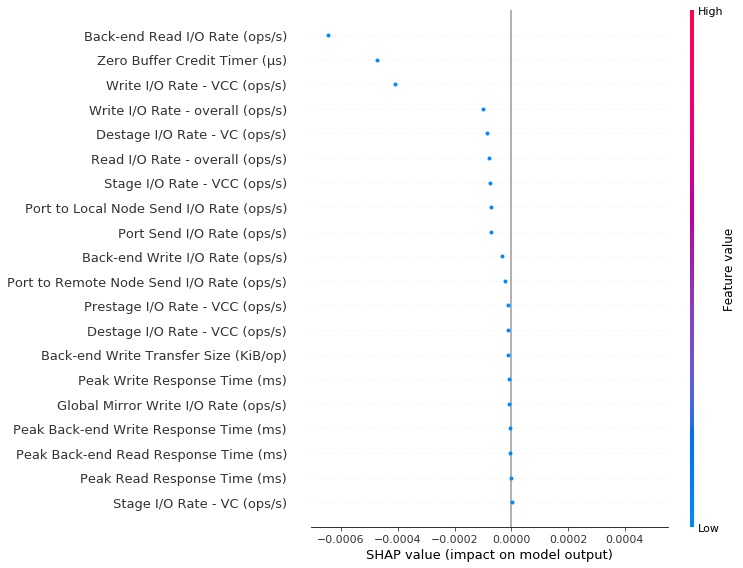

Cluster 1
10 samples in cluster 1
[31, 43, 66, 71, 73, 75, 77, 79, 81, 82]
(10, 84)
[5.93665687e-03 1.02352950e-03 2.86636166e-07 2.92462719e-07
 1.13735380e-02 6.02098871e-02 1.35381783e-01 6.72139508e-02
 4.62974698e-02 1.44058037e-02 7.99657640e-03 2.18012572e-06
 4.93905621e-04 5.30845763e-04 8.45185731e-03 4.84225504e-04
 1.02470081e-02 9.71790480e-03 7.38612536e-02 7.28005772e-03
 3.89927298e-03 0.00000000e+00 9.20051623e-03 9.20024668e-03
 0.00000000e+00 2.73484730e-02 3.73125338e-02 2.57999976e-04
 4.07647526e-04 1.82230390e-04 2.05388466e-05 1.77070048e-09
 2.98996087e-06 1.46583958e-01 3.08956364e-06 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.41643878e-02 1.47899154e-02
 0.00000000e+00 1.75296968e-03 5.30647303e-02 3.06880808e-02
 2.53046379e-02 3.42847362e-09 2.13571183e-08 7.24660460e-05
 5.30920834e-05 6.88491566e-03 1.42600491e-03 4.83115427e-07
 1.31636011e-07 1.15719110e-07 0.00000000e+00 1.80977527e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.03322821e-01
 

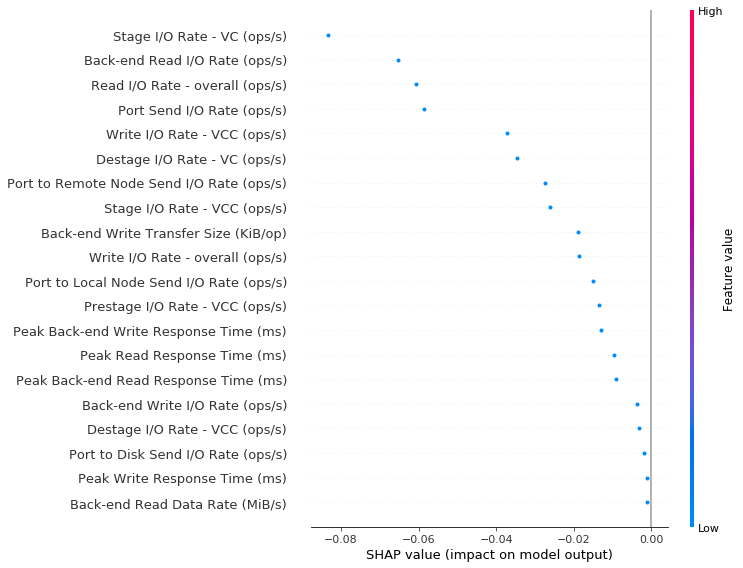

In [31]:
for i in set(cluster_labels):
    print("Cluster", i)
    cluster_indices = get_anomaly_cluster_association(cluster_labels, i)
    print(cluster_indices)
    
    cluster_shap_values = get_data_per_cluster(cluster_indices, shap_values_allTimesteps)
    cluster_sample_values = get_data_per_cluster(cluster_indices, samples_allTimesteps)
    
    print(cluster_shap_values.shape)
    #print(cluster_shap_values)
    #print(cluster_sample_values.shape)
    #print(cluster_sample_values)
    
    average_cluster_shap_values = cluster_shap_values.mean(axis=0)
    average_cluster_sample_values = cluster_sample_values.mean(axis=0)
    
    #print("--------------------------------------------------------------------")
    
    #print(average_cluster_shap_values)
    print(average_cluster_sample_values)
    

    average_cluster_shap_values = average_cluster_shap_values.reshape(1,average_cluster_shap_values.shape[0])
    average_cluster_sample_values = average_cluster_sample_values.reshape(1,average_cluster_sample_values.shape[0])
    
    #print("--------------------------------------------------------------------")
    #print(average_cluster_shap_values)
    
    print(average_cluster_shap_values.shape)
    print(average_cluster_sample_values.shape)
    
    shap.summary_plot(average_cluster_shap_values, average_cluster_sample_values, feature_names=features_order_in_data, max_display=20)

# Shap Values Plot all Samples

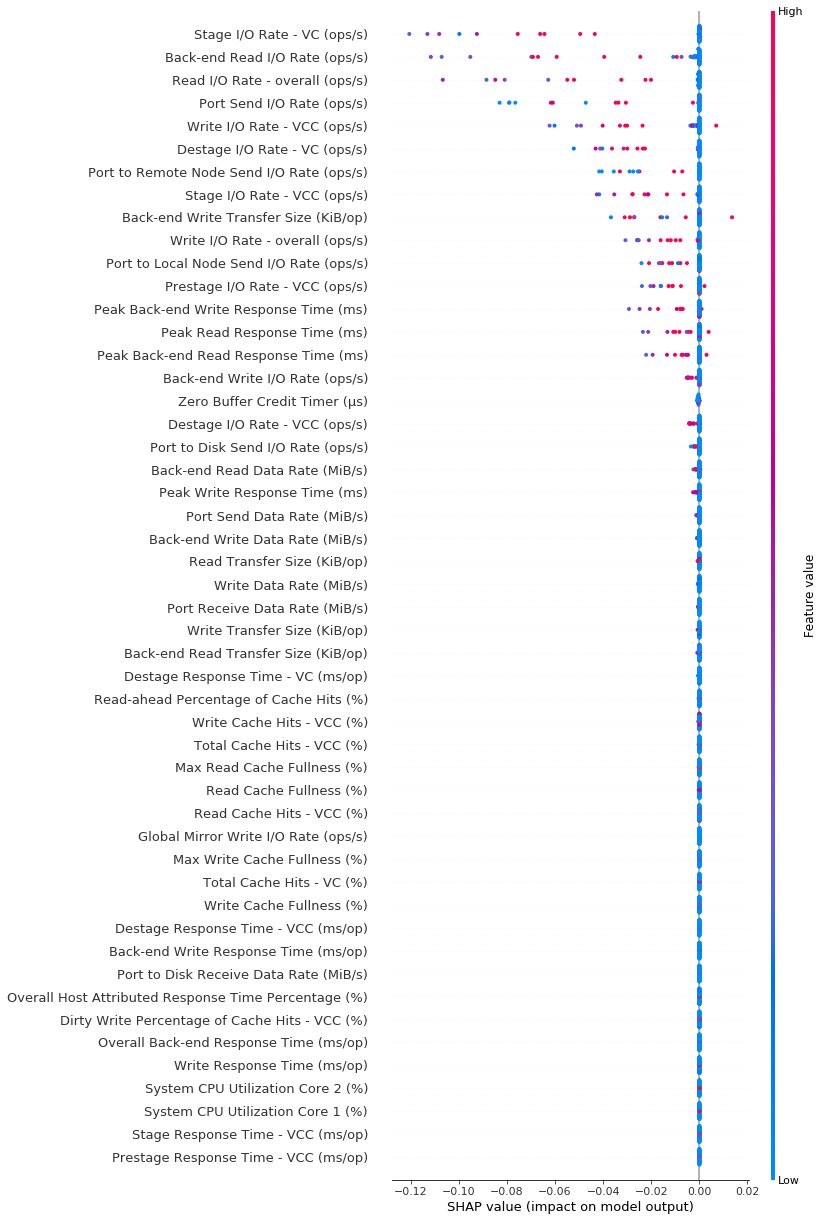

In [32]:
shap.summary_plot(shap_values_allTimesteps, samples_allTimesteps, max_display=50, feature_names=features_order_in_data)

# Actionability vs Non-actionability

### Actionability: Response time metrics are higher in the feature importance
### Non-actionability: I/O rate higher in the feature importance

### Summary Plots

#### Cluster 1

In [33]:
cluster_indices = get_anomaly_cluster_association(cluster_labels, 1)
cluster_indices

10 samples in cluster 1


[31, 43, 66, 71, 73, 75, 77, 79, 81, 82]

Sample: 31


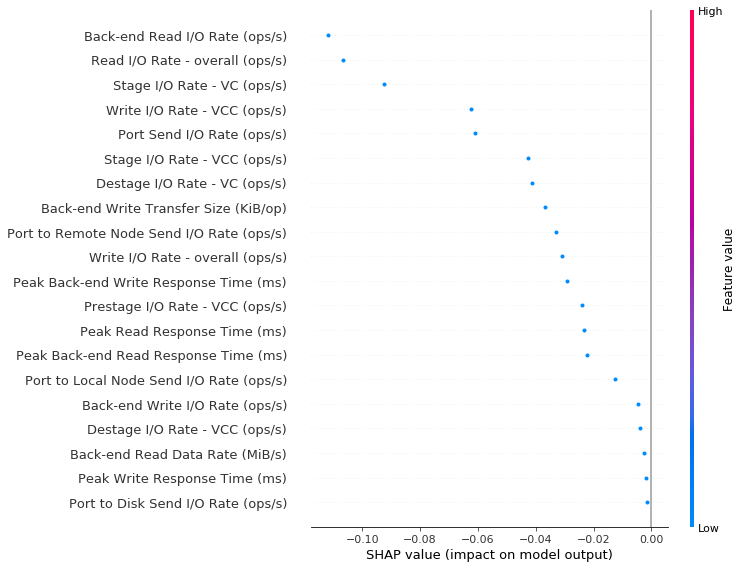

Sample: 43


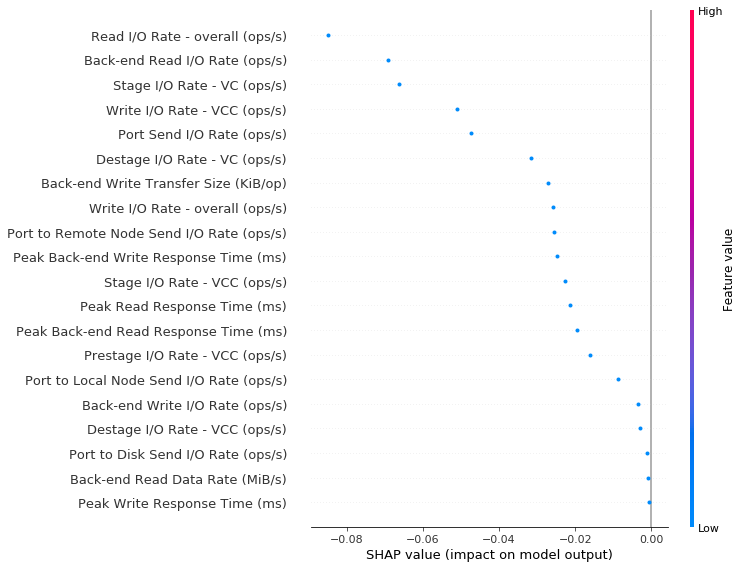

Sample: 66


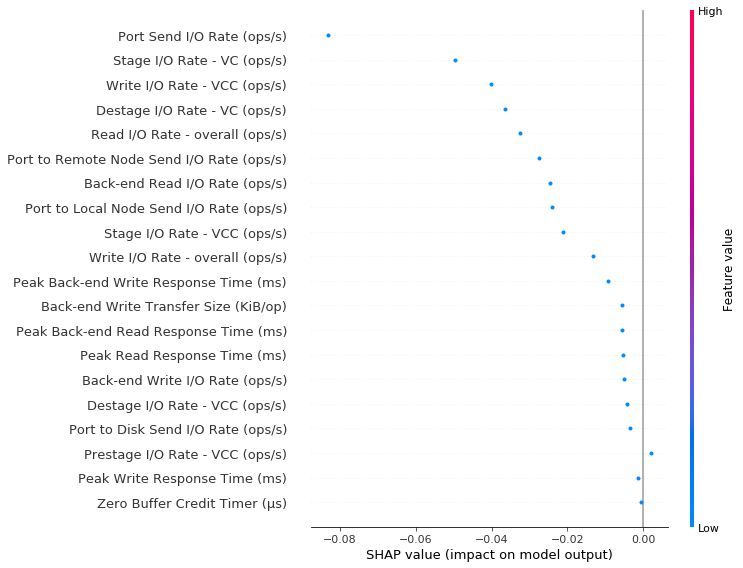

Sample: 71


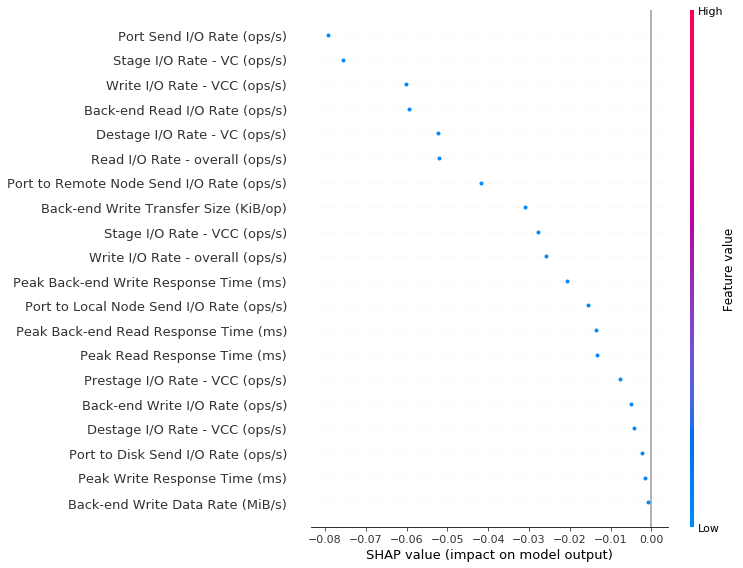

Sample: 73


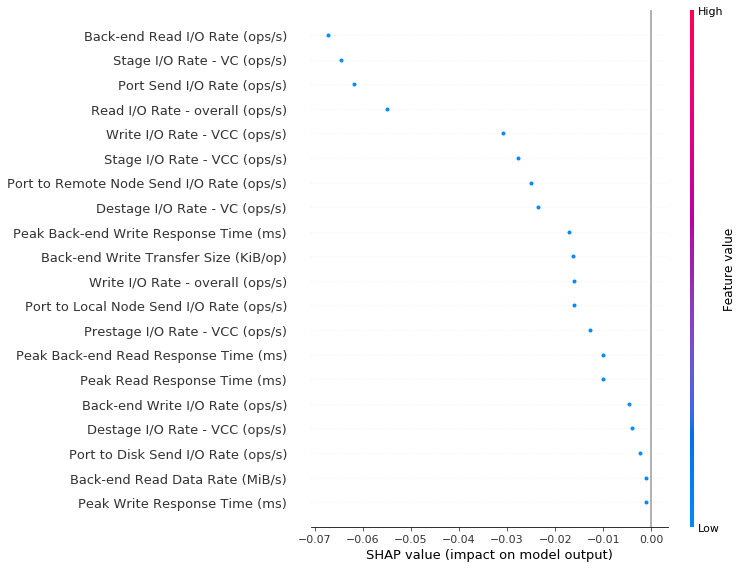

Sample: 75


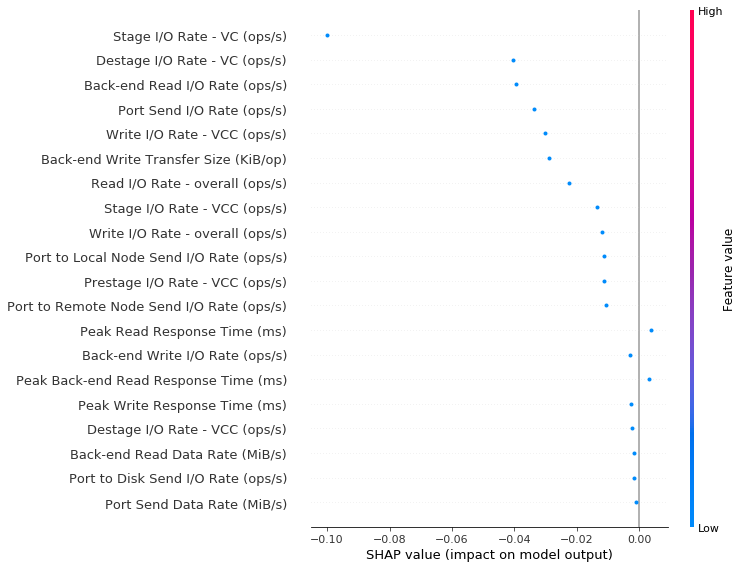

Sample: 77


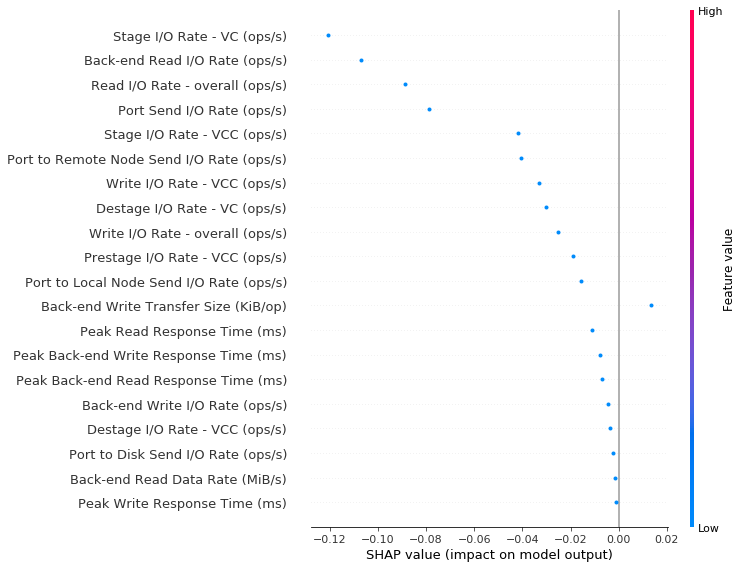

Sample: 79


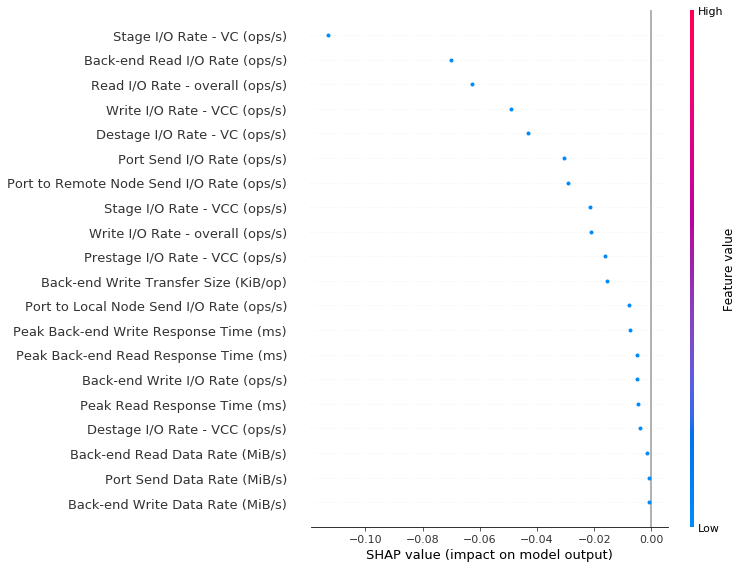

Sample: 81


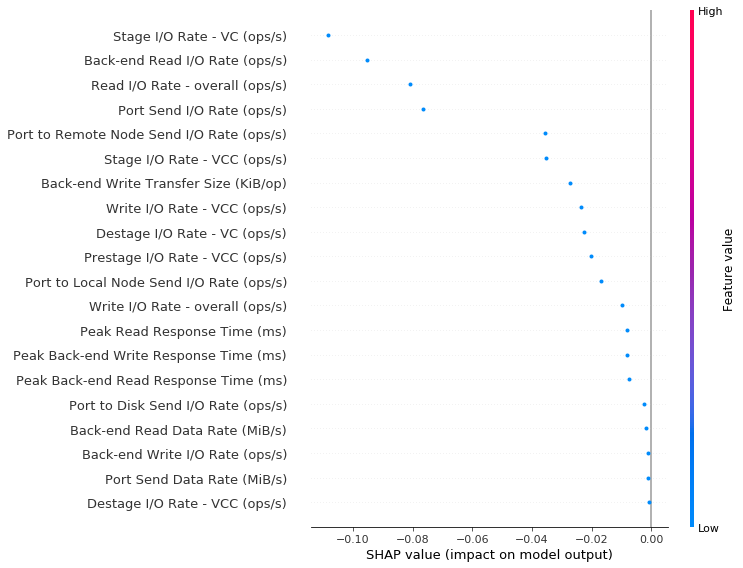

Sample: 82


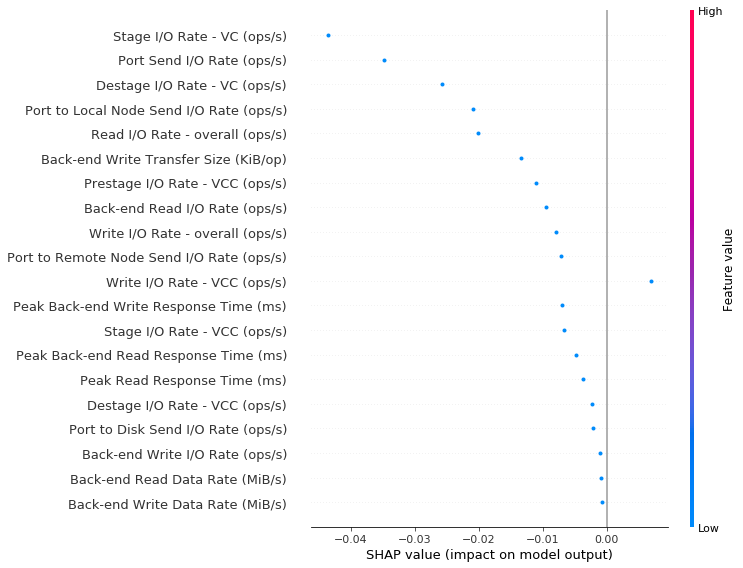

In [34]:
get_plots_per_sample_within_cluster(cluster_indices, shap_values_allTimesteps, samples_allTimesteps, features_order_in_data)

#### Cluster 0

In [35]:
cluster_indices = get_anomaly_cluster_association(cluster_labels, 0)

73 samples in cluster 0


Sample: 0


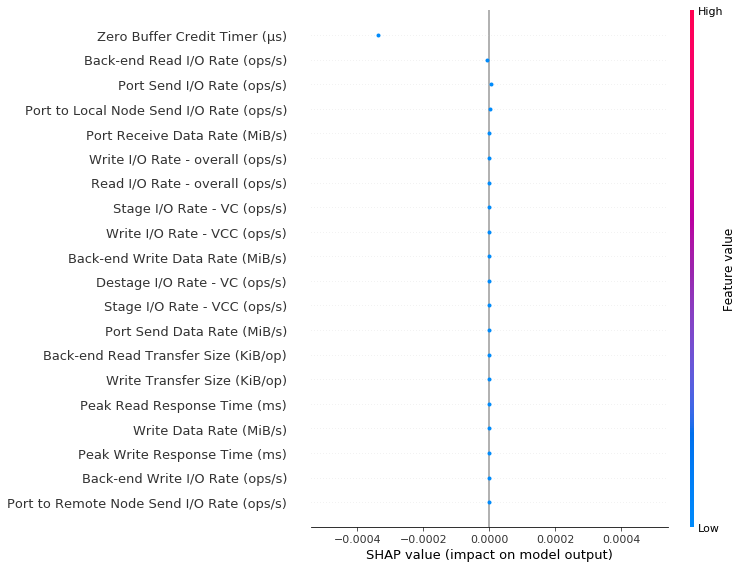

Sample: 1


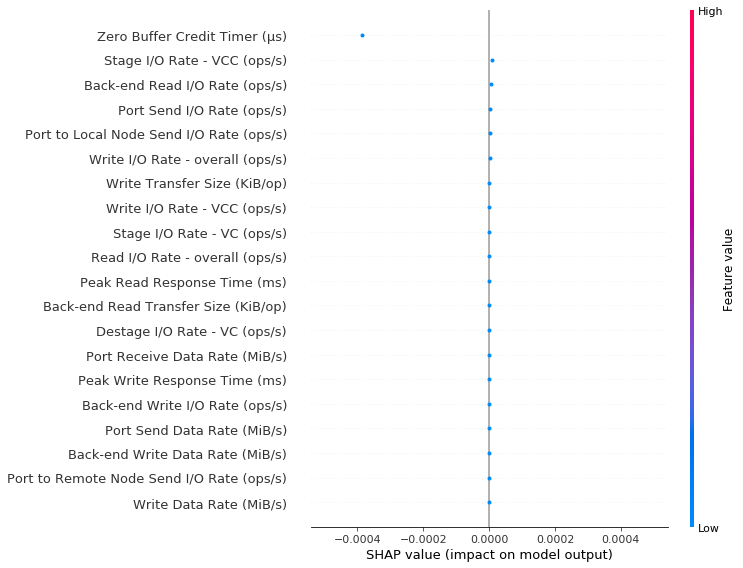

Sample: 2


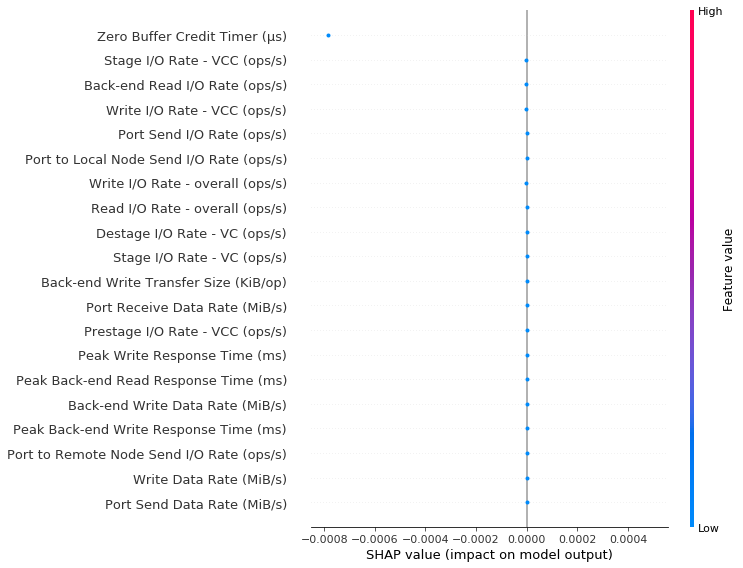

Sample: 3


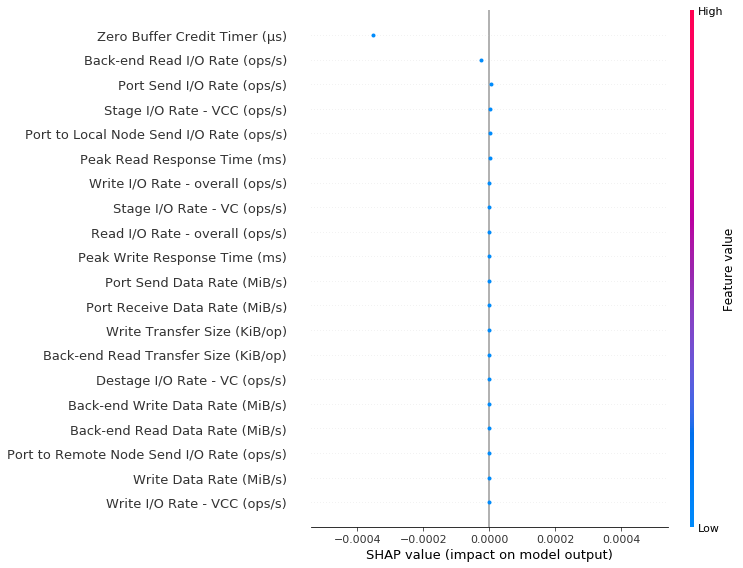

Sample: 4


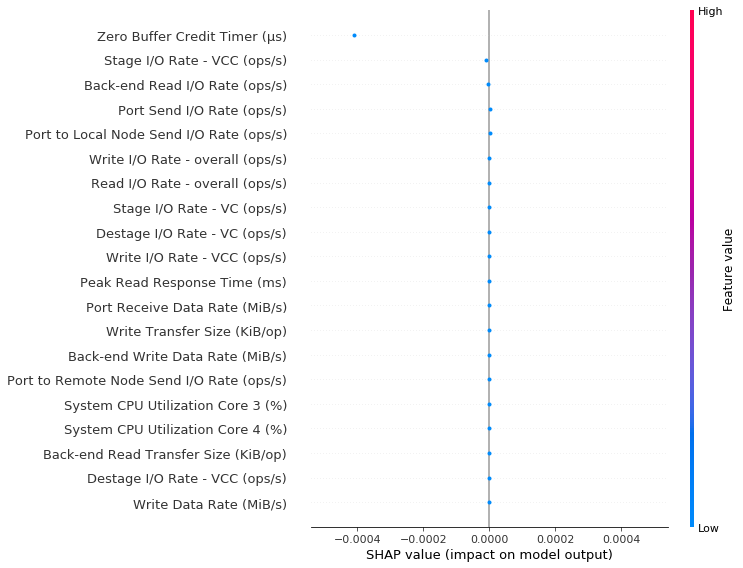

Sample: 5


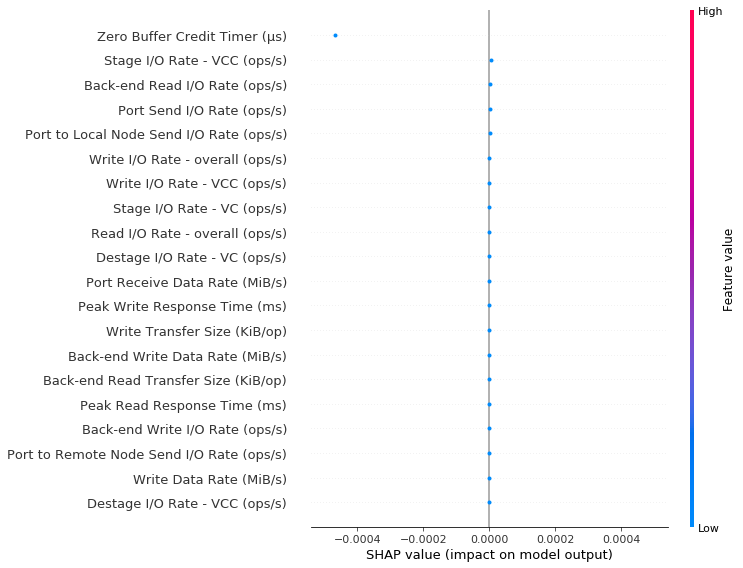

Sample: 6


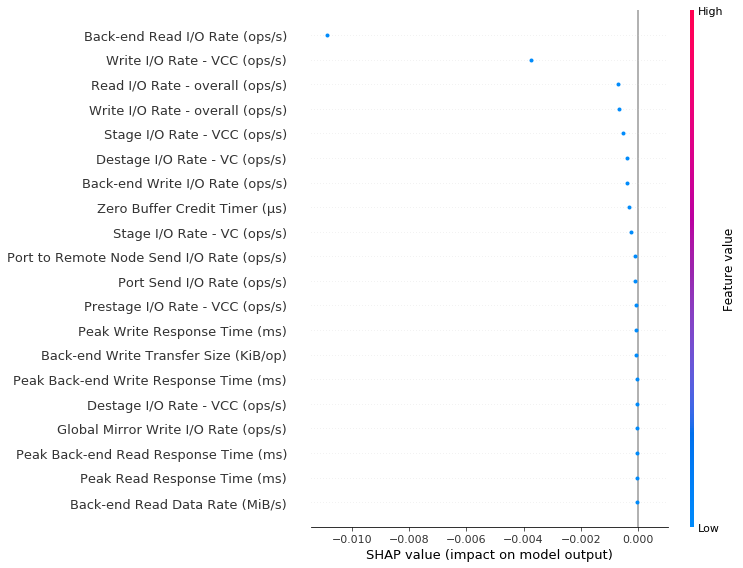

Sample: 7


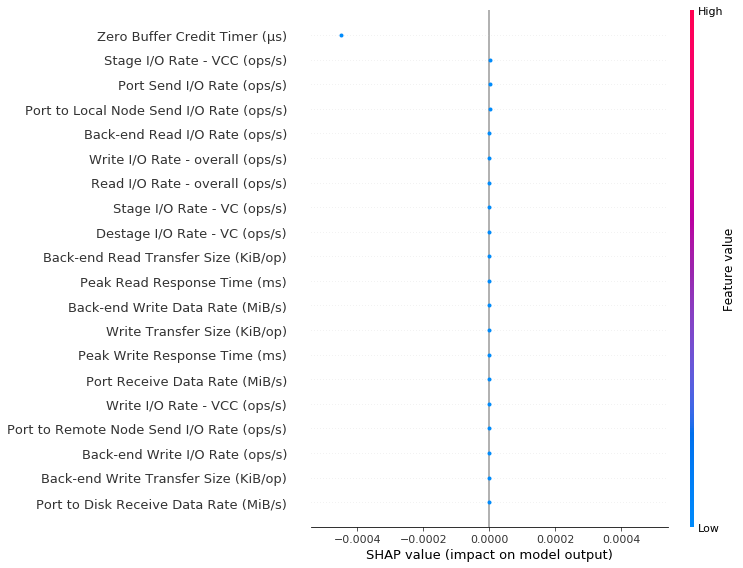

Sample: 8


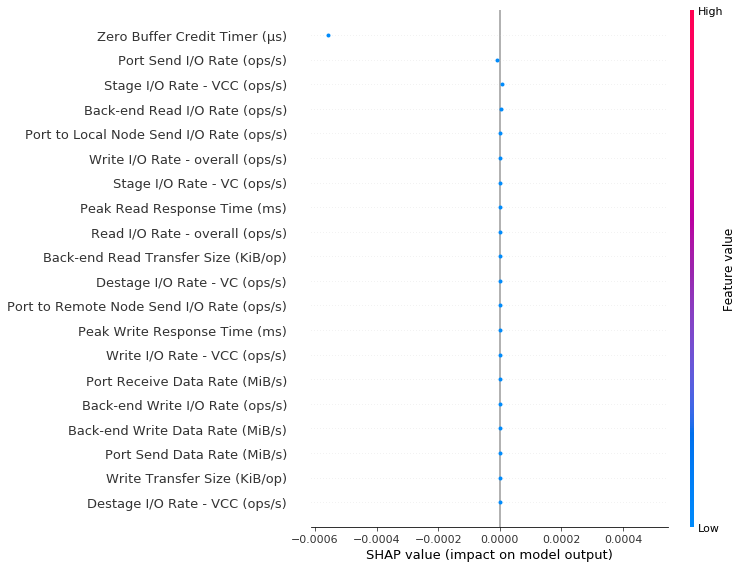

Sample: 9


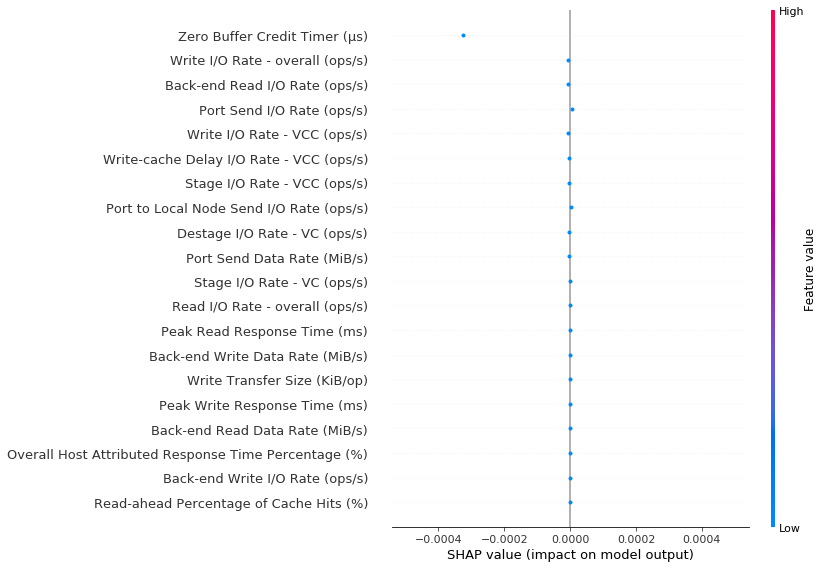

Sample: 10


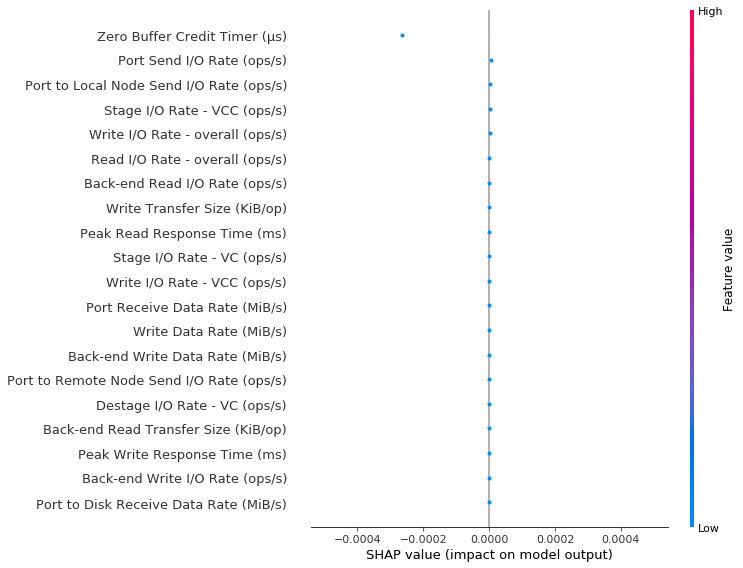

Sample: 11


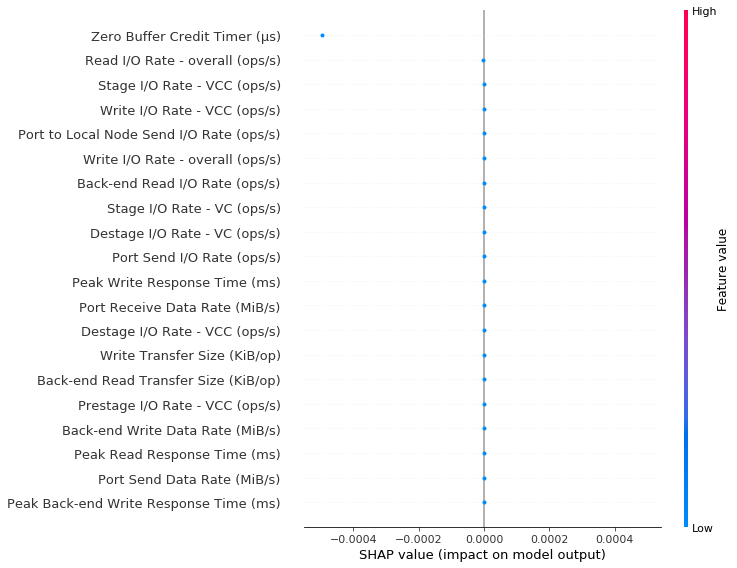

Sample: 12


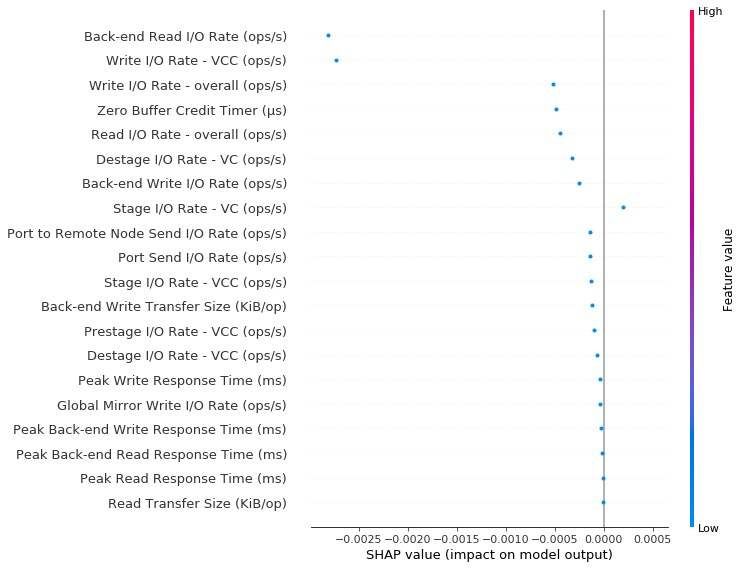

Sample: 13


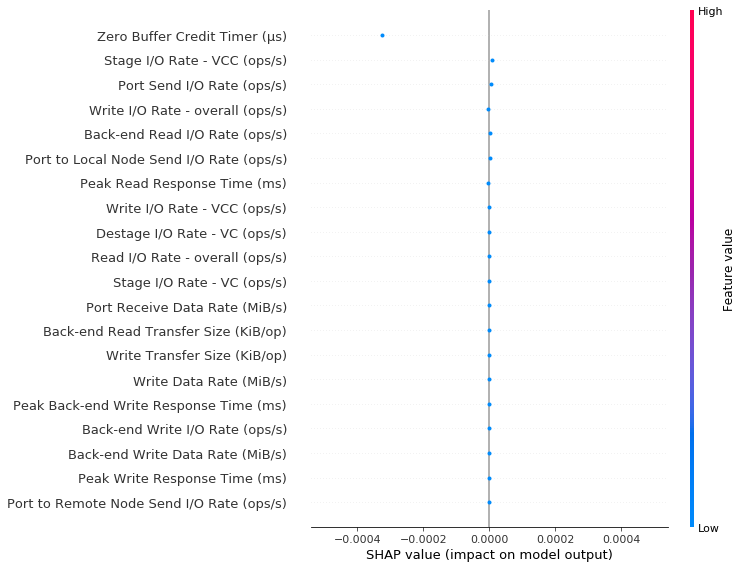

Sample: 14


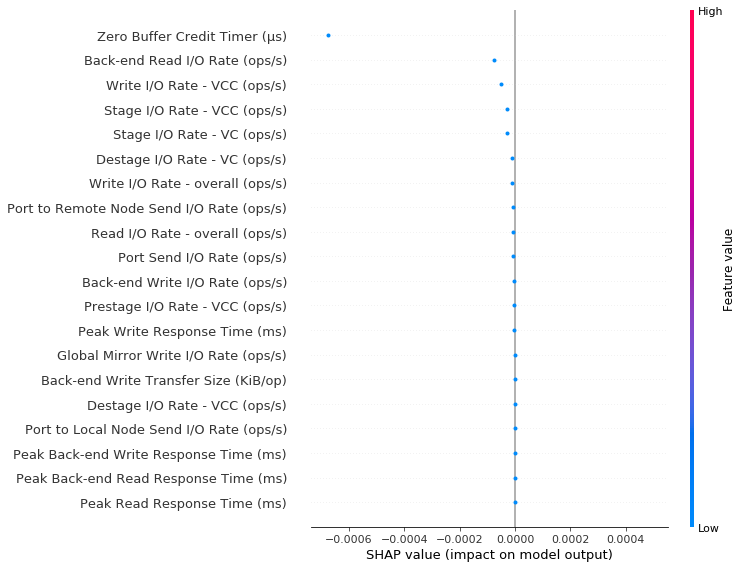

Sample: 15


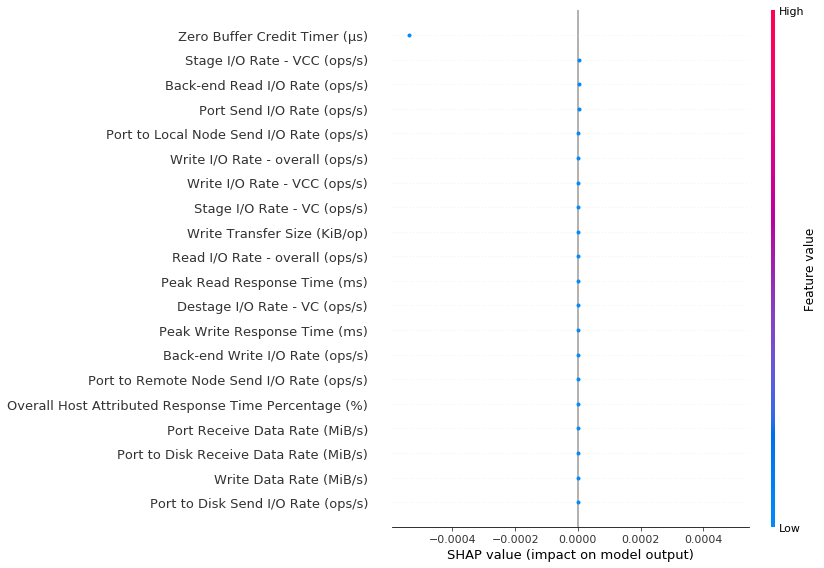

Sample: 16


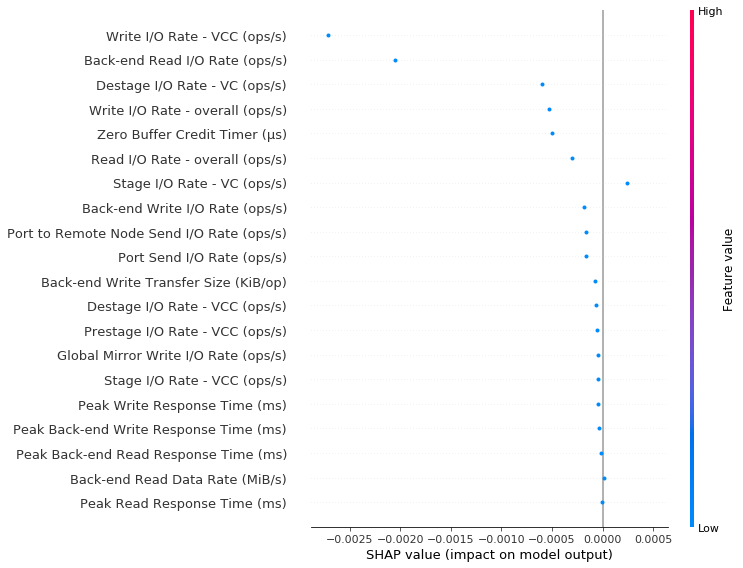

Sample: 17


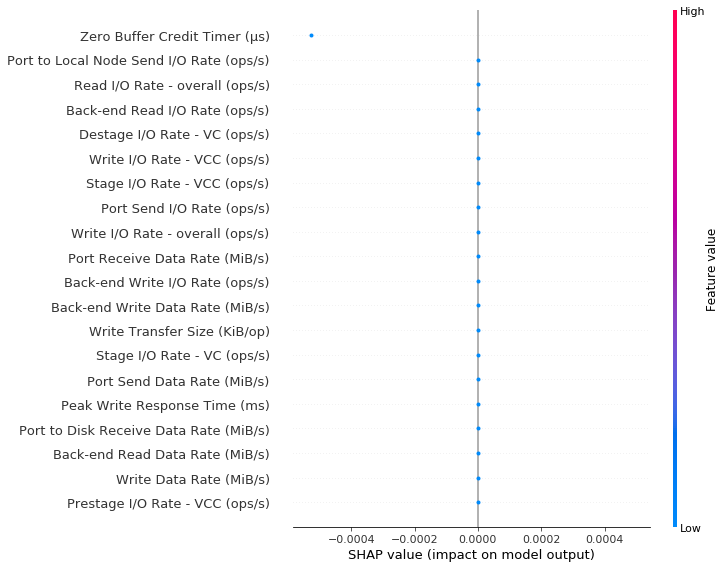

Sample: 18


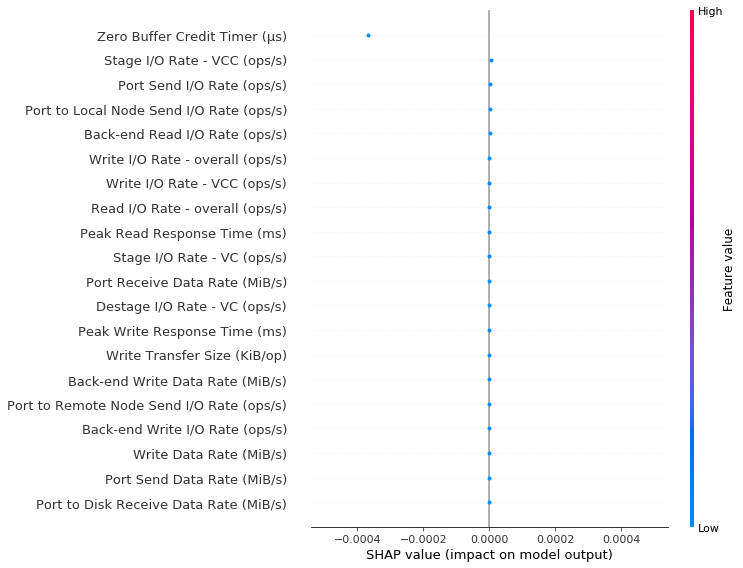

Sample: 19


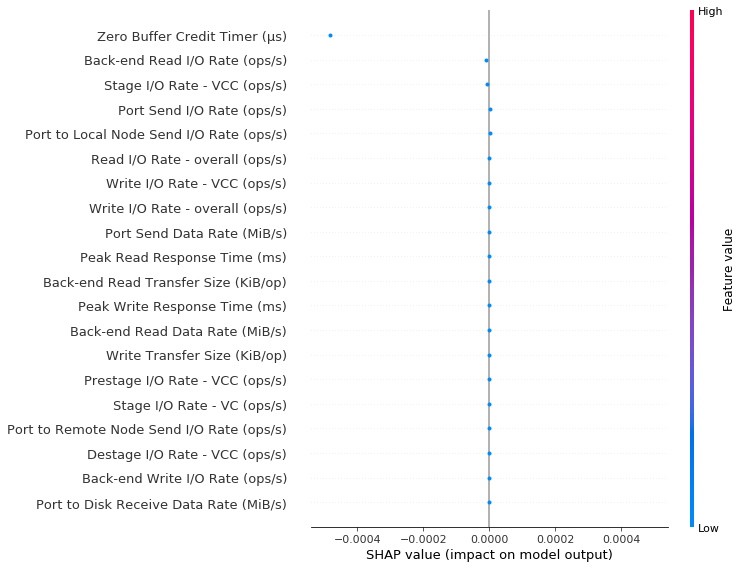

Sample: 20


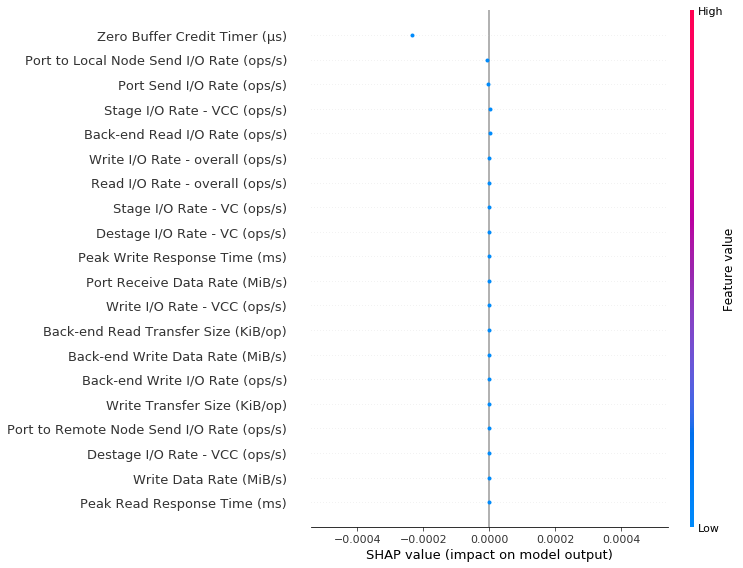

Sample: 21


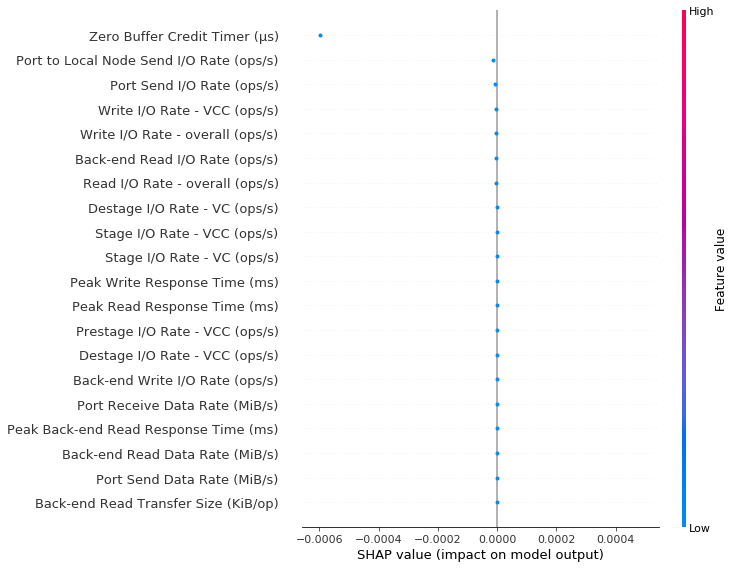

Sample: 22


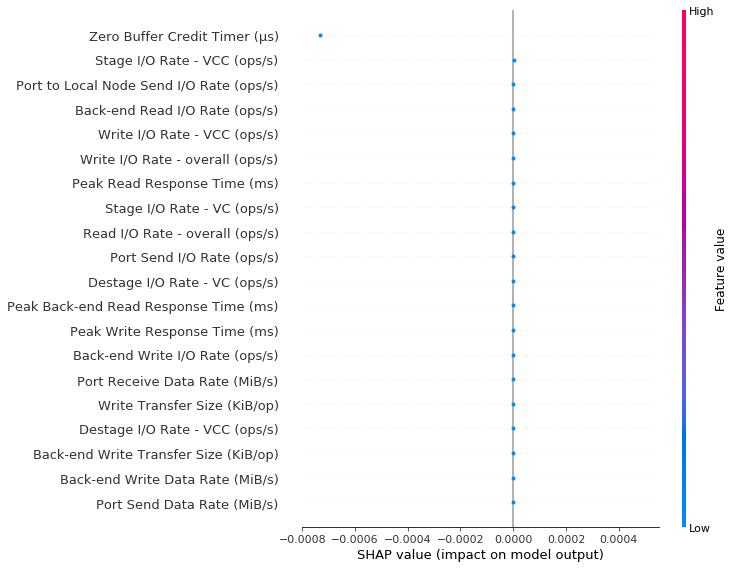

Sample: 23


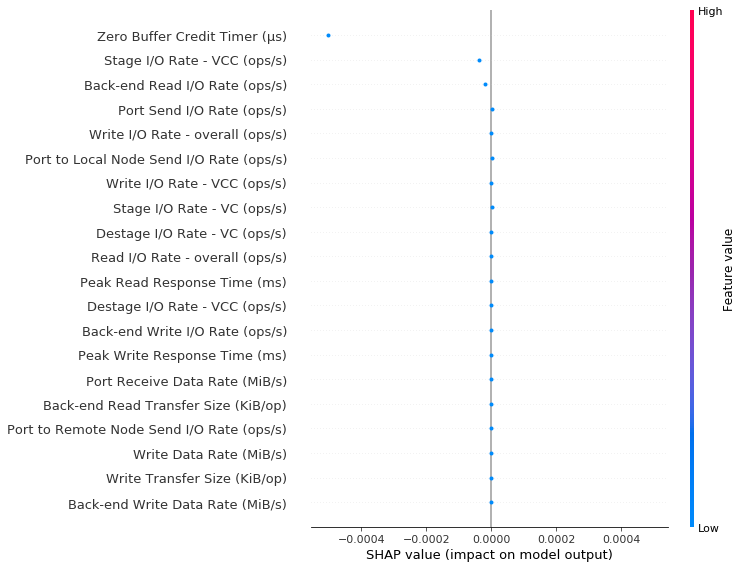

Sample: 24


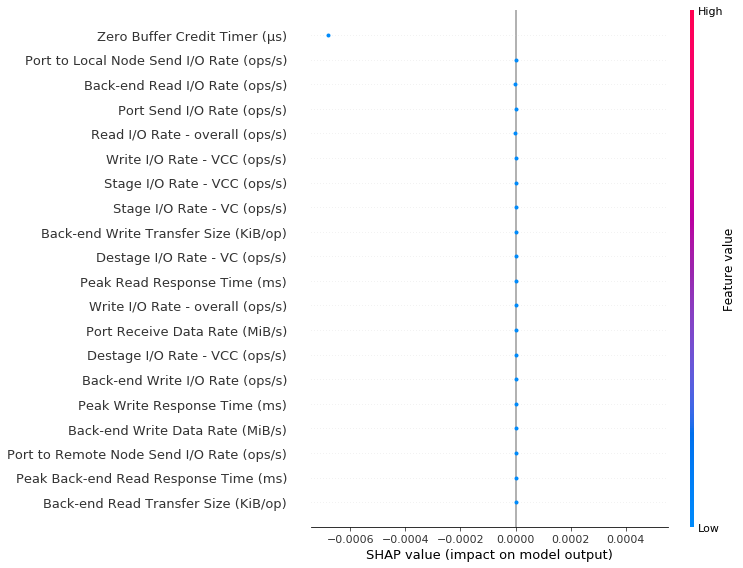

Sample: 25


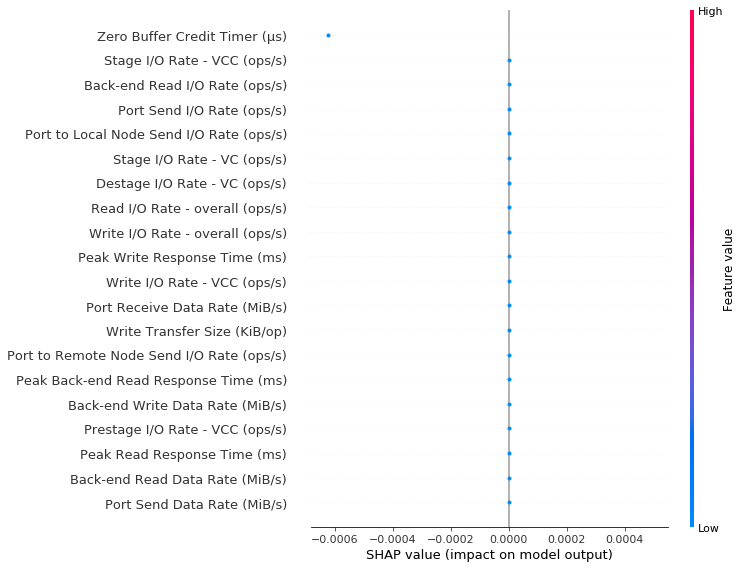

Sample: 26


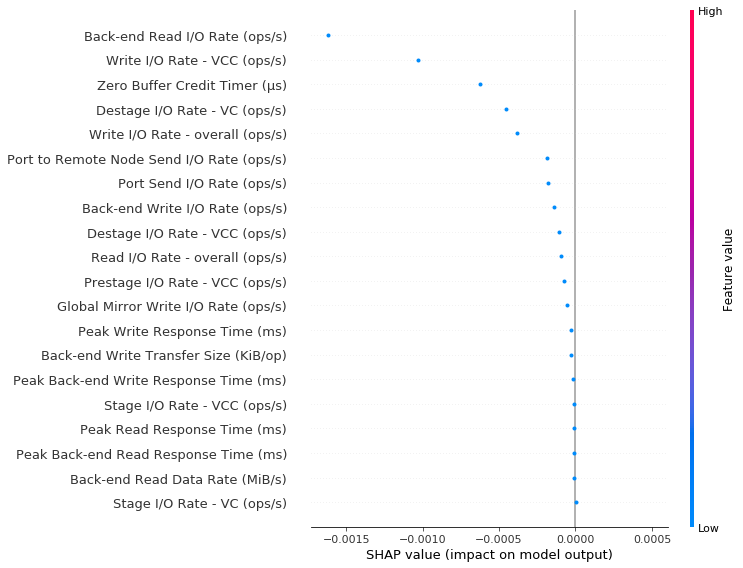

Sample: 27


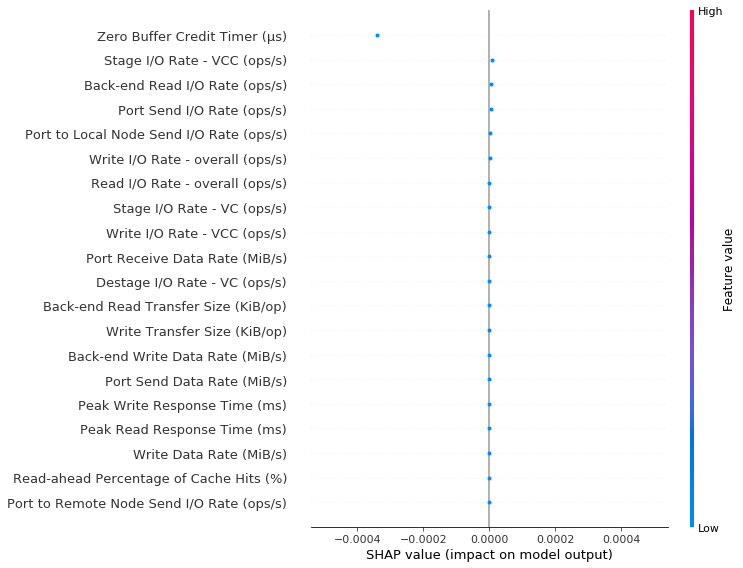

Sample: 28


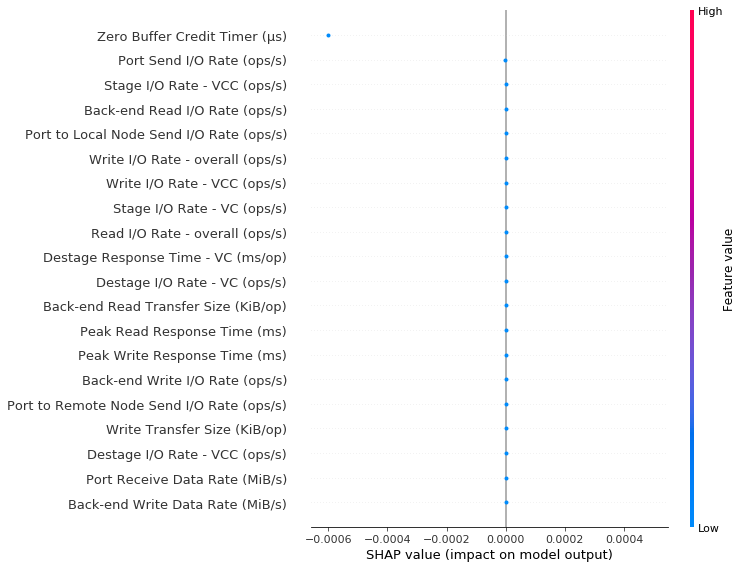

Sample: 29


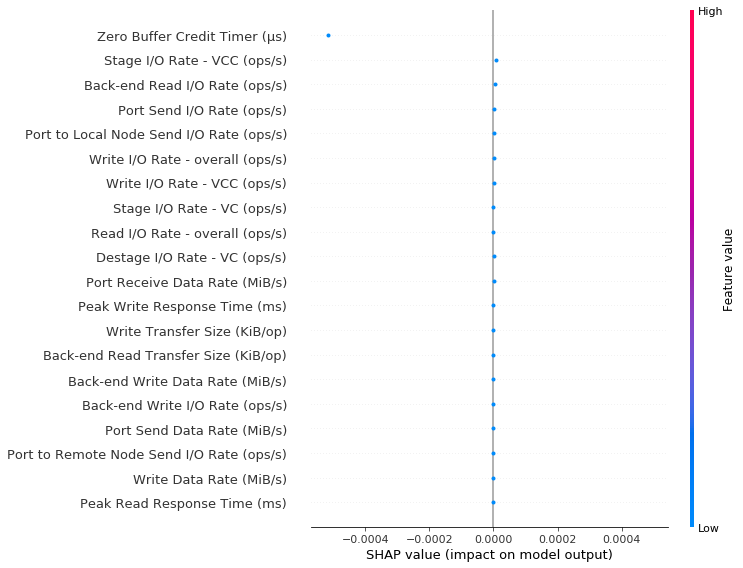

Sample: 30


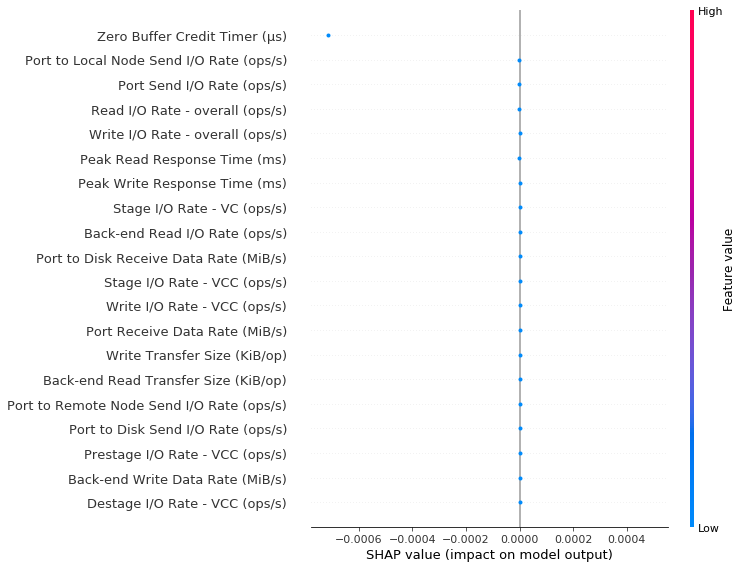

Sample: 32


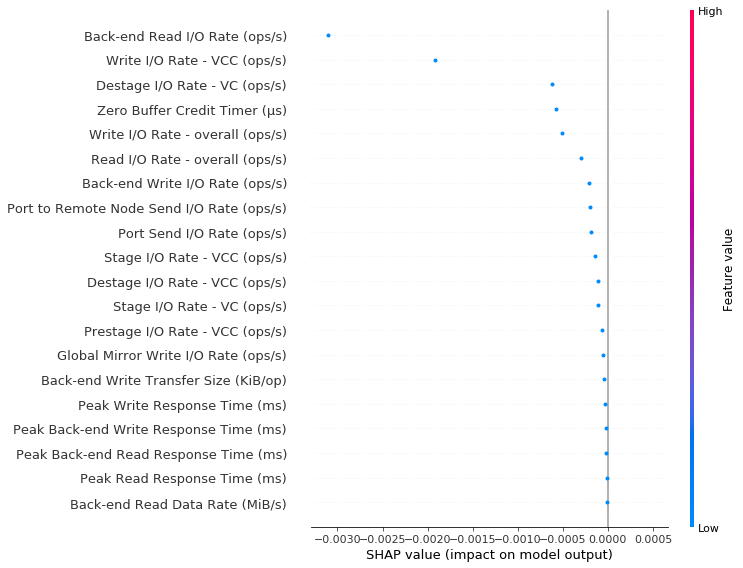

Sample: 33


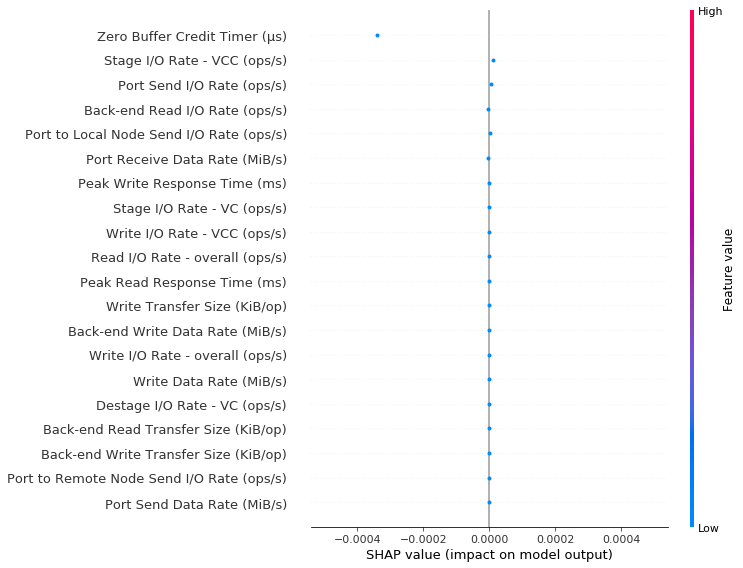

Sample: 34


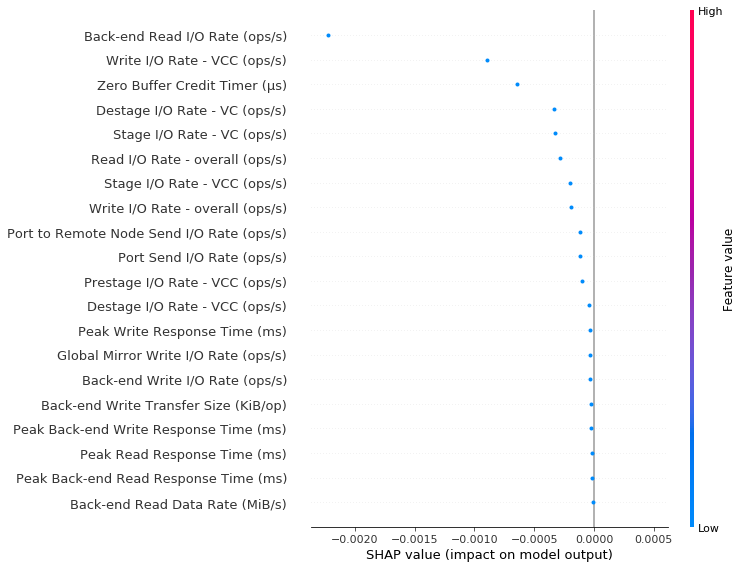

Sample: 35


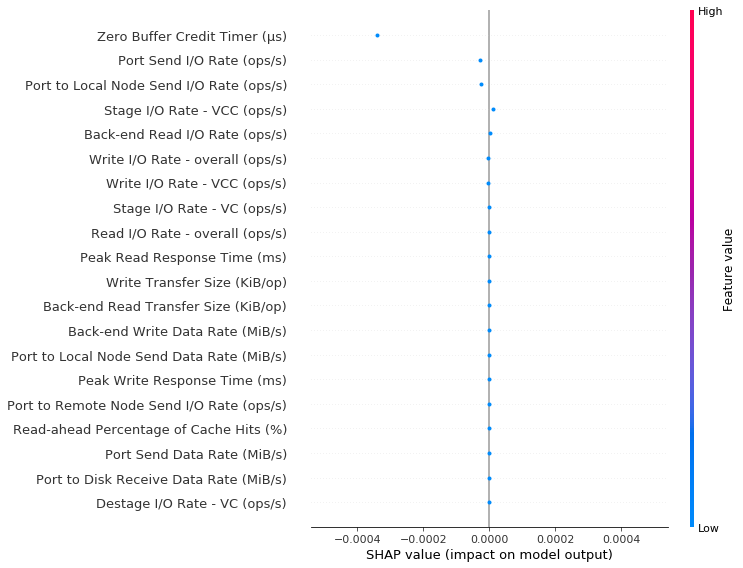

Sample: 36


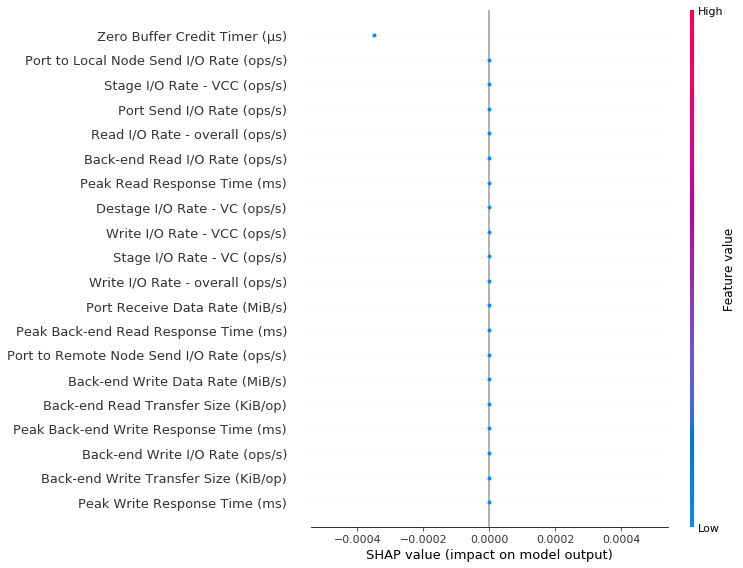

Sample: 37


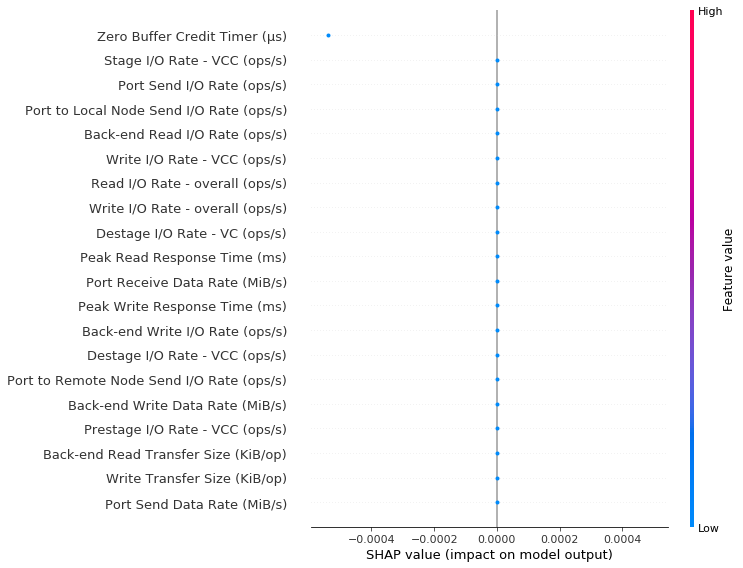

Sample: 38


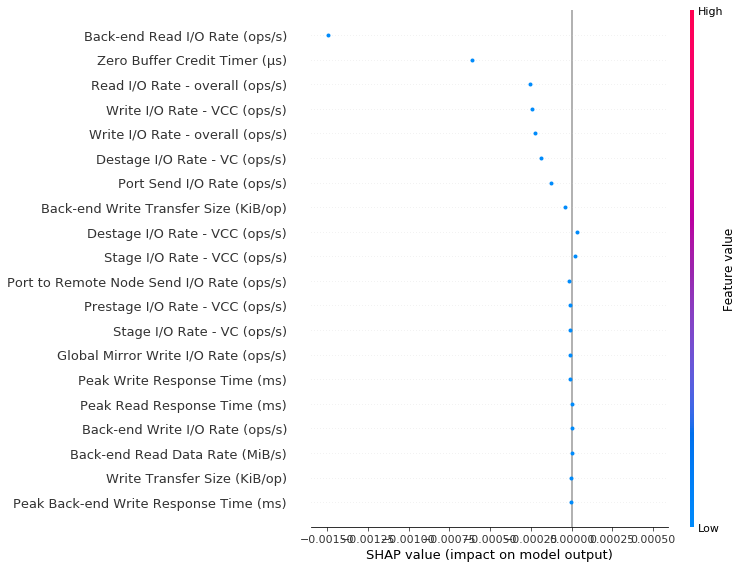

Sample: 39


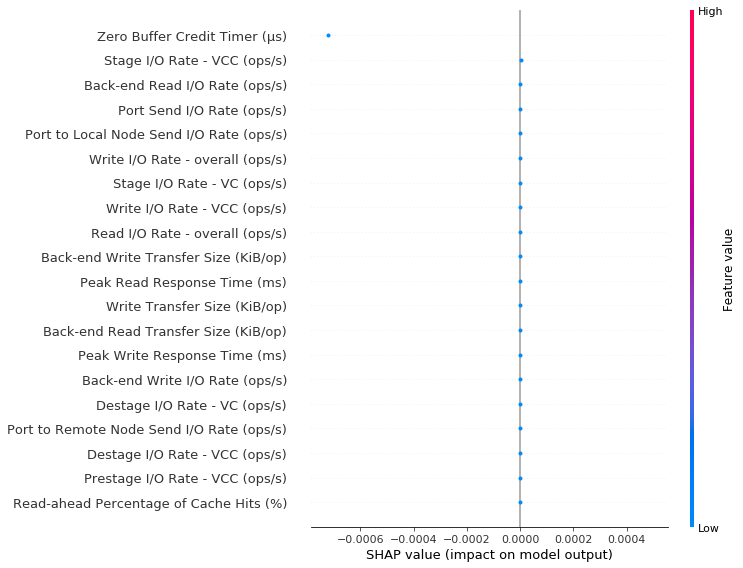

Sample: 40


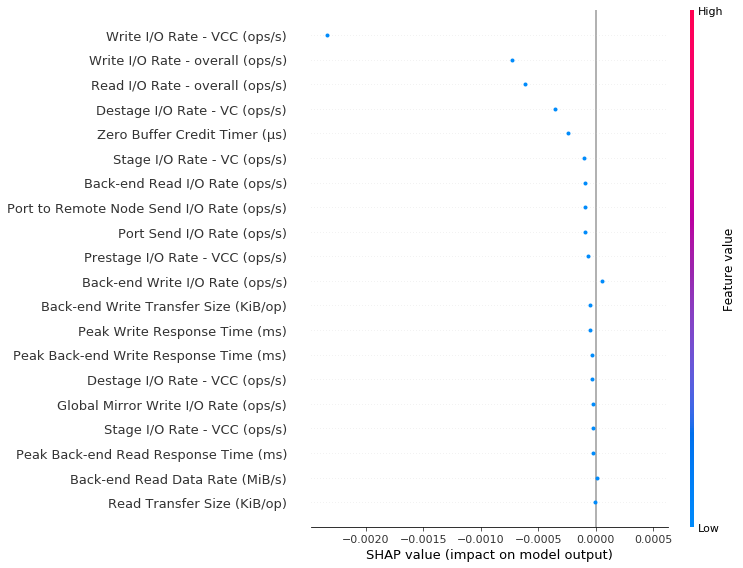

Sample: 41


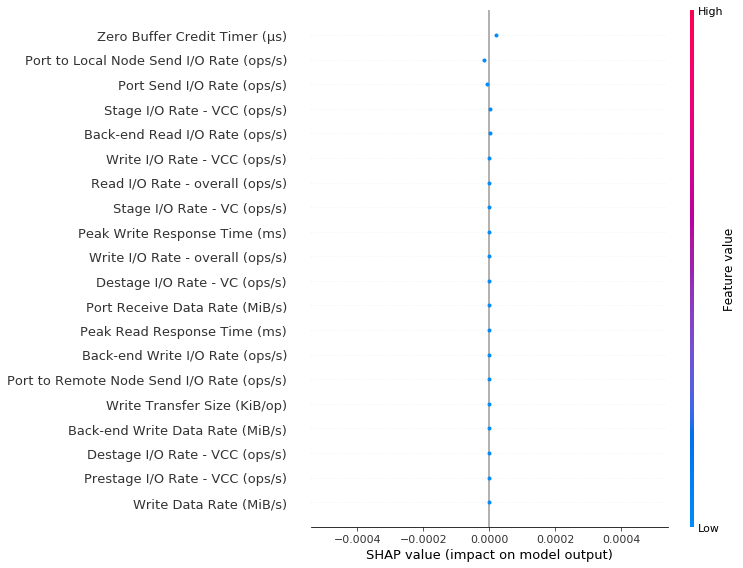

Sample: 42


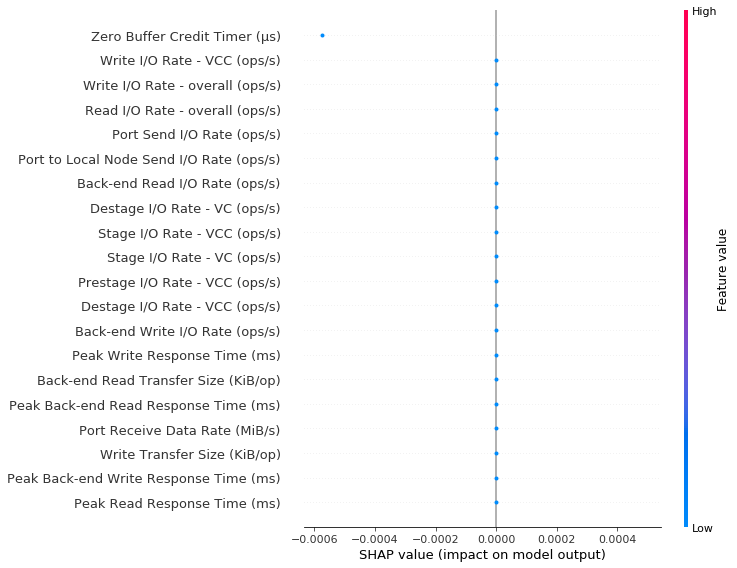

Sample: 44


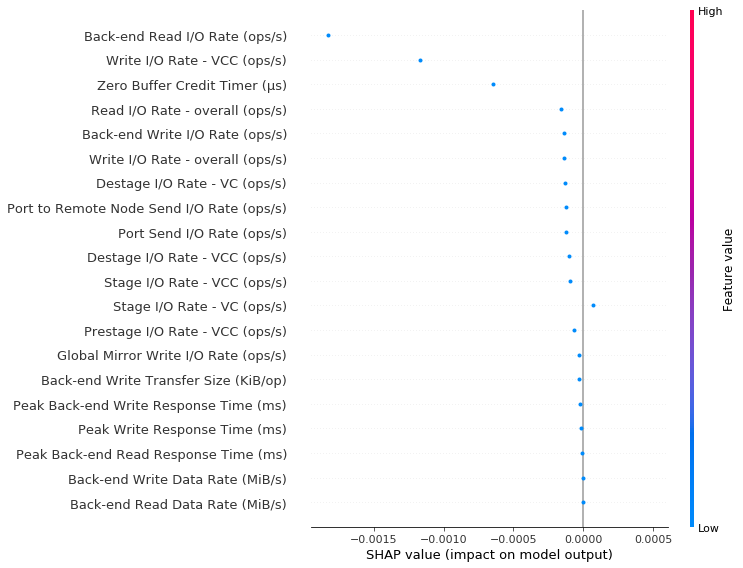

Sample: 45


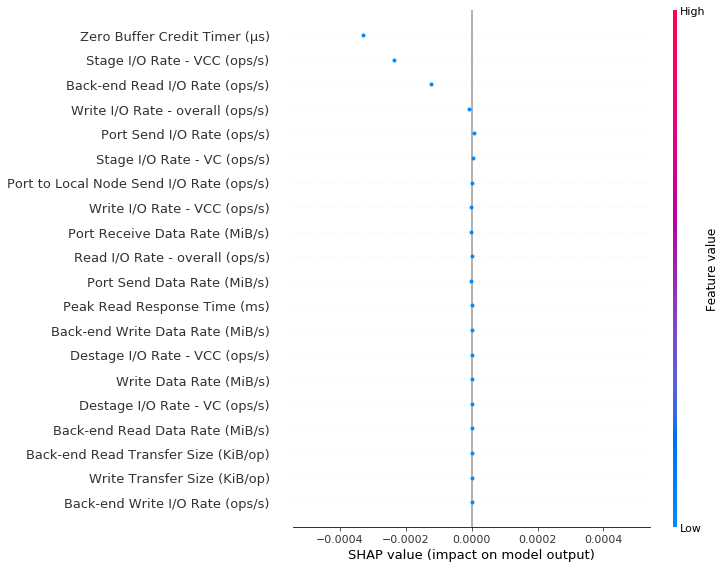

Sample: 46


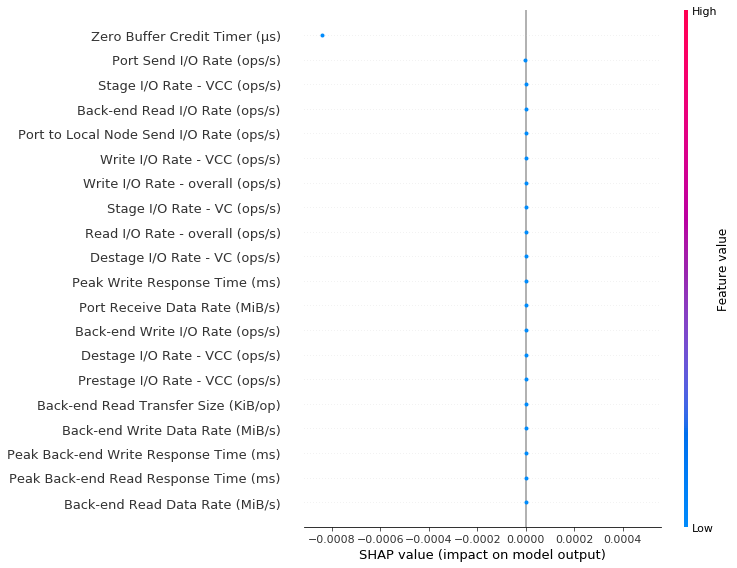

Sample: 47


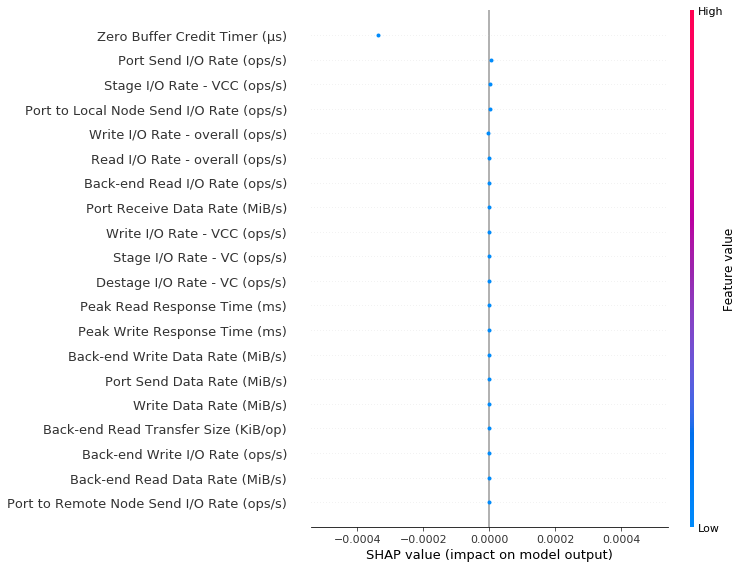

Sample: 48


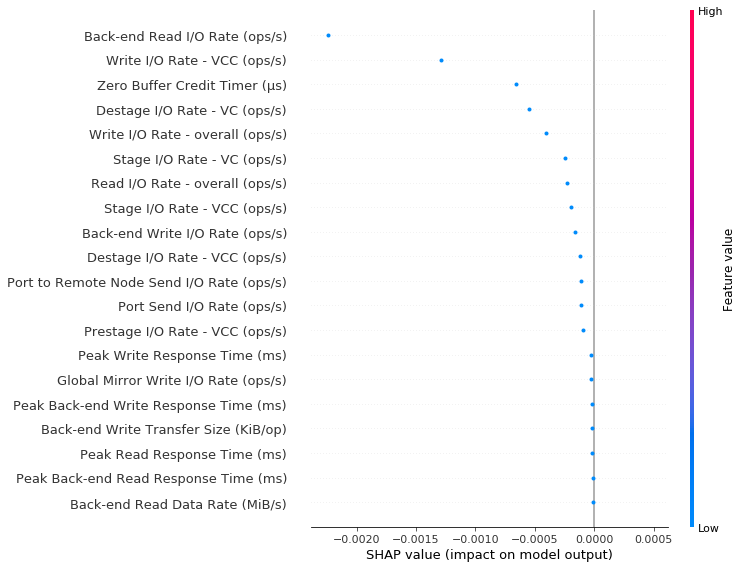

Sample: 49


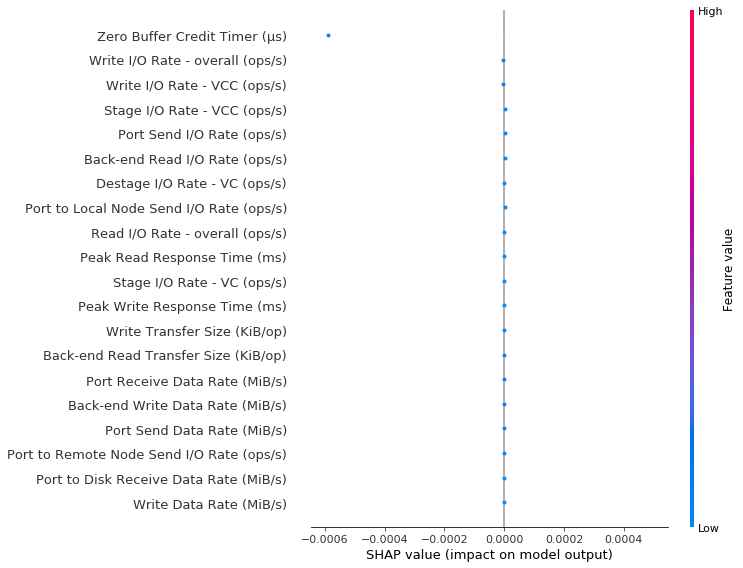

Sample: 50


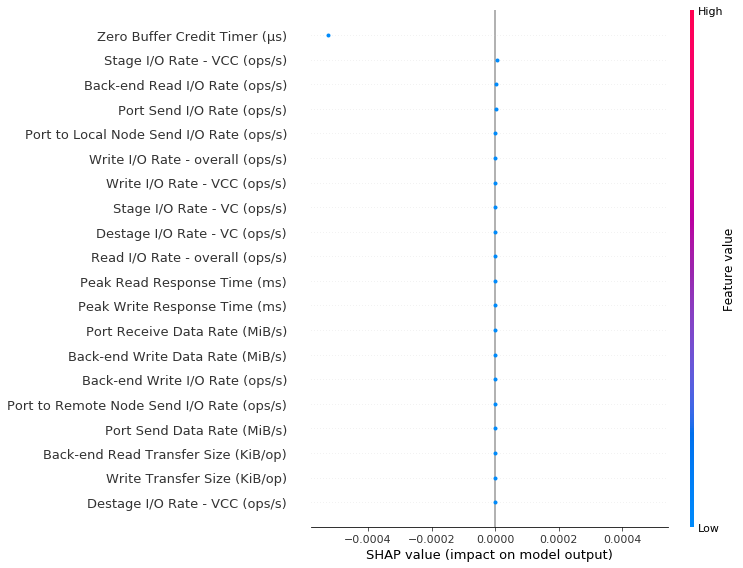

Sample: 51


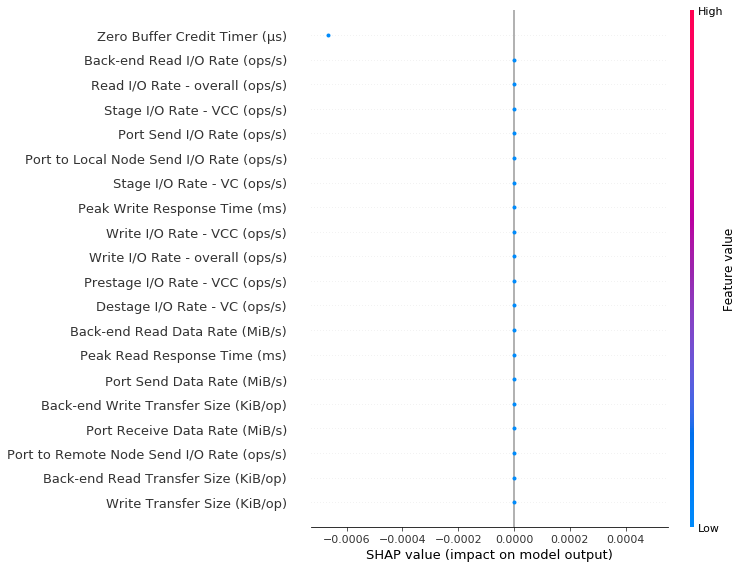

Sample: 52


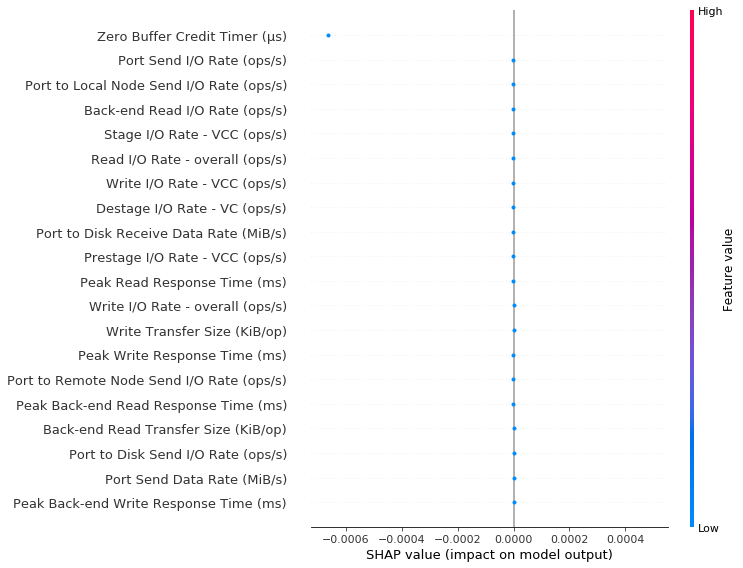

Sample: 53


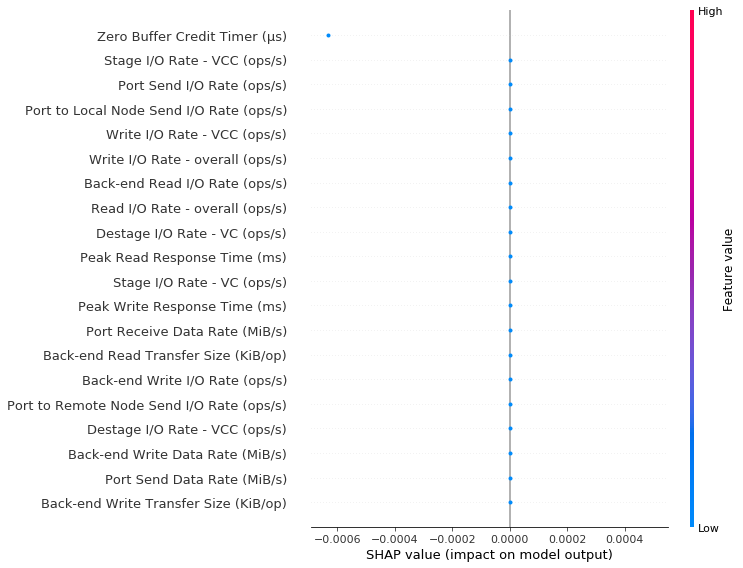

Sample: 54


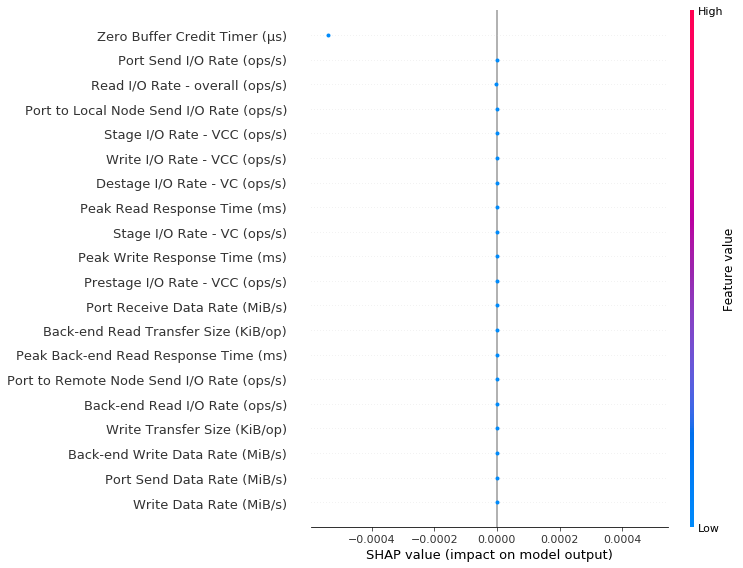

Sample: 55


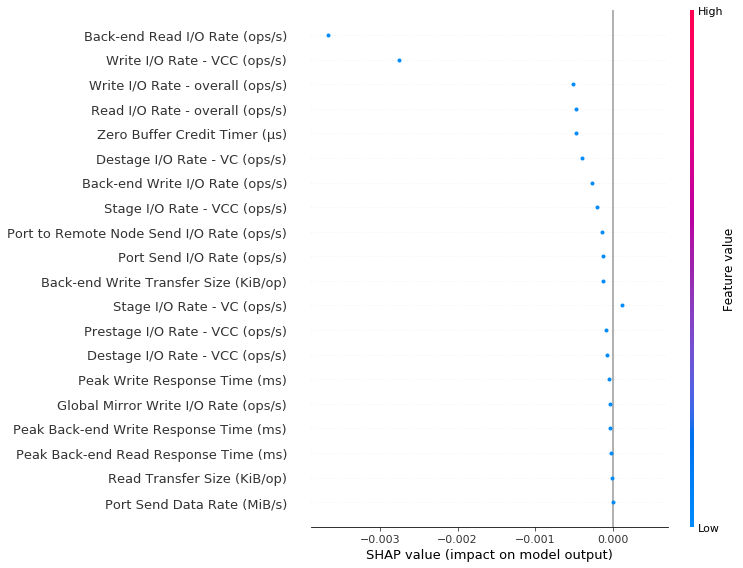

Sample: 56


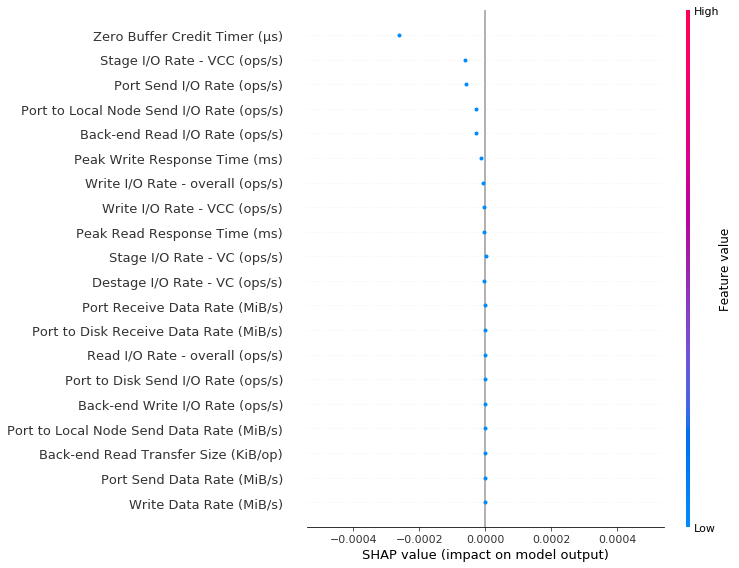

Sample: 57


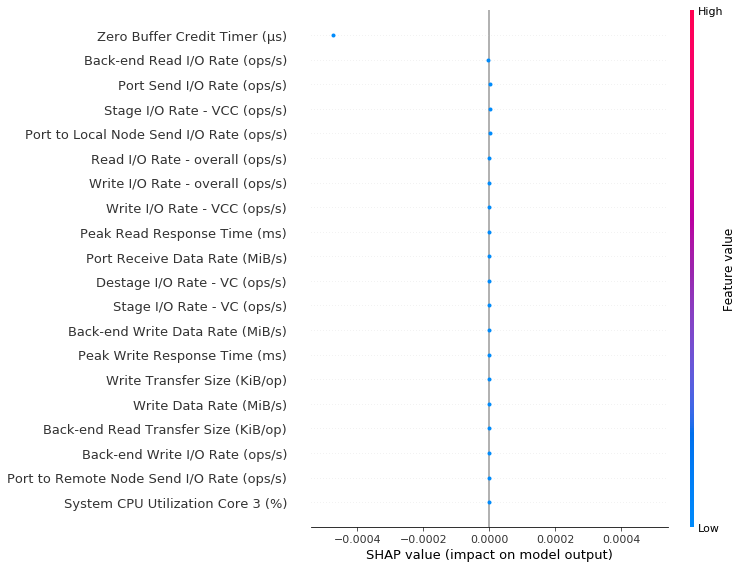

Sample: 58


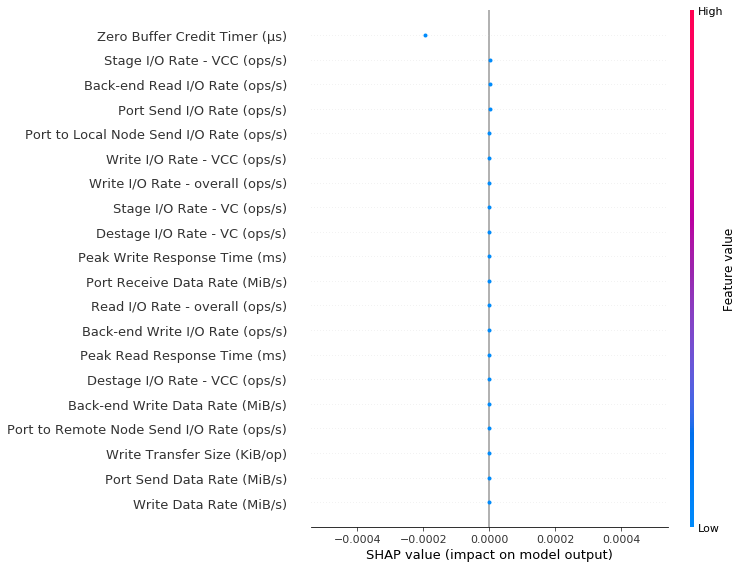

Sample: 59


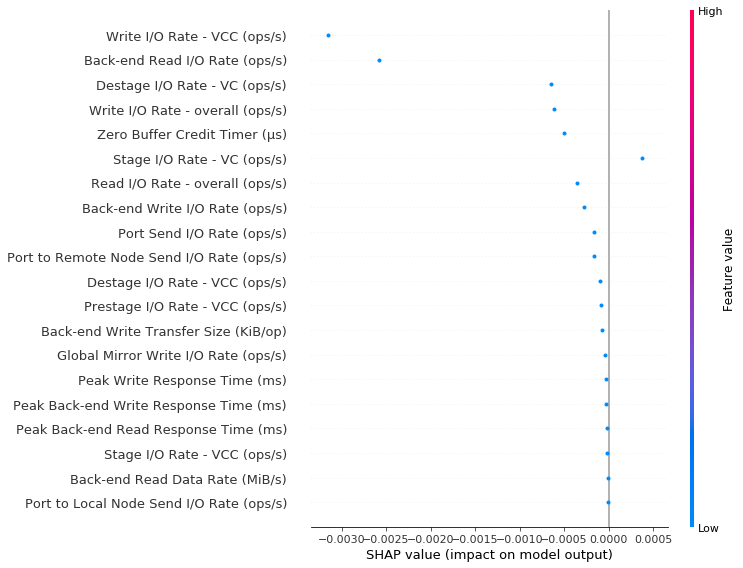

Sample: 60


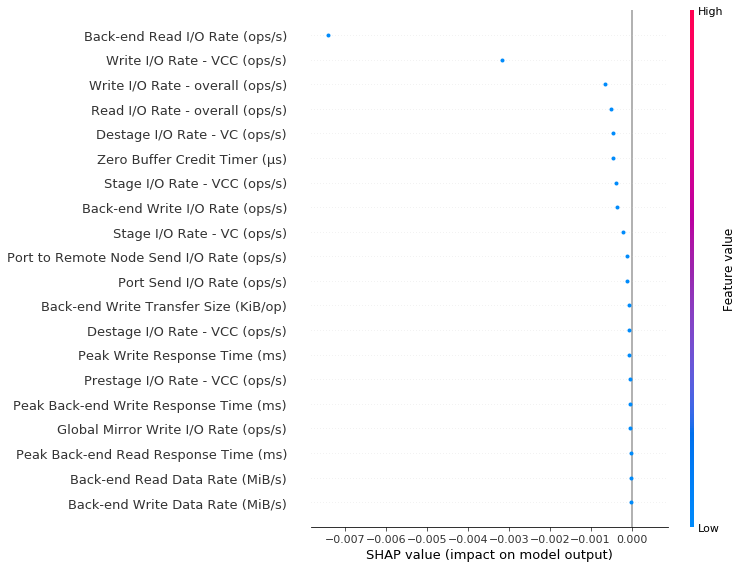

Sample: 61


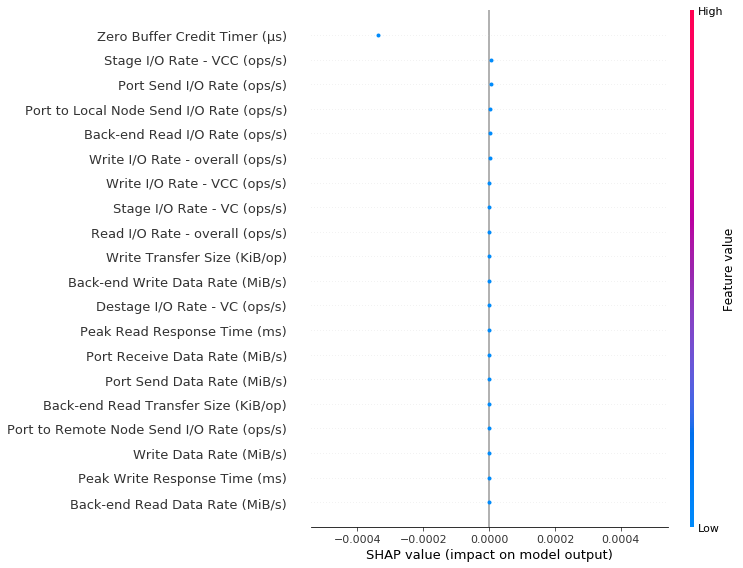

Sample: 62


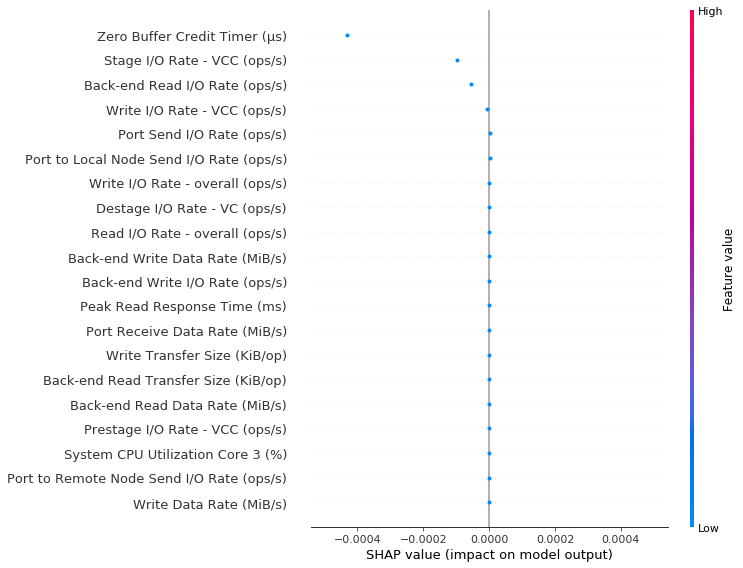

Sample: 63


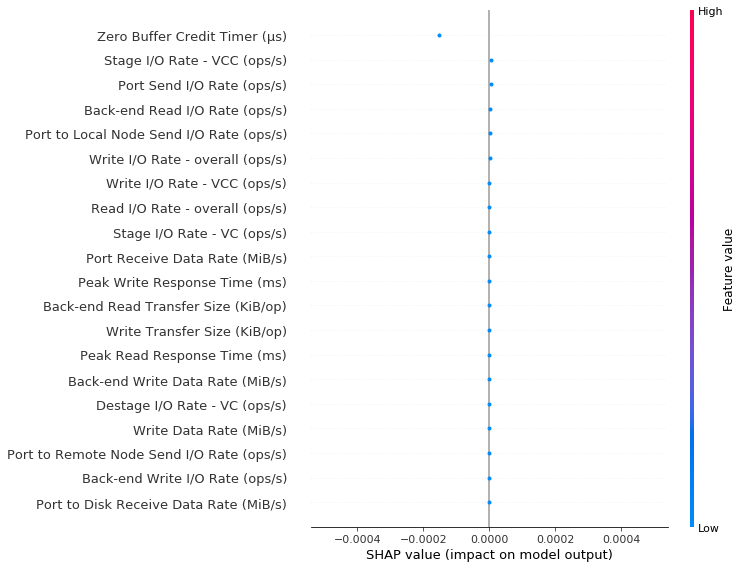

Sample: 64


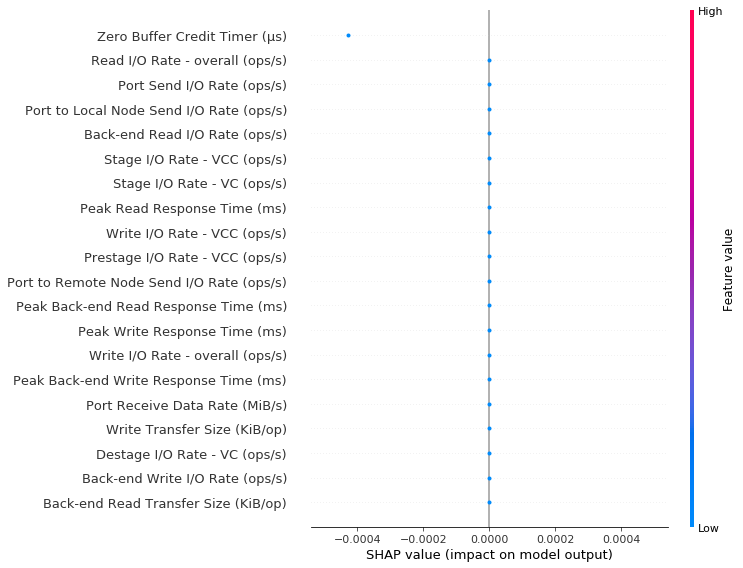

Sample: 65


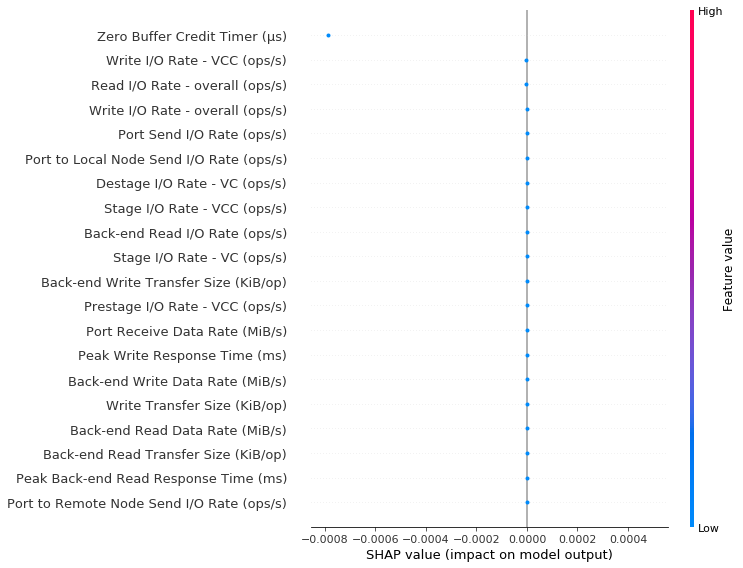

Sample: 67


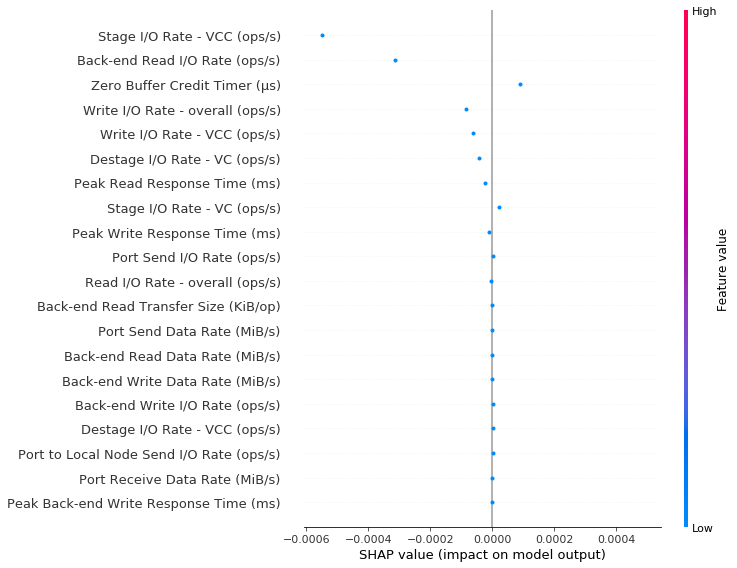

Sample: 68


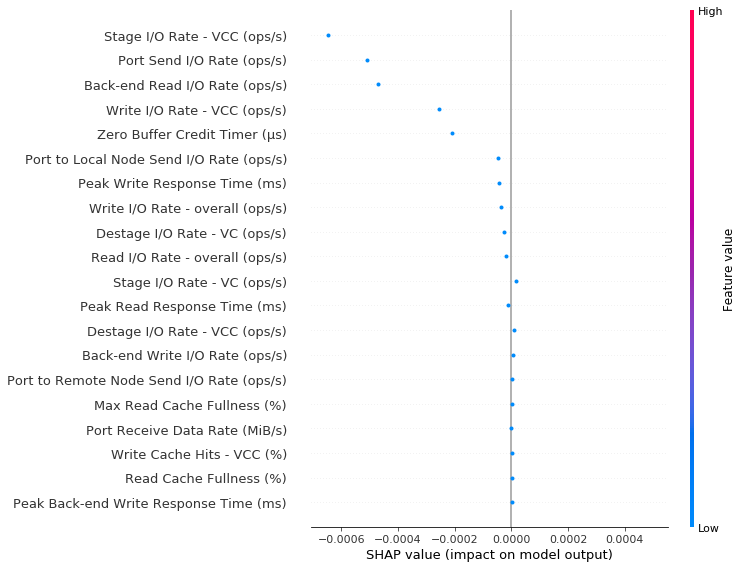

Sample: 69


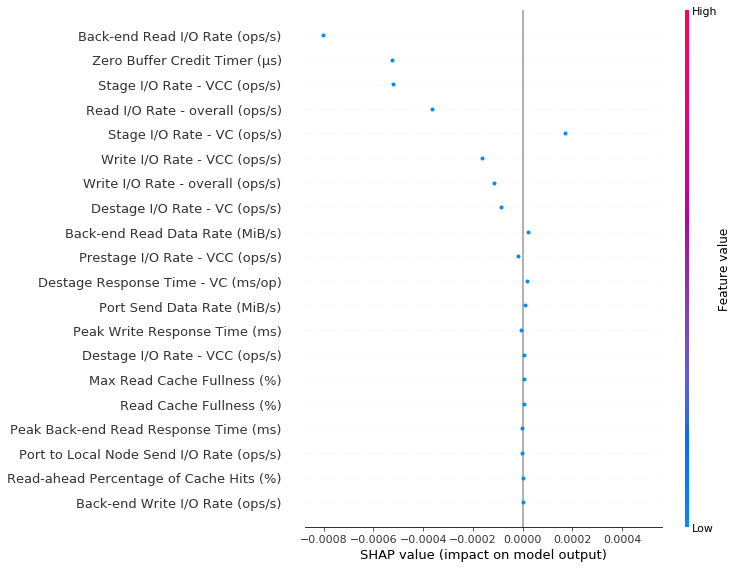

Sample: 70


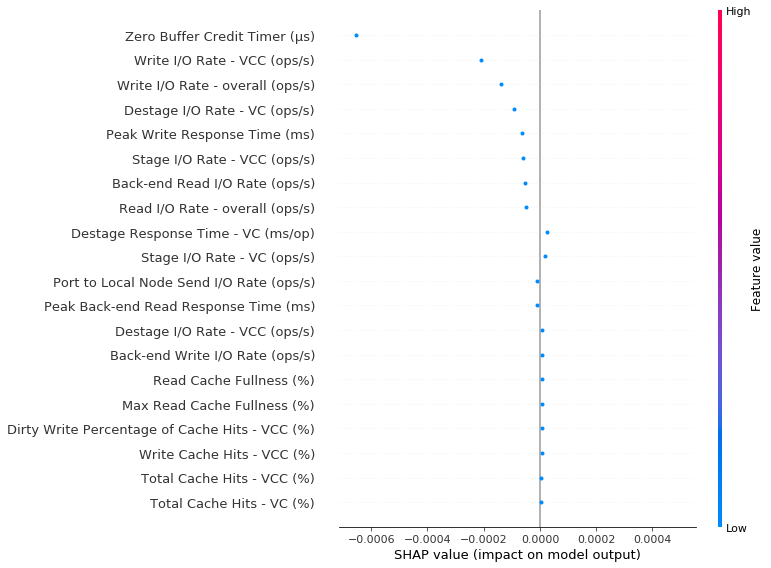

Sample: 72


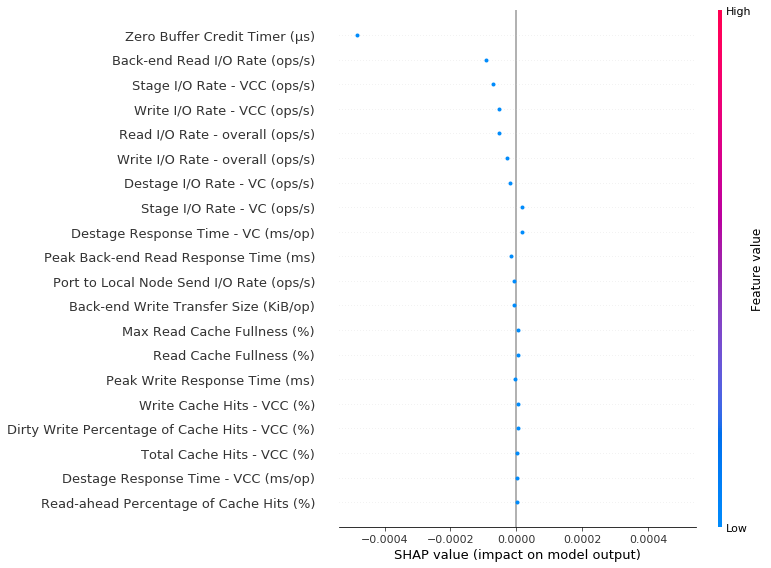

Sample: 74


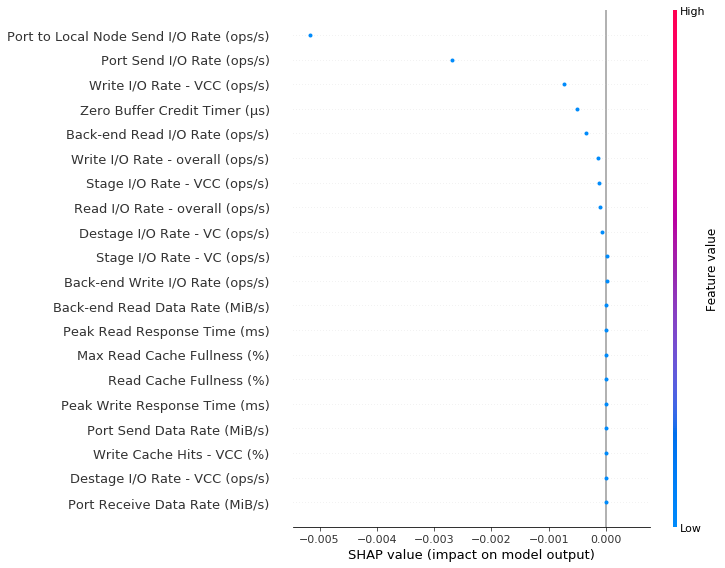

Sample: 76


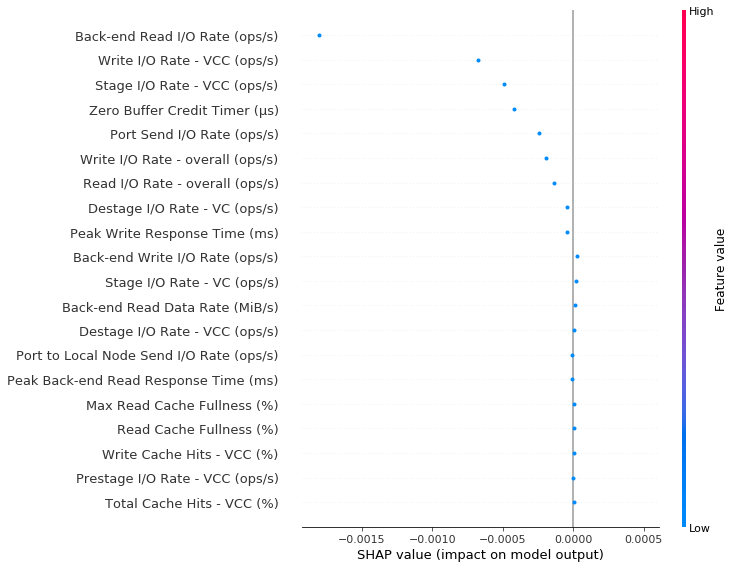

Sample: 78


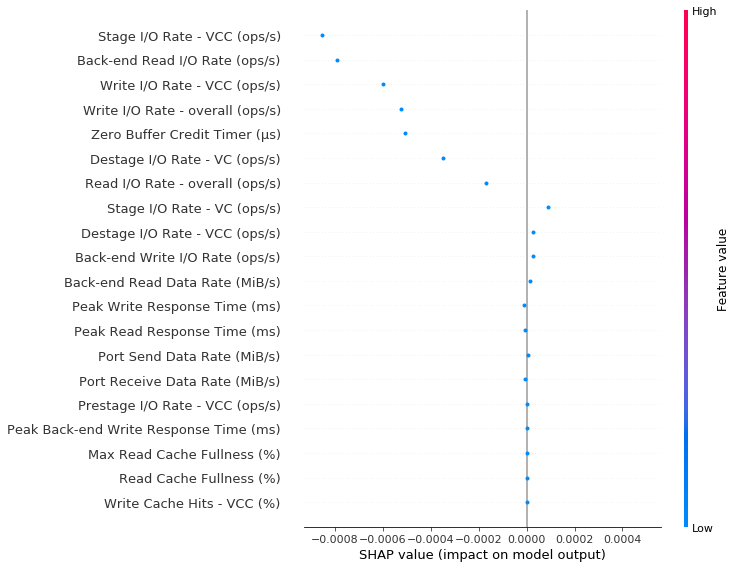

Sample: 80


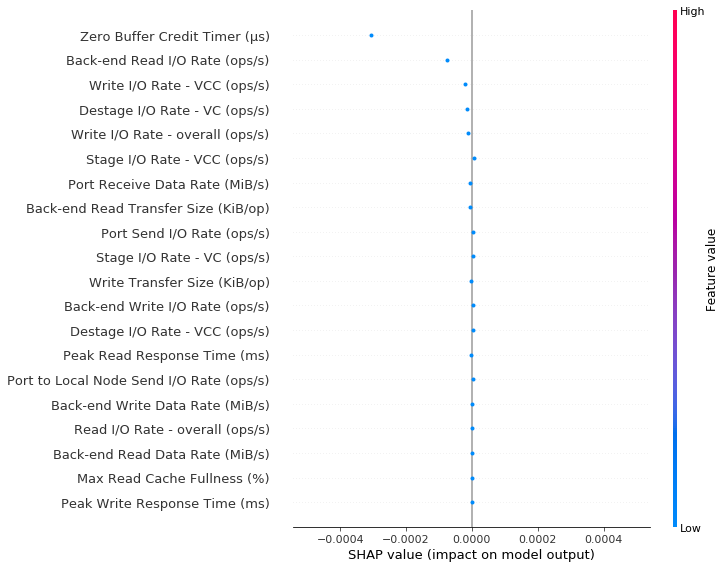

In [36]:
get_plots_per_sample_within_cluster(cluster_indices, shap_values_allTimesteps, samples_allTimesteps, features_order_in_data)

### Feature Importance Lists

In [37]:
features_order_in_data

['Read Cache Hits - VCC (%)',
 'Overall Back-end Response Time (ms/op)',
 'Back-end Read Queue Time (ms/op)',
 'Back-end Write Queue Time (ms/op)',
 'Back-end Read Transfer Size (KiB/op)',
 'Back-end Write Transfer Size (KiB/op)',
 'Read I/O Rate - overall (ops/s)',
 'Write I/O Rate - overall (ops/s)',
 'Peak Back-end Read Response Time (ms)',
 'Port Send Data Rate (MiB/s)',
 'Write Data Rate (MiB/s)',
 'Read Cache Hits - VC (%)',
 'Read Response Time (ms/op)',
 'Write Response Time (ms/op)',
 'Port Receive Data Rate (MiB/s)',
 'Overall Response Time (ms/op)',
 'Read Transfer Size (KiB/op)',
 'Write Transfer Size (KiB/op)',
 'Port Send I/O Rate (ops/s)',
 'Total Cache Hits - VCC (%)',
 'Total Cache Hits - VC (%)',
 'Port to Host Send I/O Rate (ops/s)',
 'Write Cache Hits - VCC (%)',
 'Port to Disk Send I/O Rate (ops/s)',
 'Port to Disk Receive I/O Rate (ops/s)',
 'Port to Local Node Send I/O Rate (ops/s)',
 'Port to Remote Node Send I/O Rate (ops/s)',
 'Port to Disk Send Data Rate (MiB

In [38]:
i_o_rates = []
for feature in features_order_in_data:
    if 'I/O' in feature:
        i_o_rates.append(feature)
i_o_rates

['Read I/O Rate - overall (ops/s)',
 'Write I/O Rate - overall (ops/s)',
 'Port Send I/O Rate (ops/s)',
 'Port to Host Send I/O Rate (ops/s)',
 'Port to Disk Send I/O Rate (ops/s)',
 'Port to Disk Receive I/O Rate (ops/s)',
 'Port to Local Node Send I/O Rate (ops/s)',
 'Port to Remote Node Send I/O Rate (ops/s)',
 'Back-end Read I/O Rate (ops/s)',
 'Global Mirror Write I/O Rate (ops/s)',
 'Global Mirror Overlapping Write I/O Rate (ops/s)',
 'Back-end Write I/O Rate (ops/s)',
 'Write-cache Delay I/O Rate - VCC (ops/s)',
 'Write-cache Delay I/O Rate - VC (ops/s)',
 'Write Cache Write-through I/O Rate - VCC (ops/s)',
 'Write Cache Write-through I/O Rate - VC (ops/s)',
 'Write I/O Rate - VCC (ops/s)',
 'Destage I/O Rate - VC (ops/s)',
 'Destage I/O Rate - VCC (ops/s)',
 'Stage I/O Rate - VC (ops/s)',
 'Stage I/O Rate - VCC (ops/s)',
 'Prestage I/O Rate - VCC (ops/s)',
 'Port Send Delay I/O Percentage (%)']

In [39]:
response_rates = []
for feature in features_order_in_data:
    if 'Response' in feature:
        response_rates.append(feature)
response_rates

['Overall Back-end Response Time (ms/op)',
 'Peak Back-end Read Response Time (ms)',
 'Read Response Time (ms/op)',
 'Write Response Time (ms/op)',
 'Overall Response Time (ms/op)',
 'Port to Local Node Send Response Time (ms/op)',
 'Port to Local Node Receive Response Time (ms/op)',
 'Peak Read Response Time (ms)',
 'Peak Write Response Time (ms)',
 'Overall Host Attributed Response Time Percentage (%)',
 'Peak Back-end Write Response Time (ms)',
 'Destage Response Time - VC (ms/op)',
 'Destage Response Time - VCC (ms/op)',
 'Stage Response Time - VC (ms/op)',
 'Stage Response Time - VCC (ms/op)',
 'Prestage Response Time - VCC (ms/op)',
 'Cache to Host Transfer Response Time (ms/op)',
 'Back-end Read Response Time (ms/op)',
 'Back-end Write Response Time (ms/op)']

#### Cluster 1

In [40]:
cluster_indices = get_anomaly_cluster_association(cluster_labels, 1)
cluster_indices

10 samples in cluster 1


[31, 43, 66, 71, 73, 75, 77, 79, 81, 82]

In [41]:
def get_feature_importance_per_sample(cluster_indices, shap_values, features, i_o_rates, response_rates, _print=True):
    for i in cluster_indices:
        #print("Sample", i)
        vals = shap_values_sample = shap_values[i].reshape(1, shap_values.shape[1])
        feature_importance = pd.DataFrame(list(zip(features, sum(vals))), columns=['col_name','feature_importance_vals'])
        feature_importance.sort_values(by=['feature_importance_vals'], ascending=True,inplace=True)
        top_5 = feature_importance.head(5)
        top_5_features = top_5.col_name
        top_5_features = top_5_features.tolist()
        if _print:
            print(top_5)
            print("")
        io = any(item in i_o_rates for item in top_5_features)
        response = any(item in response_rates for item in top_5_features)
        if io:
            print("Sample",i,": I/O Rate in Top 5 Feature Importance")
        if response:
            print("Sample",i,":Response Time in Top 5 Feature Importance")
        print("")

In [42]:
get_feature_importance_per_sample(cluster_indices, shap_values_allTimesteps, features_order_in_data, i_o_rates, response_rates)

                           col_name  feature_importance_vals
33   Back-end Read I/O Rate (ops/s)                -0.111704
6   Read I/O Rate - overall (ops/s)                -0.106749
62      Stage I/O Rate - VC (ops/s)                -0.092566
59     Write I/O Rate - VCC (ops/s)                -0.062325
18       Port Send I/O Rate (ops/s)                -0.060990

Sample 31 : I/O Rate in Top 5 Feature Importance

                           col_name  feature_importance_vals
6   Read I/O Rate - overall (ops/s)                -0.084890
33   Back-end Read I/O Rate (ops/s)                -0.069238
62      Stage I/O Rate - VC (ops/s)                -0.066237
59     Write I/O Rate - VCC (ops/s)                -0.050971
18       Port Send I/O Rate (ops/s)                -0.047259

Sample 43 : I/O Rate in Top 5 Feature Importance

                           col_name  feature_importance_vals
18       Port Send I/O Rate (ops/s)                -0.083112
62      Stage I/O Rate - VC (ops/s)         

#### Cluster 0

In [43]:
cluster_indices = get_anomaly_cluster_association(cluster_labels, 0)

73 samples in cluster 0


In [44]:
get_feature_importance_per_sample(cluster_indices, shap_values_allTimesteps, features_order_in_data, i_o_rates, response_rates, _print=False)

Sample 0 : I/O Rate in Top 5 Feature Importance

Sample 1 : I/O Rate in Top 5 Feature Importance
Sample 1 :Response Time in Top 5 Feature Importance

Sample 2 : I/O Rate in Top 5 Feature Importance

Sample 3 : I/O Rate in Top 5 Feature Importance

Sample 4 : I/O Rate in Top 5 Feature Importance

Sample 5 : I/O Rate in Top 5 Feature Importance

Sample 6 : I/O Rate in Top 5 Feature Importance

Sample 7 : I/O Rate in Top 5 Feature Importance

Sample 8 : I/O Rate in Top 5 Feature Importance

Sample 9 : I/O Rate in Top 5 Feature Importance

Sample 10 : I/O Rate in Top 5 Feature Importance
Sample 10 :Response Time in Top 5 Feature Importance

Sample 11 : I/O Rate in Top 5 Feature Importance

Sample 12 : I/O Rate in Top 5 Feature Importance

Sample 13 : I/O Rate in Top 5 Feature Importance
Sample 13 :Response Time in Top 5 Feature Importance

Sample 14 : I/O Rate in Top 5 Feature Importance

Sample 15 : I/O Rate in Top 5 Feature Importance

Sample 16 : I/O Rate in Top 5 Feature Importance

Sa

# Get Samples with Response Time in Top5

#### Cluster 1 has no samples with response time in top5

#### Cluster 0

In [45]:
def get_reponse_time_samples(cluster_indices, shap_values, features, i_o_rates, response_rates, _print=True):
    reponse_time_samples = []
    for i in cluster_indices:
        #print("Sample", i)
        vals = shap_values_sample = shap_values[i].reshape(1, shap_values.shape[1])
        feature_importance = pd.DataFrame(list(zip(features, sum(vals))), columns=['col_name','feature_importance_vals'])
        feature_importance.sort_values(by=['feature_importance_vals'], ascending=True,inplace=True)
        top_5 = feature_importance.head(5)
        top_5_features = top_5.col_name
        top_5_features = top_5_features.tolist()
        if _print:
            print(top_5)
            print("")
        io = any(item in i_o_rates for item in top_5_features)
        response = any(item in response_rates for item in top_5_features)
        if response:
            print("Sample",i,":Response Time in Top 5 Feature Importance")
            reponse_time_samples.append(i)
    return reponse_time_samples

In [46]:
cluster_indices = get_anomaly_cluster_association(cluster_labels, 0)

73 samples in cluster 0


In [47]:
get_feature_importance_per_sample(cluster_indices, shap_values_allTimesteps, features_order_in_data, i_o_rates, response_rates, _print=False)

Sample 0 : I/O Rate in Top 5 Feature Importance

Sample 1 : I/O Rate in Top 5 Feature Importance
Sample 1 :Response Time in Top 5 Feature Importance

Sample 2 : I/O Rate in Top 5 Feature Importance

Sample 3 : I/O Rate in Top 5 Feature Importance

Sample 4 : I/O Rate in Top 5 Feature Importance

Sample 5 : I/O Rate in Top 5 Feature Importance

Sample 6 : I/O Rate in Top 5 Feature Importance

Sample 7 : I/O Rate in Top 5 Feature Importance

Sample 8 : I/O Rate in Top 5 Feature Importance

Sample 9 : I/O Rate in Top 5 Feature Importance

Sample 10 : I/O Rate in Top 5 Feature Importance
Sample 10 :Response Time in Top 5 Feature Importance

Sample 11 : I/O Rate in Top 5 Feature Importance

Sample 12 : I/O Rate in Top 5 Feature Importance

Sample 13 : I/O Rate in Top 5 Feature Importance
Sample 13 :Response Time in Top 5 Feature Importance

Sample 14 : I/O Rate in Top 5 Feature Importance

Sample 15 : I/O Rate in Top 5 Feature Importance

Sample 16 : I/O Rate in Top 5 Feature Importance

Sa

In [48]:
respone_time_samples = get_reponse_time_samples(cluster_indices, shap_values_allTimesteps, features_order_in_data, i_o_rates, response_rates, _print=False)

Sample 1 :Response Time in Top 5 Feature Importance
Sample 10 :Response Time in Top 5 Feature Importance
Sample 13 :Response Time in Top 5 Feature Importance
Sample 18 :Response Time in Top 5 Feature Importance
Sample 22 :Response Time in Top 5 Feature Importance
Sample 25 :Response Time in Top 5 Feature Importance
Sample 27 :Response Time in Top 5 Feature Importance
Sample 30 :Response Time in Top 5 Feature Importance
Sample 33 :Response Time in Top 5 Feature Importance
Sample 36 :Response Time in Top 5 Feature Importance
Sample 51 :Response Time in Top 5 Feature Importance
Sample 54 :Response Time in Top 5 Feature Importance
Sample 58 :Response Time in Top 5 Feature Importance
Sample 70 :Response Time in Top 5 Feature Importance


In [49]:
len(respone_time_samples)

14

In [50]:
respone_time_samples = numpy.array(respone_time_samples)
respone_time_samples

array([ 1, 10, 13, 18, 22, 25, 27, 30, 33, 36, 51, 54, 58, 70])

In [51]:
numpy.save("0-SHAP_respone_time_samples_silhouetteScore_0.8633223762692354_MAY03Results.npy",respone_time_samples)

# Samples without Response Time in Top5

In [52]:
cluster_indices = get_anomaly_cluster_association(cluster_labels, 0)

73 samples in cluster 0


In [53]:
respone_time_samples = respone_time_samples.tolist()

In [54]:
print(len(cluster_indices))
print(len(respone_time_samples))

73
14


In [55]:
l3 = [x for x in cluster_indices if x not in respone_time_samples]
print(len(l3))
l3 = numpy.array(l3)
numpy.save("0-SHAP_cluster_0_59_samples_NORESPONSETIME_silhouetteScore_0.8633223762692354_MAY03Results.npy",l3)

59


In [56]:
cluster_indices = get_anomaly_cluster_association(cluster_labels, 1)
cluster_indices = numpy.array(cluster_indices)
print(cluster_indices.shape)
numpy.save("0-SHAP_cluster_1_10_samples_NORESPONSETIME_silhouetteScore_0.8633223762692354_MAY03Results.npy",cluster_indices)

10 samples in cluster 1
(10,)


# Temporal Explanations